# STEP 1: Imports and Get Data

In [14]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [15]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 124
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 4
  num_heads                 : 16
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [16]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [17]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [18]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




[*********************100%***********************]  1 of 1 completed

['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')



Processing AAPL (train): 100%|██████████████████| 1066/1066 [00:00<00:00, 37170.81it/s]
[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.017622  0.015956  0.014373  0.303048
2015-01-05  0.014716  0.013358  0.012551  0.373898
2015-01-06  0.013076  0.012221  0.011819  0.383564
2015-01-07  0.013695  0.012938  0.013763  0.219295
2015-01-08  0.015598  0.016617  0.015641  0.342434
after normalization dataset is Date
2015-01-02    0.015315
2015-01-05    0.012437
2015-01-06    0.012446
2015-01-07    0.013839
2015-01-08    0.017707
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (val): 100%|██████████████████████| 187/187 [00:00<00:00, 35099.56it/s]


In [19]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [20]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


6 1
First input sample (shape: torch.Size([5, 6])):
tensor([[0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0147, 0.0134, 0.0126, 0.0124, 0.3739, 1.0000],
        [0.0131, 0.0122, 0.0118, 0.0124, 0.3836, 2.0000],
        [0.0137, 0.0129, 0.0138, 0.0138, 0.2193, 3.0000],
        [0.0156, 0.0166, 0.0156, 0.0177, 0.3424, 4.0000]])
Corresponding target (shape: torch.Size([5, 6])):
tensor([[0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0176, 0.0160, 0.0144, 0.0153, 0.3030, 0.0000],
        [0.0147, 0.0134, 0.0126, 0.0124, 0.3739, 1.0000],
        [0.0131, 0.0122, 0.0118, 0.0124, 0.3836, 2.0000],
        [0.0137, 0.0129, 0.0138, 0.0138, 0.2193, 3.0000]])
Inputs: torch.Size([16, 5, 6])
Targets: torch.Size([16, 5, 6])
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 5, 124]              --
│    │    └─Linear: 3-1                       [16, 5, 124]              248
│    │    └─GELU: 3-2                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-3                    [16, 5, 124]              248
│    │    └─Dropout: 3-4                      [16, 5, 124]              --
│    └─Sequential: 2-2                        [16, 5, 124]              --
│    │    └─Linear: 3-5                       [16, 5, 124]              248
│    │    └─GELU: 3-6                         [16, 5, 124]              --
│    │    └─LayerNorm: 3-7                    [16, 5, 124]              248
│    │    └─Dropout: 3-8                      [16, 5, 124]              --
│    └─Sequential

# STEP 3: Setup WandB and Trainer

In [21]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc


True

In [22]:
# wandb.finish()

In [23]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


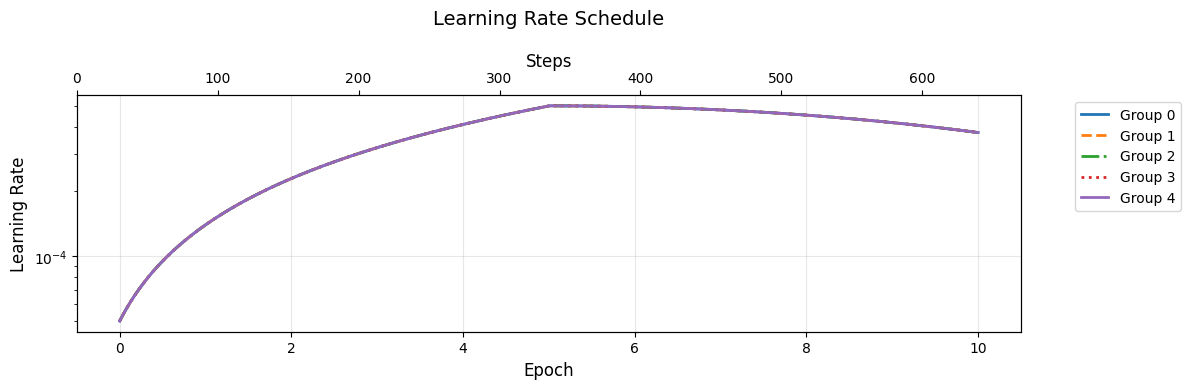

In [24]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [25]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   4%| | 3/67 [00:00<00:06,  9.86it/s, batch_accuracy=2.50%, loss=0.0068, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014187104534357786
abm_loss is 0.004464433528482914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019057843601331115
abm_loss is 0.004618532489985228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002661271020770073
abm_loss is 0.0033978417050093412
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004176463466137648
abm_loss is 0.003004132304340601


Training:   7%| | 5/67 [00:00<00:02, 22.90it/s, batch_accuracy=1.25%, loss=0.0074, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0054927184246480465
abm_loss is 0.002702927915379405
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00653843441978097
abm_loss is 0.003015449270606041


Training:  13%|▏| 9/67 [00:00<00:02, 26.36it/s, batch_accuracy=1.25%, loss=0.0063, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003214113414287567
abm_loss is 0.0022410531528294086
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014633232494816184
abm_loss is 0.002173328772187233
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013655258808284998
abm_loss is 0.0013917633332312107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016650354955345392
abm_loss is 0.003887771163135767


Training:  18%|▏| 12/67 [00:00<00:02, 27.36it/s, batch_accuracy=0.00%, loss=0.0025, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017050787573680282
abm_loss is 0.002893171040341258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010671030031517148
abm_loss is 0.0013414443237707019


Training:  22%|▏| 15/67 [00:00<00:01, 27.84it/s, batch_accuracy=7.50%, loss=0.0070, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013085942482575774
abm_loss is 0.0037855373229831457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017131529748439789
abm_loss is 0.006981563754379749
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00115860253572464
abm_loss is 0.004703691694885492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009634869056753814
abm_loss is 0.0035193690564483404


Training:  25%|▎| 17/67 [00:00<00:01, 27.84it/s, batch_accuracy=7.50%, loss=0.0208, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008265003561973572
abm_loss is 0.009259971790015697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010807181242853403
abm_loss is 0.015258577652275562


Training:  31%|▎| 21/67 [00:00<00:01, 28.91it/s, batch_accuracy=1.25%, loss=0.0210, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013443680945783854
abm_loss is 0.0167126152664423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002358846366405487
abm_loss is 0.013461212627589703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003477961290627718
abm_loss is 0.016184061765670776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006165164988487959
abm_loss is 0.012701964937150478


Training:  33%|▎| 22/67 [00:00<00:01, 28.91it/s, batch_accuracy=2.50%, loss=0.0339, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006768150720745325
abm_loss is 0.022215673699975014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00849266815930605
abm_loss is 0.021848006173968315


Training:  40%|▍| 27/67 [00:00<00:01, 28.91it/s, batch_accuracy=0.00%, loss=0.0471, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012201020494103432
abm_loss is 0.018725251778960228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014466864056885242
abm_loss is 0.01904265023767948
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01607772894203663
abm_loss is 0.027354365214705467
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01706574857234955
abm_loss is 0.02684679627418518


Training:  43%|▍| 29/67 [00:01<00:01, 28.91it/s, batch_accuracy=0.00%, loss=0.0880, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013315401040017605
abm_loss is 0.05214697867631912
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01569834165275097
abm_loss is 0.05874503776431084


Training:  49%|▍| 33/67 [00:01<00:01, 29.16it/s, batch_accuracy=0.00%, loss=0.0595, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029613792896270752
abm_loss is 0.02843918837606907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046086449176073074
abm_loss is 0.01640220545232296
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03685278072953224
abm_loss is 0.017331097275018692
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030091559514403343
abm_loss is 0.029462387785315514


Training:  51%|▌| 34/67 [00:01<00:01, 29.23it/s, batch_accuracy=0.00%, loss=0.0524, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026813888922333717
abm_loss is 0.025713423267006874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01964573934674263
abm_loss is 0.035308584570884705


Training:  58%|▌| 39/67 [00:01<00:00, 29.18it/s, batch_accuracy=27.50%, loss=0.3555, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017620015889406204
abm_loss is 0.04548768699169159
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01187154185026884
abm_loss is 0.08266285061836243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004966945853084326
abm_loss is 0.1599726378917694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026126352604478598
abm_loss is 0.26930952072143555
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.67it/s, batch_accuracy=1.25%, loss=0.2064, mae

mse_loss is 0.005367078818380833
abm_loss is 0.22713947296142578
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011655705980956554
abm_loss is 0.15102137625217438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.31it/s, batch_accuracy=56.25%, loss=1.1938, ma

mse_loss is 0.005245241802185774
abm_loss is 0.31252825260162354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023594738449901342
abm_loss is 0.5549827218055725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029985897708684206
abm_loss is 0.9777910113334656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020652387756854296
abm_loss is 0.9079282879829407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  70%|▋| 47/67 [00:01<00:00, 29.35it/s, batch_accuracy=57.50%, loss=1.7333, ma

mse_loss is 0.0027669761329889297
abm_loss is 1.0139435529708862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034373688977211714
abm_loss is 1.3179970979690552


Training:  76%|▊| 51/67 [00:01<00:00, 29.28it/s, batch_accuracy=43.75%, loss=1.9116, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004106634762138128
abm_loss is 1.0134137868881226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004702493082731962
abm_loss is 1.122406244277954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014920802786946297
abm_loss is 0.9898782968521118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006859754212200642
abm_loss is 1.4520272016525269


Training:  79%|▊| 53/67 [00:01<00:00, 28.92it/s, batch_accuracy=25.00%, loss=1.9645, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010163298808038235
abm_loss is 1.4905331134796143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027025027200579643
abm_loss is 1.3058490753173828


Training:  84%|▊| 56/67 [00:02<00:00, 29.10it/s, batch_accuracy=16.25%, loss=2.4092, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013898310251533985
abm_loss is 2.0168473720550537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016696972772479057
abm_loss is 2.095813751220703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0276041179895401
abm_loss is 1.8199557065963745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0525890551507473
abm_loss is 1.5561329126358032


Training:  88%|▉| 59/67 [00:02<00:00, 29.32it/s, batch_accuracy=0.00%, loss=1.8818, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12484373897314072
abm_loss is 0.9144484400749207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11134383827447891
abm_loss is 1.374171257019043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  94%|▉| 63/67 [00:02<00:00, 29.48it/s, batch_accuracy=0.00%, loss=1.2422, mae

mse_loss is 0.14024098217487335
abm_loss is 1.2105096578598022
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.18760304152965546
abm_loss is 0.8744516372680664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26074185967445374
abm_loss is 0.7015039324760437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.275342732667923
abm_loss is 0.8005863428115845


Training:  97%|▉| 65/67 [00:02<00:00, 29.49it/s, batch_accuracy=0.00%, loss=1.9028, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2555437684059143
abm_loss is 1.0317840576171875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2365015596151352
abm_loss is 1.3240631818771362
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.26it/s, batch_accuracy=0.00%, loss=2.3409, mae


mse_loss is 0.21729247272014618
abm_loss is 1.6678060293197632

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.6292 | train_mae: nan | train_accuracy: 10.2439


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.3274, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1851923018693924
abm_loss is 0.15152573585510254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2360389083623886
abm_loss is 0.18017031252384186


Training:   7%| | 5/67 [00:00<00:02, 23.35it/s, batch_accuracy=0.00%, loss=0.3656, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21470117568969727
abm_loss is 0.15918372571468353
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21455979347229004
abm_loss is 0.16004221141338348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2111307829618454
abm_loss is 0.16694320738315582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21394343674182892
abm_loss is 0.18183688819408417


Training:  12%| | 8/67 [00:00<00:02, 25.92it/s, batch_accuracy=0.00%, loss=0.2789, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.19139088690280914
abm_loss is 0.1545761525630951
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1560104340314865
abm_loss is 0.13006368279457092


Training:  18%|▏| 12/67 [00:00<00:01, 27.91it/s, batch_accuracy=0.00%, loss=0.1569, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15501271188259125
abm_loss is 0.14722901582717896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11442430317401886
abm_loss is 0.09715043753385544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12160742282867432
abm_loss is 0.11363369226455688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08236382156610489
abm_loss is 0.07599983364343643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  19%|▏| 13/67 [00:00<00:01, 27.91it/s, batch_accuracy=0.00%, loss=0.0712, mae

mse_loss is 0.06593050062656403
abm_loss is 0.053050823509693146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04425443336367607
abm_loss is 0.030845627188682556


Training:  27%|▎| 18/67 [00:00<00:01, 28.58it/s, batch_accuracy=2.50%, loss=0.0226, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03451687842607498
abm_loss is 0.022647392004728317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018842235207557678
abm_loss is 0.010520811192691326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012989373877644539
abm_loss is 0.008334031328558922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009004217572510242
abm_loss is 0.012488262727856636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  28%|▎| 19/67 [00:00<00:01, 28.58it/s, batch_accuracy=7.50%, loss=0.0343, mae

mse_loss is 0.005698225926607847
abm_loss is 0.019482990726828575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0071531119756400585
abm_loss is 0.022309495136141777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 29.19it/s, batch_accuracy=10.00%, loss=0.0518, ma

mse_loss is 0.004497447982430458
abm_loss is 0.02958102338016033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0045657469891011715
abm_loss is 0.03076944127678871
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0066720605827867985
abm_loss is 0.05334445461630821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007339081261307001
abm_loss is 0.03554916009306908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  37%|▎| 25/67 [00:00<00:01, 29.14it/s, batch_accuracy=1.25%, loss=0.0475, mae

mse_loss is 0.013817948289215565
abm_loss is 0.03014092706143856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010110626928508282
abm_loss is 0.03086635284125805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.26it/s, batch_accuracy=1.25%, loss=0.0963, mae

mse_loss is 0.0228442270308733
abm_loss is 0.02877926640212536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025630325078964233
abm_loss is 0.033188194036483765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04124874621629715
abm_loss is 0.050572413951158524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03399980813264847
abm_loss is 0.05535714700818062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07883849740028381
abm_loss is 0.034407734870910645


Training:  48%|▍| 32/67 [00:01<00:01, 29.70it/s, batch_accuracy=0.00%, loss=0.1286, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10024314373731613
abm_loss is 0.045021262019872665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0991985946893692
abm_loss is 0.04265948757529259


Training:  52%|▌| 35/67 [00:01<00:01, 29.39it/s, batch_accuracy=0.00%, loss=0.0989, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09667649120092392
abm_loss is 0.04427958279848099
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09331823885440826
abm_loss is 0.04026537761092186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07651837170124054
abm_loss is 0.0349392406642437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06844834983348846
abm_loss is 0.035485561937093735


Training:  57%|▌| 38/67 [00:01<00:00, 29.44it/s, batch_accuracy=2.50%, loss=0.1197, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05451170727610588
abm_loss is 0.062343187630176544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033799465745687485
abm_loss is 0.12420711666345596


Training:  63%|▋| 42/67 [00:01<00:00, 29.72it/s, batch_accuracy=12.50%, loss=0.3845, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02337040565907955
abm_loss is 0.22296042740345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029091788455843925
abm_loss is 0.20262198150157928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03663858771324158
abm_loss is 0.12346476316452026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020158015191555023
abm_loss is 0.28213995695114136


Training:  66%|▋| 44/67 [00:01<00:00, 29.72it/s, batch_accuracy=26.25%, loss=1.0630, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017782965674996376
abm_loss is 0.4788529872894287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013867965899407864
abm_loss is 0.8021335601806641


Training:  72%|▋| 48/67 [00:01<00:00, 29.40it/s, batch_accuracy=0.00%, loss=0.8375, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02968778647482395
abm_loss is 0.7184309959411621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05655190348625183
abm_loss is 0.7205016613006592
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0834764763712883
abm_loss is 0.8328080177307129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.18291817605495453
abm_loss is 0.5411531329154968


Training:  75%|▋| 50/67 [00:01<00:00, 29.40it/s, batch_accuracy=0.00%, loss=0.8807, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.233483225107193
abm_loss is 0.6070154309272766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3197871148586273
abm_loss is 0.5018671751022339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.53it/s, batch_accuracy=0.00%, loss=1.6697, mae

mse_loss is 0.33487027883529663
abm_loss is 0.7771463394165039
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3731086850166321
abm_loss is 0.7416394352912903
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.496869295835495
abm_loss is 0.6727551817893982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4287939965724945
abm_loss is 1.0450968742370605


Training:  84%|▊| 56/67 [00:01<00:00, 29.53it/s, batch_accuracy=0.00%, loss=1.6097, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4863046705722809
abm_loss is 1.0883095264434814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5120974183082581
abm_loss is 0.9554088711738586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.53it/s, batch_accuracy=0.00%, loss=1.4570, mae

mse_loss is 0.6190025210380554
abm_loss is 0.8300647735595703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7550823092460632
abm_loss is 0.5385379791259766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6900245547294617
abm_loss is 0.7791284918785095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7370160222053528
abm_loss is 0.7204360961914062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  93%|▉| 62/67 [00:02<00:00, 29.85it/s, batch_accuracy=0.00%, loss=1.2473, mae

mse_loss is 0.7964874505996704
abm_loss is 0.557708203792572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.839786171913147
abm_loss is 0.5065522789955139
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.64it/s, batch_accuracy=0.00%, loss=2.0321, mae

mse_loss is 0.781201958656311
abm_loss is 0.5901150703430176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6956220269203186
abm_loss is 0.7327218055725098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5723400712013245
abm_loss is 1.0059508085250854
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.4931541383266449
abm_loss is 1.2870970964431763


Training: 100%|█| 67/67 [00:02<00:00, 28.61it/s, batch_accuracy=0.00%, loss=2.0321, mae



📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.5582 | train_mae: nan | train_accuracy: 2.8143


Training:   3%| | 2/67 [00:00<00:03, 16.75it/s, batch_accuracy=0.00%, loss=0.4992, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.22840066254138947
abm_loss is 0.2721993029117584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2064673900604248
abm_loss is 0.27118319272994995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1830049306154251
abm_loss is 0.2460823506116867


Training:   7%| | 5/67 [00:00<00:02, 23.32it/s, batch_accuracy=0.00%, loss=0.2493, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1429755538702011
abm_loss is 0.20084074139595032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0999988541007042
abm_loss is 0.1370687335729599
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05994298681616783
abm_loss is 0.08076953887939453


Training:  12%| | 8/67 [00:00<00:02, 25.84it/s, batch_accuracy=0.00%, loss=0.0539, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04429229721426964
abm_loss is 0.066367007791996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018879637122154236
abm_loss is 0.031066445633769035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006629155017435551
abm_loss is 0.008404743857681751


Training:  16%|▏| 11/67 [00:00<00:02, 25.84it/s, batch_accuracy=0.00%, loss=0.0163, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024068490602076054
abm_loss is 0.0051616281270980835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004217943642288446
abm_loss is 0.003986782860010862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009387779980897903
abm_loss is 0.007453211583197117


Training:  21%|▏| 14/67 [00:00<00:01, 27.65it/s, batch_accuracy=0.00%, loss=0.0753, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01955312490463257
abm_loss is 0.014008252881467342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03759468346834183
abm_loss is 0.024870986118912697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04817211255431175
abm_loss is 0.031934913247823715


Training:  24%|▏| 16/67 [00:00<00:01, 28.12it/s, batch_accuracy=0.00%, loss=0.1110, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061148751527071
abm_loss is 0.040254950523376465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07702537626028061
abm_loss is 0.0438324399292469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08227232843637466
abm_loss is 0.04030613228678703


Training:  30%|▎| 20/67 [00:00<00:01, 28.26it/s, batch_accuracy=0.00%, loss=0.1599, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10120423883199692
abm_loss is 0.04837987944483757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11171078681945801
abm_loss is 0.05612025409936905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12187254428863525
abm_loss is 0.0574219636619091


Training:  34%|▎| 23/67 [00:00<00:01, 29.10it/s, batch_accuracy=0.00%, loss=0.1501, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1398135870695114
abm_loss is 0.06747835129499435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14481805264949799
abm_loss is 0.06367897242307663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12556453049182892
abm_loss is 0.04800092801451683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.24it/s, batch_accuracy=0.00%, loss=0.1458, mae

mse_loss is 0.14404809474945068
abm_loss is 0.06524208933115005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11937756836414337
abm_loss is 0.04893855005502701
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12743324041366577
abm_loss is 0.043743785470724106


Training:  43%|▍| 29/67 [00:01<00:01, 29.05it/s, batch_accuracy=0.00%, loss=0.1061, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10088266432285309
abm_loss is 0.0378083810210228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08221188187599182
abm_loss is 0.03873101621866226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06970538944005966
abm_loss is 0.04399220272898674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.48it/s, batch_accuracy=0.00%, loss=0.0996, mae

mse_loss is 0.07742708176374435
abm_loss is 0.029567917808890343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0881231352686882
abm_loss is 0.0353362038731575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08247517794370651
abm_loss is 0.03228398784995079


Training:  52%|▌| 35/67 [00:01<00:01, 29.38it/s, batch_accuracy=0.00%, loss=0.0715, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04520314559340477
abm_loss is 0.031834568828344345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059223782271146774
abm_loss is 0.031516801565885544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03926737233996391
abm_loss is 0.033742379397153854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.21it/s, batch_accuracy=2.50%, loss=0.1113, mae

mse_loss is 0.028219634667038918
abm_loss is 0.04460499435663223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029598956927657127
abm_loss is 0.0691278800368309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01676221564412117
abm_loss is 0.13547788560390472


Training:  63%|▋| 42/67 [00:01<00:00, 29.56it/s, batch_accuracy=1.25%, loss=0.1951, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010342865251004696
abm_loss is 0.24902160465717316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01986025832593441
abm_loss is 0.18568308651447296
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023793695494532585
abm_loss is 0.1359848529100418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.45it/s, batch_accuracy=30.00%, loss=1.1133, ma

mse_loss is 0.021153170615434647
abm_loss is 0.27931198477745056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019122211262583733
abm_loss is 0.4757736623287201
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015090489760041237
abm_loss is 0.8397710919380188


Training:  72%|▋| 48/67 [00:01<00:00, 29.38it/s, batch_accuracy=0.00%, loss=1.1453, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03630232438445091
abm_loss is 0.6850000023841858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057530272752046585
abm_loss is 0.7033138871192932
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10416822880506516
abm_loss is 0.8170949220657349


Training:  73%|▋| 49/67 [00:01<00:00, 29.38it/s, batch_accuracy=0.00%, loss=0.9308, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.18793568015098572
abm_loss is 0.5574672818183899
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26587724685668945
abm_loss is 0.5684674978256226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.34290218353271484
abm_loss is 0.49274778366088867


Training:  79%|▊| 53/67 [00:01<00:00, 29.33it/s, batch_accuracy=0.00%, loss=1.1611, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.34943416714668274
abm_loss is 0.727727472782135
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.37878668308258057
abm_loss is 0.7469643950462341
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4568929672241211
abm_loss is 0.6429798007011414


Training:  82%|▊| 55/67 [00:01<00:00, 29.40it/s, batch_accuracy=0.00%, loss=1.8186, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.37596774101257324
abm_loss is 1.1113876104354858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3604327142238617
abm_loss is 1.1945199966430664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4295189380645752
abm_loss is 1.06740403175354


Training:  87%|▊| 58/67 [00:02<00:00, 29.29it/s, batch_accuracy=0.00%, loss=1.1885, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5125561356544495
abm_loss is 0.8980141878128052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6502937078475952
abm_loss is 0.5618005990982056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5240975618362427
abm_loss is 0.8685666918754578


Training:  93%|▉| 62/67 [00:02<00:00, 29.29it/s, batch_accuracy=0.00%, loss=1.2127, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5426130294799805
abm_loss is 0.7895702123641968
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6560496091842651
abm_loss is 0.5630140900611877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7105445265769958
abm_loss is 0.5483866930007935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  97%|▉| 65/67 [00:02<00:00, 29.54it/s, batch_accuracy=0.00%, loss=1.7247, mae

mse_loss is 0.6213530898094177
abm_loss is 0.6047738194465637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.551094114780426
abm_loss is 0.8229002356529236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42980828881263733
abm_loss is 1.0864019393920898


Training: 100%|█| 67/67 [00:02<00:00, 28.44it/s, batch_accuracy=0.00%, loss=2.1366, mae


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.39414989948272705
abm_loss is 1.4188746213912964

📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.5535 | train_mae: nan | train_accuracy: 1.3884


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0732, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02524106577038765
abm_loss is 0.04242071881890297


Training:   7%| | 5/67 [00:00<00:02, 23.16it/s, batch_accuracy=0.00%, loss=0.0521, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02721727453172207
abm_loss is 0.055153585970401764
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02400086261332035
abm_loss is 0.049935173243284225
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02114691585302353
abm_loss is 0.046480774879455566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015244901180267334
abm_loss is 0.03165029361844063
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011036288924515247
abm_loss is 0.02096778154373169


Training:   7%| | 5/67 [00:00<00:02, 23.16it/s, batch_accuracy=0.00%, loss=0.0352, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008513135835528374
abm_loss is 0.019787892699241638


Training:  18%|▏| 12/67 [00:00<00:01, 27.74it/s, batch_accuracy=1.25%, loss=0.0029, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006621192675083876
abm_loss is 0.014259961433708668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034888938535004854
abm_loss is 0.004716595634818077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002430747961625457
abm_loss is 0.005734130274504423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010264002485200763
abm_loss is 0.0020323959179222584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013083507074043155
abm_loss is 0.0014891045866534114


Training:  18%|▏| 12/67 [00:00<00:01, 27.74it/s, batch_accuracy=2.50%, loss=0.0034, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011320642661303282
abm_loss is 0.001968908356502652


Training:  24%|▏| 16/67 [00:00<00:01, 28.20it/s, batch_accuracy=0.00%, loss=0.0103, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019157141214236617
abm_loss is 0.0033743015956133604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027068094350397587
abm_loss is 0.002278338884934783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030213668942451477
abm_loss is 0.002467787591740489
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0039147501811385155
abm_loss is 0.005778882186859846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004531694110482931
abm_loss is 0.008739707060158253


Training:  27%|▎| 18/67 [00:00<00:01, 28.55it/s, batch_accuracy=2.50%, loss=0.0146, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0068587735295295715
abm_loss is 0.011645333841443062


Training:  34%|▎| 23/67 [00:00<00:01, 28.77it/s, batch_accuracy=0.00%, loss=0.0999, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014494351111352444
abm_loss is 0.00895865261554718
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017801253125071526
abm_loss is 0.012072513811290264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02857494354248047
abm_loss is 0.011686647310853004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04614400863647461
abm_loss is 0.018736833706498146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08470567315816879
abm_loss is 0.03138633444905281


Training:  36%|▎| 24/67 [00:00<00:01, 29.03it/s, batch_accuracy=0.00%, loss=0.1362, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10988068580627441
abm_loss is 0.04568369314074516


Training:  42%|▍| 28/67 [00:01<00:01, 29.03it/s, batch_accuracy=0.00%, loss=0.1768, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11955096572637558
abm_loss is 0.05311541631817818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14064854383468628
abm_loss is 0.055254172533750534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13394390046596527
abm_loss is 0.05327528342604637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15451224148273468
abm_loss is 0.05305583029985428
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13300959765911102
abm_loss is 0.049943722784519196


Training:  45%|▍| 30/67 [00:01<00:01, 29.09it/s, batch_accuracy=0.00%, loss=0.1578, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11341625452041626
abm_loss is 0.04280325025320053


Training:  52%|▌| 35/67 [00:01<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0861, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13704274594783783
abm_loss is 0.06690072268247604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09589099138975143
abm_loss is 0.037378065288066864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08627362549304962
abm_loss is 0.03501228615641594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06931290775537491
abm_loss is 0.02832038514316082
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0657024160027504
abm_loss is 0.03089272975921631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.43it/s, batch_accuracy=0.00%, loss=0.0836, mae

mse_loss is 0.04856681451201439
abm_loss is 0.03800235316157341


Training:  61%|▌| 41/67 [00:01<00:00, 29.26it/s, batch_accuracy=1.25%, loss=0.2032, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04167111963033676
abm_loss is 0.06483127921819687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023213230073451996
abm_loss is 0.1285129338502884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018612978979945183
abm_loss is 0.22365711629390717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02603810839354992
abm_loss is 0.18176837265491486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023896247148513794
abm_loss is 0.14213724434375763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.26it/s, batch_accuracy=7.50%, loss=0.3811, mae

mse_loss is 0.02023862674832344
abm_loss is 0.27952656149864197


Training:  72%|▋| 48/67 [00:01<00:00, 29.67it/s, batch_accuracy=0.00%, loss=1.0652, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02648637257516384
abm_loss is 0.4264690577983856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033741507679224014
abm_loss is 0.7778975367546082
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053811151534318924
abm_loss is 0.6522219777107239
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09245915710926056
abm_loss is 0.6500056385993958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14953863620758057
abm_loss is 0.7321484088897705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23828859627246857
abm_loss is 0.5063681602478027


Training:  79%|▊| 53/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=1.2416, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42116862535476685
abm_loss is 0.5031595230102539
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5228702425956726
abm_loss is 0.4176791310310364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5402135848999023
abm_loss is 0.6263260841369629
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5112703442573547
abm_loss is 0.6743115782737732
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5264654755592346
abm_loss is 0.6675468683242798
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4392659366130829
abm_loss is 1.0156934261322021


Training:  82%|▊| 55/67 [00:01<00:00, 29.70it/s, batch_accuracy=0.00%, loss=1.6383, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.84it/s, batch_accuracy=0.00%, loss=1.3986, mae

mse_loss is 0.48493146896362305
abm_loss is 1.0822266340255737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49358677864074707
abm_loss is 0.9846178293228149
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5342500805854797
abm_loss is 0.884647786617279
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6684837341308594
abm_loss is 0.5046373605728149
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5694983005523682
abm_loss is 0.7988718152046204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5986551642417908
abm_loss is 0.7489785552024841
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.62it/s, batch_accuracy=0.00%, loss=2.2018, mae

mse_loss is 0.651042640209198
abm_loss is 0.5768730044364929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6844525933265686
abm_loss is 0.5274941325187683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6369864344596863
abm_loss is 0.6091986894607544
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5332032442092896
abm_loss is 0.8315842747688293
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.45068618655204773
abm_loss is 1.088998556137085
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3446190655231476
abm_loss is 1.4946917295455933


Training: 100%|█| 67/67 [00:02<00:00, 28.52it/s, batch_accuracy=0.00%, loss=2.2018, mae



📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.5042 | train_mae: nan | train_accuracy: 1.5572


Training:   3%| | 2/67 [00:00<00:04, 15.33it/s, batch_accuracy=0.00%, loss=0.0243, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023705612402409315
abm_loss is 0.00855826772749424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038964462000876665
abm_loss is 0.01645100675523281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005042003467679024
abm_loss is 0.019902095198631287


Training:   7%| | 5/67 [00:00<00:02, 22.80it/s, batch_accuracy=5.00%, loss=0.0139, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030741256196051836
abm_loss is 0.015804627910256386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019066736567765474
abm_loss is 0.009548596106469631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017164513701573014
abm_loss is 0.005265388172119856


Training:  13%|▏| 9/67 [00:00<00:02, 26.34it/s, batch_accuracy=2.50%, loss=0.0034, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014848198043182492
abm_loss is 0.005957027431577444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009641727665439248
abm_loss is 0.0030477726832032204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019365911139175296
abm_loss is 0.001585199497640133


Training:  15%|▏| 10/67 [00:00<00:02, 26.34it/s, batch_accuracy=1.25%, loss=0.0046, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016891260165721178
abm_loss is 0.0013466831296682358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002743767574429512
abm_loss is 0.0020188267808407545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002840967383235693
abm_loss is 0.0020340404007583857


Training:  19%|▏| 13/67 [00:00<00:01, 27.16it/s, batch_accuracy=1.25%, loss=0.0050, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003559958888217807
abm_loss is 0.0020428544376045465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032188494224101305
abm_loss is 0.0021389650646597147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003382935421541333
abm_loss is 0.0022800450678914785


Training:  25%|▎| 17/67 [00:00<00:01, 27.81it/s, batch_accuracy=5.00%, loss=0.0153, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004540859721601009
abm_loss is 0.0022361117880791426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003950401674956083
abm_loss is 0.005257084965705872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003419014858081937
abm_loss is 0.009866698645055294


Training:  28%|▎| 19/67 [00:00<00:01, 28.44it/s, batch_accuracy=3.75%, loss=0.0174, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004144326783716679
abm_loss is 0.013452279381453991
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004588560666888952
abm_loss is 0.01081859227269888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0054437266662716866
abm_loss is 0.015070212073624134


Training:  33%|▎| 22/67 [00:00<00:01, 28.56it/s, batch_accuracy=3.75%, loss=0.0322, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006141600664705038
abm_loss is 0.014812766574323177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008388837799429893
abm_loss is 0.02009391039609909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009162557311356068
abm_loss is 0.022732818499207497


Training:  40%|▍| 27/67 [00:00<00:01, 29.06it/s, batch_accuracy=0.00%, loss=0.0466, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013752946630120277
abm_loss is 0.01806795783340931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02021731622517109
abm_loss is 0.01672632060945034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021909527480602264
abm_loss is 0.023916024714708328


Training:  45%|▍| 30/67 [00:01<00:01, 29.31it/s, batch_accuracy=0.00%, loss=0.0914, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03378521278500557
abm_loss is 0.024190789088606834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03682514652609825
abm_loss is 0.03954791650176048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05061352252960205
abm_loss is 0.042872775346040726


Training:  49%|▍| 33/67 [00:01<00:01, 29.36it/s, batch_accuracy=0.00%, loss=0.1661, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07845614105463028
abm_loss is 0.03290177881717682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10632983595132828
abm_loss is 0.04647980257868767
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13367515802383423
abm_loss is 0.05592918395996094


Training:  51%|▌| 34/67 [00:01<00:01, 29.36it/s, batch_accuracy=0.00%, loss=0.1696, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1519884318113327
abm_loss is 0.05740406736731529
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.141530379652977
abm_loss is 0.05440803989768028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13608889281749725
abm_loss is 0.04999243840575218


Training:  57%|▌| 38/67 [00:01<00:00, 29.31it/s, batch_accuracy=0.00%, loss=0.1681, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1580026000738144
abm_loss is 0.06119968369603157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16514693200588226
abm_loss is 0.06638584285974503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11720677465200424
abm_loss is 0.06610257178544998


Training:  60%|▌| 40/67 [00:01<00:00, 29.41it/s, batch_accuracy=1.25%, loss=0.2393, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09996357560157776
abm_loss is 0.13191543519496918
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09658093750476837
abm_loss is 0.13122132420539856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09213357418775558
abm_loss is 0.0842093974351883


Training:  64%|▋| 43/67 [00:01<00:00, 29.28it/s, batch_accuracy=1.25%, loss=0.5138, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08399447053670883
abm_loss is 0.18579745292663574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08260801434516907
abm_loss is 0.34767505526542664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07383295893669128
abm_loss is 0.6212548613548279


Training:  70%|▋| 47/67 [00:01<00:00, 29.31it/s, batch_accuracy=0.00%, loss=1.0410, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1010519489645958
abm_loss is 0.5293206572532654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15919063985347748
abm_loss is 0.5686314702033997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21001772582530975
abm_loss is 0.6818599104881287


Training:  75%|▋| 50/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=0.9081, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3301566541194916
abm_loss is 0.45476290583610535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3879130780696869
abm_loss is 0.4786674678325653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4049563407897949
abm_loss is 0.4777326285839081


Training:  79%|▊| 53/67 [00:01<00:00, 29.38it/s, batch_accuracy=0.00%, loss=1.2496, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4109637439250946
abm_loss is 0.7231711745262146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4460221230983734
abm_loss is 0.7392775416374207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5073971748352051
abm_loss is 0.6837541460990906


Training:  84%|▊| 56/67 [00:02<00:00, 29.32it/s, batch_accuracy=0.00%, loss=1.6308, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3989368975162506
abm_loss is 1.1196080446243286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3886791169643402
abm_loss is 1.1840461492538452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.45487838983535767
abm_loss is 1.0016695261001587


Training:  90%|▉| 60/67 [00:02<00:00, 29.69it/s, batch_accuracy=0.00%, loss=1.4584, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5162925124168396
abm_loss is 0.8585399985313416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6598755121231079
abm_loss is 0.5328909754753113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5295335650444031
abm_loss is 0.831016480922699


Training:  94%|▉| 63/67 [00:02<00:00, 29.46it/s, batch_accuracy=0.00%, loss=1.1855, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5390117764472961
abm_loss is 0.7882490158081055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5985003709793091
abm_loss is 0.6092444062232971
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6581375598907471
abm_loss is 0.555350124835968


Training:  97%|▉| 65/67 [00:02<00:00, 29.46it/s, batch_accuracy=0.00%, loss=1.7718, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6012031435966492
abm_loss is 0.5884398818016052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5470871925354004
abm_loss is 0.7669392824172974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4527280032634735
abm_loss is 1.1101731061935425


Training: 100%|█| 67/67 [00:02<00:00, 28.35it/s, batch_accuracy=0.00%, loss=2.1248, mae


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3942931294441223
abm_loss is 1.409854531288147

📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.4853 | train_mae: nan | train_accuracy: 0.9568


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0211, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004762301687151194
abm_loss is 0.013561281375586987


Training:   7%| | 5/67 [00:00<00:02, 22.96it/s, batch_accuracy=5.00%, loss=0.0173, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006078674923628569
abm_loss is 0.020845983177423477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004710852634161711
abm_loss is 0.01855568401515484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0047255614772439
abm_loss is 0.019552061334252357
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028172824531793594
abm_loss is 0.011707439087331295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019313412485644221
abm_loss is 0.0066299946047365665


Training:   7%| | 5/67 [00:00<00:02, 22.96it/s, batch_accuracy=0.00%, loss=0.0100, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017199907451868057
abm_loss is 0.008033759891986847


Training:  18%|▏| 12/67 [00:00<00:01, 27.65it/s, batch_accuracy=1.25%, loss=0.0022, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014925254508852959
abm_loss is 0.005254372488707304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010684591252356768
abm_loss is 0.001149295479990542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007672459469176829
abm_loss is 0.0019675721414387226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012963544577360153
abm_loss is 0.0015113444533199072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011956393718719482
abm_loss is 0.0010671551572158933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  18%|▏| 12/67 [00:00<00:01, 27.65it/s, batch_accuracy=3.75%, loss=0.0030, mae

mse_loss is 0.0014373703161254525
abm_loss is 0.0015105538768693805


Training:  27%|▎| 18/67 [00:00<00:01, 28.64it/s, batch_accuracy=6.25%, loss=0.0183, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001600168296135962
abm_loss is 0.003159433603286743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001667852164246142
abm_loss is 0.002555296290665865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019189048325642943
abm_loss is 0.0028655820060521364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014519451651722193
abm_loss is 0.008745981380343437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011264380300417542
abm_loss is 0.013309711590409279
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 28.64it/s, batch_accuracy=12.50%, loss=0.0267, ma

mse_loss is 0.0010361431632190943
abm_loss is 0.019801339134573936


Training:  36%|▎| 24/67 [00:00<00:01, 29.02it/s, batch_accuracy=18.75%, loss=0.0471, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017931230831891298
abm_loss is 0.015213987790048122
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016526862746104598
abm_loss is 0.024520423263311386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001577062183059752
abm_loss is 0.022577378898859024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001776647986844182
abm_loss is 0.030240625143051147
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015427983598783612
abm_loss is 0.03507813438773155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035249607171863317
abm_loss is 0.02711881510913372


Training:  43%|▍| 29/67 [00:01<00:01, 28.93it/s, batch_accuracy=6.25%, loss=0.1065, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003937258385121822
abm_loss is 0.028602629899978638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038070559967309237
abm_loss is 0.04123846814036369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004996208008378744
abm_loss is 0.040573980659246445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004092875402420759
abm_loss is 0.07391013950109482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006362710148096085
abm_loss is 0.07775651663541794
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 28.93it/s, batch_accuracy=0.00%, loss=0.0587, mae

mse_loss is 0.016548437997698784
abm_loss is 0.035929691046476364


Training:  52%|▌| 35/67 [00:01<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0868, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03208107873797417
abm_loss is 0.013704897835850716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03384358063340187
abm_loss is 0.017965609207749367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032734330743551254
abm_loss is 0.029806649312376976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05231374502182007
abm_loss is 0.026538103818893433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06217757612466812
abm_loss is 0.03325377404689789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07632388174533844
abm_loss is 0.03511785715818405


Training:  63%|▋| 42/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=0.2688, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08867614716291428
abm_loss is 0.05274834856390953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11976128071546555
abm_loss is 0.07159243524074554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15221750736236572
abm_loss is 0.11616885662078857
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.20093627274036407
abm_loss is 0.11904740333557129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21158455312252045
abm_loss is 0.09298037737607956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.20461176335811615
abm_loss is 0.15024183690547943


Training:  63%|▋| 42/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=0.3391, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.46it/s, batch_accuracy=0.00%, loss=0.8556, mae

mse_loss is 0.15826545655727386
abm_loss is 0.253417044878006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.22977200150489807
abm_loss is 0.44367191195487976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1395636647939682
abm_loss is 0.5099818110466003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21560290455818176
abm_loss is 0.5267879366874695
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.22955678403377533
abm_loss is 0.6286731362342834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2786259353160858
abm_loss is 0.5044539570808411
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.54it/s, batch_accuracy=0.00%, loss=1.6959, mae

mse_loss is 0.36786094307899475
abm_loss is 0.5043570399284363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4774761199951172
abm_loss is 0.44262051582336426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44782209396362305
abm_loss is 0.6664361357688904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4791404902935028
abm_loss is 0.6834895014762878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49060583114624023
abm_loss is 0.6365360617637634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4114048182964325
abm_loss is 1.0741863250732422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 29.64it/s, batch_accuracy=0.00%, loss=1.4829, mae

mse_loss is 0.43258628249168396
abm_loss is 1.126948356628418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4387412667274475
abm_loss is 0.9987052083015442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5062048435211182
abm_loss is 0.8966585397720337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6595651507377625
abm_loss is 0.5185878872871399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5004374384880066
abm_loss is 0.8650386929512024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5388850569725037
abm_loss is 0.8170162439346313


Training:  91%|▉| 61/67 [00:02<00:00, 29.43it/s, batch_accuracy=0.00%, loss=1.4465, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.19it/s, batch_accuracy=0.00%, loss=2.1259, mae

mse_loss is 0.6104904413223267
abm_loss is 0.6066602468490601
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6600903272628784
abm_loss is 0.48426762223243713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6475624442100525
abm_loss is 0.6106360554695129
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5648706555366516
abm_loss is 0.7978376746177673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44919320940971375
abm_loss is 1.0776844024658203
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.36639082431793213
abm_loss is 1.4253902435302734


Training: 100%|█| 67/67 [00:02<00:00, 28.48it/s, batch_accuracy=0.00%, loss=2.1259, mae



📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.4735 | train_mae: nan | train_accuracy: 2.7017


Training:   6%| | 4/67 [00:00<00:05, 11.77it/s, batch_accuracy=0.00%, loss=0.0098, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00969337485730648
abm_loss is 0.005461665336042643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007155486848205328
abm_loss is 0.003646109951660037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008300078101456165
abm_loss is 0.004464928060770035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008016780950129032
abm_loss is 0.004137658979743719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00808654259890318
abm_loss is 0.0032044281251728535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009230273775756359
abm_loss is 0.004579408559948206


Training:  15%|▏| 10/67 [00:00<00:02, 21.05it/s, batch_accuracy=0.00%, loss=0.0130, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007991621270775795
abm_loss is 0.0037565117236226797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009562887251377106
abm_loss is 0.005012799054384232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01201646588742733
abm_loss is 0.010220184922218323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008948149159550667
abm_loss is 0.005164171103388071
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00763701880350709
abm_loss is 0.005852209869772196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007986626587808132
abm_loss is 0.0061354911886155605


Training:  24%|▏| 16/67 [00:00<00:02, 25.01it/s, batch_accuracy=7.50%, loss=0.0113, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005880362819880247
abm_loss is 0.0031312131322920322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005480682943016291
abm_loss is 0.002771400148048997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004572691395878792
abm_loss is 0.0016969650750979781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004861862398684025
abm_loss is 0.0030906149186193943
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002279796404764056
abm_loss is 0.007406983058899641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019803051836788654
abm_loss is 0.01129291020333767


Training:  34%|▎| 23/67 [00:01<00:01, 27.34it/s, batch_accuracy=17.50%, loss=0.0527, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001140609267167747
abm_loss is 0.019436432048678398
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001430036500096321
abm_loss is 0.01783626154065132
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010773235699161887
abm_loss is 0.02660319022834301
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012538324808701873
abm_loss is 0.024634195491671562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012816468952223659
abm_loss is 0.03948598727583885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012883913004770875
abm_loss is 0.04071534797549248


Training:  45%|▍| 30/67 [00:01<00:01, 28.78it/s, batch_accuracy=30.00%, loss=0.1302, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001218300312757492
abm_loss is 0.03483323007822037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001834716065786779
abm_loss is 0.03658245876431465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014514292124658823
abm_loss is 0.05069544538855553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011493742931634188
abm_loss is 0.055844761431217194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013849659590050578
abm_loss is 0.08408709615468979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016287118196487427
abm_loss is 0.09829851239919662
shape

Training:  54%|▌| 36/67 [00:01<00:01, 28.85it/s, batch_accuracy=0.00%, loss=0.0686, mae

mse_loss is 0.005678886082023382
abm_loss is 0.049520041793584824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014318647794425488
abm_loss is 0.012710570357739925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012894973158836365
abm_loss is 0.023669149726629257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013699578121304512
abm_loss is 0.04170055687427521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019557727500796318
abm_loss is 0.028747284784913063
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020554572343826294
abm_loss is 0.04142088443040848


Training:  61%|▌| 41/67 [00:01<00:00, 29.39it/s, batch_accuracy=0.00%, loss=0.1881, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02645415998995304
abm_loss is 0.0432937853038311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029019493609666824
abm_loss is 0.06569036096334457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022617539390921593
abm_loss is 0.11924749612808228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029620671644806862
abm_loss is 0.18691937625408173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05359490588307381
abm_loss is 0.13929785788059235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10968291759490967
abm_loss is 0.08532582968473434
shape of tgt_c

Training:  70%|▋| 47/67 [00:01<00:00, 29.16it/s, batch_accuracy=0.00%, loss=0.9933, mae

mse_loss is 0.10570211708545685
abm_loss is 0.1798468679189682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15194891393184662
abm_loss is 0.2625542879104614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3025698661804199
abm_loss is 0.41065168380737305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3424864411354065
abm_loss is 0.3652363419532776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.46556732058525085
abm_loss is 0.38005226850509644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3804437220096588
abm_loss is 0.5555295348167419
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  79%|▊| 53/67 [00:02<00:00, 29.53it/s, batch_accuracy=0.00%, loss=1.2196, mae

mse_loss is 0.42251554131507874
abm_loss is 0.4102361798286438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4879938066005707
abm_loss is 0.44559985399246216
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49360546469688416
abm_loss is 0.4248315393924713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44779378175735474
abm_loss is 0.6549208760261536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4466060698032379
abm_loss is 0.7299780249595642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4319218099117279
abm_loss is 0.7007264494895935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.68it/s, batch_accuracy=0.00%, loss=1.4528, mae

mse_loss is 0.3287128806114197
abm_loss is 1.1616661548614502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36723703145980835
abm_loss is 1.2074402570724487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.38640227913856506
abm_loss is 1.0653361082077026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.467539519071579
abm_loss is 0.9325420260429382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5672928690910339
abm_loss is 0.5845003128051758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5073078274726868
abm_loss is 0.8384941220283508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5479436516761

Training:  99%|▉| 66/67 [00:02<00:00, 29.56it/s, batch_accuracy=0.00%, loss=2.1011, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6206000447273254
abm_loss is 0.5986759066581726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6435707211494446
abm_loss is 0.5163242220878601
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6393401026725769
abm_loss is 0.6286270022392273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5304738879203796
abm_loss is 0.7884454131126404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4810517430305481
abm_loss is 1.096425175666809
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.422058641910553
abm_loss is 1.377128005027771


Training: 100%|█| 67/67 [00:02<00:00, 26.04it/s, batch_accuracy=0.00%, loss=2.1011, mae



📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.4732 | train_mae: nan | train_accuracy: 3.7336


Training:   1%| | 1/67 [00:00<00:06,  9.84it/s, batch_accuracy=0.00%, loss=0.0230, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0222044475376606
abm_loss is 0.01332334615290165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01801256835460663
abm_loss is 0.00798486266285181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016178248450160027
abm_loss is 0.007056887727230787


Training:   7%| | 5/67 [00:00<00:02, 22.90it/s, batch_accuracy=0.00%, loss=0.0253, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015996498987078667
abm_loss is 0.006313764955848455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018852530047297478
abm_loss is 0.00929619837552309
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019194141030311584
abm_loss is 0.01134765986353159


Training:  12%| | 8/67 [00:00<00:02, 25.76it/s, batch_accuracy=0.00%, loss=0.0352, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019052891060709953
abm_loss is 0.010044450871646404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015214658342301846
abm_loss is 0.008941513486206532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019165068864822388
abm_loss is 0.016679130494594574


Training:  16%|▏| 11/67 [00:00<00:02, 27.16it/s, batch_accuracy=0.00%, loss=0.0215, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015071406960487366
abm_loss is 0.009987053461372852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014482525177299976
abm_loss is 0.01151970960199833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012290863320231438
abm_loss is 0.009913250803947449


Training:  22%|▏| 15/67 [00:00<00:01, 28.43it/s, batch_accuracy=0.00%, loss=0.0100, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012307453900575638
abm_loss is 0.0074356915429234505
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008351176045835018
abm_loss is 0.004512398969382048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007389664184302092
abm_loss is 0.00368107040412724


Training:  27%|▎| 18/67 [00:00<00:01, 28.75it/s, batch_accuracy=6.25%, loss=0.0145, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006087895482778549
abm_loss is 0.0027540591545403004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032364081125706434
abm_loss is 0.004885748028755188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002187328180298209
abm_loss is 0.00990261323750019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  31%|▎| 21/67 [00:00<00:01, 29.05it/s, batch_accuracy=15.00%, loss=0.0309, ma

mse_loss is 0.0016013553831726313
abm_loss is 0.01888730190694332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021095687989145517
abm_loss is 0.012712097726762295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011966731399297714
abm_loss is 0.022928735241293907


Training:  36%|▎| 24/67 [00:00<00:01, 29.25it/s, batch_accuracy=15.00%, loss=0.0524, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001660732552409172
abm_loss is 0.024051060900092125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011980693088844419
abm_loss is 0.033743347972631454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008039778331294656
abm_loss is 0.03945804014801979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  40%|▍| 27/67 [00:00<00:01, 29.26it/s, batch_accuracy=18.75%, loss=0.0634, ma

mse_loss is 0.0016498368931934237
abm_loss is 0.032241061329841614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002439614152535796
abm_loss is 0.03261619433760643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018918864661827683
abm_loss is 0.04729995131492615


Training:  45%|▍| 30/67 [00:01<00:01, 29.25it/s, batch_accuracy=13.75%, loss=0.1239, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025885780341923237
abm_loss is 0.0478583388030529
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002416249830275774
abm_loss is 0.08184125274419785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002891833893954754
abm_loss is 0.09284363687038422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.25it/s, batch_accuracy=0.00%, loss=0.0390, mae

mse_loss is 0.009219256229698658
abm_loss is 0.04132672771811485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019918203353881836
abm_loss is 0.011475412175059319
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019112039357423782
abm_loss is 0.019639713689684868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.68it/s, batch_accuracy=0.00%, loss=0.0653, mae

mse_loss is 0.019765811040997505
abm_loss is 0.033878300338983536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027409091591835022
abm_loss is 0.025054050609469414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027084171772003174
abm_loss is 0.035434797406196594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03164147213101387
abm_loss is 0.03955540433526039


Training:  57%|▌| 38/67 [00:01<00:00, 29.77it/s, batch_accuracy=0.00%, loss=0.1655, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032573699951171875
abm_loss is 0.0586797371506691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0328020341694355
abm_loss is 0.10874227434396744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.43it/s, batch_accuracy=0.00%, loss=0.2863, mae

mse_loss is 0.04014437273144722
abm_loss is 0.16023726761341095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05887552723288536
abm_loss is 0.14019159972667694
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07660624384880066
abm_loss is 0.09054828435182571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09112231433391571
abm_loss is 0.16989094018936157


Training:  66%|▋| 44/67 [00:01<00:00, 29.67it/s, batch_accuracy=0.00%, loss=0.7325, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08569446951150894
abm_loss is 0.31802693009376526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.18288365006446838
abm_loss is 0.46121644973754883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.88it/s, batch_accuracy=0.00%, loss=0.8309, mae

mse_loss is 0.22495336830615997
abm_loss is 0.3842964768409729
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.29839444160461426
abm_loss is 0.42054054141044617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42001643776893616
abm_loss is 0.5267633199691772
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5139120817184448
abm_loss is 0.36145269870758057


Training:  76%|▊| 51/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=0.9392, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.563884437084198
abm_loss is 0.44007596373558044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.615631103515625
abm_loss is 0.3902629017829895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.72it/s, batch_accuracy=0.00%, loss=1.6637, mae

mse_loss is 0.5300781726837158
abm_loss is 0.6243011355400085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4819491505622864
abm_loss is 0.7110151648521423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5392838716506958
abm_loss is 0.6219652891159058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44775018095970154
abm_loss is 1.0305461883544922


Training:  84%|▊| 56/67 [00:01<00:00, 29.72it/s, batch_accuracy=0.00%, loss=1.6596, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.39194199442863464
abm_loss is 1.1936702728271484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4423886239528656
abm_loss is 1.0302331447601318
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4288144111633301
abm_loss is 0.9627062082290649


Training:  90%|▉| 60/67 [00:02<00:00, 29.89it/s, batch_accuracy=0.00%, loss=1.3828, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5816349387168884
abm_loss is 0.5358203053474426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5107346177101135
abm_loss is 0.8728237152099609
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.542756199836731
abm_loss is 0.7664899230003357


Training:  94%|▉| 63/67 [00:02<00:00, 29.68it/s, batch_accuracy=0.00%, loss=1.1774, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5947960019111633
abm_loss is 0.6263980269432068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.654033362865448
abm_loss is 0.524086594581604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5844202041625977
abm_loss is 0.588070273399353


Training:  99%|▉| 66/67 [00:02<00:00, 29.71it/s, batch_accuracy=0.00%, loss=2.1219, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.562959611415863
abm_loss is 0.7655009627342224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48056674003601074
abm_loss is 1.0802186727523804
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.39122453331947327
abm_loss is 1.4092477560043335


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=0.00%, loss=2.1219, mae



📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.4703 | train_mae: nan | train_accuracy: 2.5328


Training:   3%| | 2/67 [00:00<00:04, 15.95it/s, batch_accuracy=1.25%, loss=0.0077, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004880846012383699
abm_loss is 0.0029864259995520115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004356095101684332
abm_loss is 0.003570935223251581
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003211038187146187
abm_loss is 0.003567171050235629


Training:   7%| | 5/67 [00:00<00:02, 23.26it/s, batch_accuracy=0.00%, loss=0.0087, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004896634723991156
abm_loss is 0.003402719274163246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005885745864361525
abm_loss is 0.0035274499095976353
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00696559576317668
abm_loss is 0.0033848106395453215


Training:  13%|▏| 9/67 [00:00<00:02, 26.67it/s, batch_accuracy=0.00%, loss=0.0222, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006390740163624287
abm_loss is 0.003041668329387903
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00854781549423933
abm_loss is 0.004955762065947056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012336059473454952
abm_loss is 0.010364683344960213


Training:  18%|▏| 12/67 [00:00<00:01, 27.58it/s, batch_accuracy=0.00%, loss=0.0182, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009507167153060436
abm_loss is 0.005856565665453672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012290784157812595
abm_loss is 0.010007333941757679
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010500839911401272
abm_loss is 0.008342643268406391


Training:  19%|▏| 13/67 [00:00<00:01, 27.58it/s, batch_accuracy=0.00%, loss=0.0123, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009851360693573952
abm_loss is 0.005974486470222473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009237753227353096
abm_loss is 0.0045179398730397224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007269999478012323
abm_loss is 0.0030578451696783304


Training:  25%|▎| 17/67 [00:00<00:01, 28.08it/s, batch_accuracy=2.50%, loss=0.0138, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006796314846724272
abm_loss is 0.0031401978339999914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004726252518594265
abm_loss is 0.004891098476946354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003615260124206543
abm_loss is 0.00857849046587944


Training:  30%|▎| 20/67 [00:00<00:01, 28.79it/s, batch_accuracy=1.25%, loss=0.0249, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036112272646278143
abm_loss is 0.014574497938156128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003903742181137204
abm_loss is 0.011470367200672626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030250772833824158
abm_loss is 0.017347872257232666


Training:  33%|▎| 22/67 [00:00<00:01, 28.92it/s, batch_accuracy=5.00%, loss=0.0366, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038765862118452787
abm_loss is 0.017392924055457115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029399425256997347
abm_loss is 0.02628581039607525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032217116095125675
abm_loss is 0.029599471017718315


Training:  39%|▍| 26/67 [00:00<00:01, 29.03it/s, batch_accuracy=0.00%, loss=0.0525, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004714555572718382
abm_loss is 0.022532904520630836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005379965528845787
abm_loss is 0.026848623529076576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005626843310892582
abm_loss is 0.03698750212788582


Training:  43%|▍| 29/67 [00:01<00:01, 29.57it/s, batch_accuracy=1.25%, loss=0.1000, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0083249406889081
abm_loss is 0.03498893603682518
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006666592787951231
abm_loss is 0.061234887689352036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007756732404232025
abm_loss is 0.0720410943031311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.46it/s, batch_accuracy=0.00%, loss=0.0503, mae

mse_loss is 0.01872243732213974
abm_loss is 0.030758565291762352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033670615404844284
abm_loss is 0.013815052807331085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03776122257113457
abm_loss is 0.018352245911955833


Training:  52%|▌| 35/67 [00:01<00:01, 29.39it/s, batch_accuracy=0.00%, loss=0.0717, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03317020833492279
abm_loss is 0.030124014243483543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04424967244267464
abm_loss is 0.023991059511899948
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043996233493089676
abm_loss is 0.031413301825523376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.48it/s, batch_accuracy=0.00%, loss=0.1532, mae

mse_loss is 0.049903567880392075
abm_loss is 0.035803236067295074
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04342242702841759
abm_loss is 0.054620396345853806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04987528175115585
abm_loss is 0.09033074229955673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.56it/s, batch_accuracy=0.00%, loss=0.1698, mae

mse_loss is 0.05178394913673401
abm_loss is 0.15895414352416992
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05738077312707901
abm_loss is 0.13387106359004974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08316383510828018
abm_loss is 0.08541153371334076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08352948725223541
abm_loss is 0.16727526485919952


Training:  66%|▋| 44/67 [00:01<00:00, 29.59it/s, batch_accuracy=0.00%, loss=0.8031, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0838686153292656
abm_loss is 0.3104839324951172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13602584600448608
abm_loss is 0.5397440791130066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.36it/s, batch_accuracy=0.00%, loss=0.8135, mae

mse_loss is 0.17317980527877808
abm_loss is 0.42546531558036804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26037755608558655
abm_loss is 0.4256894290447235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.37081441283226013
abm_loss is 0.5337287783622742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4760335385799408
abm_loss is 0.368164598941803


Training:  76%|▊| 51/67 [00:01<00:00, 29.66it/s, batch_accuracy=0.00%, loss=0.9216, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5402899384498596
abm_loss is 0.4321011006832123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5319826602935791
abm_loss is 0.42101404070854187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.6657, mae

mse_loss is 0.5453595519065857
abm_loss is 0.6125842928886414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5325803756713867
abm_loss is 0.6573731303215027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5139434933662415
abm_loss is 0.6533608436584473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4519089162349701
abm_loss is 1.0298494100570679


Training:  84%|▊| 56/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.6037, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4323910176753998
abm_loss is 1.1087006330490112
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4404909312725067
abm_loss is 0.9886518716812134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 29.42it/s, batch_accuracy=0.00%, loss=1.5352, mae

mse_loss is 0.5192016363143921
abm_loss is 0.8828977942466736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6632620692253113
abm_loss is 0.52861088514328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5573104619979858
abm_loss is 0.8748230338096619
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5918604731559753
abm_loss is 0.7047873139381409


Training:  93%|▉| 62/67 [00:02<00:00, 29.52it/s, batch_accuracy=0.00%, loss=1.1020, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6464595198631287
abm_loss is 0.5848047137260437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6525443196296692
abm_loss is 0.4947105348110199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6029991507530212
abm_loss is 0.5801863074302673


Training:  99%|▉| 66/67 [00:02<00:00, 29.73it/s, batch_accuracy=0.00%, loss=2.0859, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5233722925186157
abm_loss is 0.808510959148407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4365592896938324
abm_loss is 1.1180753707885742
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3955520987510681
abm_loss is 1.3795794248580933


Training: 100%|█| 67/67 [00:02<00:00, 28.55it/s, batch_accuracy=0.00%, loss=2.0859, mae



📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.4630 | train_mae: nan | train_accuracy: 0.7880


Training:   3%| | 2/67 [00:00<00:03, 16.56it/s, batch_accuracy=8.75%, loss=0.0134, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012309831799939275
abm_loss is 0.004988932050764561
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011820598738268018
abm_loss is 0.009542211890220642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008967817993834615
abm_loss is 0.007353640627115965


Training:   7%| | 5/67 [00:00<00:02, 23.58it/s, batch_accuracy=3.75%, loss=0.0060, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011873480398207903
abm_loss is 0.00684942165389657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013383617624640465
abm_loss is 0.003835654351860285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028144530951976776
abm_loss is 0.0019135642796754837


Training:  12%| | 8/67 [00:00<00:02, 26.02it/s, batch_accuracy=0.00%, loss=0.0089, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002573414472863078
abm_loss is 0.0018286133417859674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00358205521479249
abm_loss is 0.002207649638876319
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005191507283598185
abm_loss is 0.004007540177553892


Training:  18%|▏| 12/67 [00:00<00:01, 27.75it/s, batch_accuracy=0.00%, loss=0.0140, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005503056105226278
abm_loss is 0.0032912471797317266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007242502178996801
abm_loss is 0.005309001542627811
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008082135580480099
abm_loss is 0.006384716369211674


Training:  19%|▏| 13/67 [00:00<00:01, 27.75it/s, batch_accuracy=0.00%, loss=0.0093, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007038133684545755
abm_loss is 0.0037071057595312595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006876181345432997
abm_loss is 0.003426960203796625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007712873164564371
abm_loss is 0.003500174731016159


Training:  24%|▏| 16/67 [00:00<00:01, 28.20it/s, batch_accuracy=2.50%, loss=0.0106, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00714996038004756
abm_loss is 0.00294319330714643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005790695082396269
abm_loss is 0.004994030576199293
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004746051970869303
abm_loss is 0.0071884021162986755


Training:  30%|▎| 20/67 [00:00<00:01, 28.55it/s, batch_accuracy=5.00%, loss=0.0257, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004582423251122236
abm_loss is 0.011384052224457264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005888589657843113
abm_loss is 0.009844235144555569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004553250968456268
abm_loss is 0.017169877886772156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 29.13it/s, batch_accuracy=0.00%, loss=0.0370, mae

mse_loss is 0.005605166312307119
abm_loss is 0.013985872268676758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0057139284908771515
abm_loss is 0.01939256303012371
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005618178751319647
abm_loss is 0.025215476751327515
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.18it/s, batch_accuracy=0.00%, loss=0.0434, mae

mse_loss is 0.007886522449553013
abm_loss is 0.022403797134757042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010144106112420559
abm_loss is 0.021188069134950638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012105369940400124
abm_loss is 0.026635413989424706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.17it/s, batch_accuracy=0.00%, loss=0.0941, mae

mse_loss is 0.012173238210380077
abm_loss is 0.030637705698609352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012253479100763798
abm_loss is 0.05466964468359947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014357238076627254
abm_loss is 0.06403865665197372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0547, mae

mse_loss is 0.02665994130074978
abm_loss is 0.028503520414233208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044565655291080475
abm_loss is 0.015726374462246895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045364588499069214
abm_loss is 0.017679745331406593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04109331592917442


Training:  52%|▌| 35/67 [00:01<00:01, 29.53it/s, batch_accuracy=0.00%, loss=0.0762, mae

abm_loss is 0.030587702989578247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05157022550702095
abm_loss is 0.024528255686163902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053018033504486084
abm_loss is 0.030035782605409622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.35it/s, batch_accuracy=0.00%, loss=0.1525, mae

mse_loss is 0.06464337557554245
abm_loss is 0.03074691630899906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05277519300580025
abm_loss is 0.05178317055106163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05632562190294266
abm_loss is 0.08638947457075119
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.68it/s, batch_accuracy=0.00%, loss=0.1850, mae

mse_loss is 0.05857585743069649
abm_loss is 0.14916549623012543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06935447454452515
abm_loss is 0.1287287026643753
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09796437621116638
abm_loss is 0.08915489912033081
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.68it/s, batch_accuracy=0.00%, loss=0.7645, mae

mse_loss is 0.07159395515918732
abm_loss is 0.18519650399684906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08353319764137268
abm_loss is 0.3173846900463104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10835113376379013
abm_loss is 0.5249279737472534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.42it/s, batch_accuracy=0.00%, loss=0.9613, mae

mse_loss is 0.17079566419124603
abm_loss is 0.4170030653476715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21500368416309357
abm_loss is 0.4763043522834778
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26988106966018677
abm_loss is 0.5895747542381287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  75%|▋| 50/67 [00:01<00:00, 29.42it/s, batch_accuracy=0.00%, loss=0.8965, mae

mse_loss is 0.48117050528526306
abm_loss is 0.3804008662700653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5168941617012024
abm_loss is 0.4204404056072235
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5653470158576965
abm_loss is 0.38422712683677673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  79%|▊| 53/67 [00:01<00:00, 29.66it/s, batch_accuracy=0.00%, loss=1.2212, mae

mse_loss is 0.5572831034660339
abm_loss is 0.5977072715759277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5400875806808472
abm_loss is 0.6692895293235779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5224235653877258
abm_loss is 0.6541661024093628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  84%|▊| 56/67 [00:01<00:00, 29.48it/s, batch_accuracy=0.00%, loss=1.6161, mae

mse_loss is 0.4420377314090729
abm_loss is 1.0629570484161377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4307827055454254
abm_loss is 1.115599274635315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49749040603637695
abm_loss is 0.9680008888244629
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 29.45it/s, batch_accuracy=0.00%, loss=1.4533, mae

mse_loss is 0.5103065967559814
abm_loss is 0.8732926249504089
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.622047483921051
abm_loss is 0.5486960411071777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5696372389793396
abm_loss is 0.8059673309326172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  93%|▉| 62/67 [00:02<00:00, 29.89it/s, batch_accuracy=0.00%, loss=1.1528, mae

mse_loss is 0.5671719908714294
abm_loss is 0.7585899233818054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6277027130126953
abm_loss is 0.5958716869354248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6440841555595398
abm_loss is 0.537850022315979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6084141135215759
abm_loss is 0.585405707359314


Training:  97%|▉| 65/67 [00:02<00:00, 29.70it/s, batch_accuracy=0.00%, loss=1.7639, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5166058540344238
abm_loss is 0.7851976752281189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42453938722610474
abm_loss is 1.1190351247787476
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.36808088421821594
abm_loss is 1.4357905387878418


Training: 100%|█| 67/67 [00:02<00:00, 28.62it/s, batch_accuracy=0.00%, loss=2.1407, mae



📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.4631 | train_mae: nan | train_accuracy: 0.6567


Training:   3%| | 2/67 [00:00<00:04, 16.04it/s, batch_accuracy=3.75%, loss=0.0229, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003045053221285343
abm_loss is 0.010406570509076118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003384263953194022
abm_loss is 0.01564602367579937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027844158466905355
abm_loss is 0.015328699722886086


Training:   7%| | 5/67 [00:00<00:02, 23.00it/s, batch_accuracy=2.50%, loss=0.0099, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018582625780254602
abm_loss is 0.013655781745910645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012857571709901094
abm_loss is 0.00687100226059556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006785766454413533
abm_loss is 0.0029311696998775005


Training:  12%| | 8/67 [00:00<00:02, 25.72it/s, batch_accuracy=2.50%, loss=0.0036, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008317711181007326
abm_loss is 0.003548570442944765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017212297534570098
abm_loss is 0.0018161438638344407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003194391494616866
abm_loss is 0.002400176366791129


Training:  18%|▏| 12/67 [00:00<00:01, 27.84it/s, batch_accuracy=0.00%, loss=0.0109, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036792808678001165
abm_loss is 0.0018448446644470096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005034721922129393
abm_loss is 0.0038297963328659534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0064660534262657166
abm_loss is 0.004898281302303076


Training:  22%|▏| 15/67 [00:00<00:01, 28.39it/s, batch_accuracy=0.00%, loss=0.0084, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005966625642031431
abm_loss is 0.003040886716917157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006284093949943781
abm_loss is 0.0025098600890487432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006668583955615759
abm_loss is 0.00285712699405849
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  24%|▏| 16/67 [00:00<00:01, 28.39it/s, batch_accuracy=1.25%, loss=0.0100, mae

mse_loss is 0.008085504174232483
abm_loss is 0.003489826573058963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0061932955868542194
abm_loss is 0.004361428786069155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048614367842674255
abm_loss is 0.008570891804993153


Training:  30%|▎| 20/67 [00:00<00:01, 28.52it/s, batch_accuracy=1.25%, loss=0.0234, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004634066950529814
abm_loss is 0.011890481226146221
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007101514842361212
abm_loss is 0.00850168988108635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005537264980375767
abm_loss is 0.014883816242218018
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005701616872102022
abm_loss is 0.013723899610340595


Training:  34%|▎| 23/67 [00:00<00:01, 29.25it/s, batch_accuracy=0.00%, loss=0.0341, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005676889792084694
abm_loss is 0.022580211982131004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008185953833162785
abm_loss is 0.021646833047270775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  40%|▍| 27/67 [00:00<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0450, mae

mse_loss is 0.009084748104214668
abm_loss is 0.020036322996020317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012156871147453785
abm_loss is 0.018962910398840904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012336881831288338
abm_loss is 0.027962375432252884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014945602975785732
abm_loss is 0.026370752602815628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.56it/s, batch_accuracy=0.00%, loss=0.0857, mae

mse_loss is 0.012605552561581135
abm_loss is 0.052009593695402145
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01663282886147499
abm_loss is 0.05647449567914009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03181411325931549
abm_loss is 0.02682996168732643


Training:  49%|▍| 33/67 [00:01<00:01, 29.62it/s, batch_accuracy=0.00%, loss=0.0701, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04811278358101845
abm_loss is 0.01710822433233261
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05089598894119263
abm_loss is 0.019735170528292656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04867922142148018
abm_loss is 0.027665341272950172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.86it/s, batch_accuracy=0.00%, loss=0.0874, mae

mse_loss is 0.064816914498806
abm_loss is 0.02801273576915264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06615858525037766
abm_loss is 0.029530314728617668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0642935186624527
abm_loss is 0.032586485147476196


Training:  60%|▌| 40/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=0.2288, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05578724294900894
abm_loss is 0.04718461260199547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06242033466696739
abm_loss is 0.08127736300230026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05506882071495056
abm_loss is 0.14513252675533295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=0.1740, mae

mse_loss is 0.06861705332994461
abm_loss is 0.11961743980646133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11396216601133347
abm_loss is 0.07237452268600464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10108385235071182
abm_loss is 0.16508188843727112


Training:  67%|▋| 45/67 [00:01<00:00, 29.54it/s, batch_accuracy=0.00%, loss=0.6756, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11739025264978409
abm_loss is 0.27329036593437195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1301761120557785
abm_loss is 0.49104833602905273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1670457422733307
abm_loss is 0.42626485228538513
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23321442306041718
abm_loss is 0.47247573733329773


Training:  72%|▋| 48/67 [00:01<00:00, 29.96it/s, batch_accuracy=0.00%, loss=0.8039, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3360922634601593
abm_loss is 0.5232822299003601
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4495076835155487
abm_loss is 0.3748829662799835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  76%|▊| 51/67 [00:01<00:00, 29.58it/s, batch_accuracy=0.00%, loss=1.1803, mae

mse_loss is 0.49746546149253845
abm_loss is 0.42213183641433716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5309622883796692
abm_loss is 0.3991919159889221
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48668143153190613
abm_loss is 0.6418470740318298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4931875169277191
abm_loss is 0.649526059627533


Training:  81%|▊| 54/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=1.6922, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.572090744972229
abm_loss is 0.5890159010887146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.472968190908432
abm_loss is 1.03887939453125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 29.69it/s, batch_accuracy=0.00%, loss=1.1198, mae

mse_loss is 0.4670144021511078
abm_loss is 1.0799099206924438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42238473892211914
abm_loss is 0.9940647482872009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4941122233867645
abm_loss is 0.8667356371879578
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6340833902359009
abm_loss is 0.5180044770240784


Training:  90%|▉| 60/67 [00:02<00:00, 29.69it/s, batch_accuracy=0.00%, loss=1.3880, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5207433700561523
abm_loss is 0.8212653994560242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5689584016799927
abm_loss is 0.7566028833389282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6112717986106873
abm_loss is 0.5829156637191772


Training:  97%|▉| 65/67 [00:02<00:00, 29.63it/s, batch_accuracy=0.00%, loss=1.3809, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6372305154800415
abm_loss is 0.545677900314331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6193203926086426
abm_loss is 0.6124066710472107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5381177067756653
abm_loss is 0.7675065994262695


Training: 100%|█| 67/67 [00:02<00:00, 28.68it/s, batch_accuracy=0.00%, loss=2.1543, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4551246166229248
abm_loss is 1.0766677856445312
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.39492636919021606
abm_loss is 1.4319459199905396

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.4577 | train_mae: nan | train_accuracy: 0.7317


Training:   7%| | 5/67 [00:00<00:02, 22.59it/s, batch_accuracy=5.00%, loss=0.0136, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004132465459406376
abm_loss is 0.012396670877933502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004406664054840803
abm_loss is 0.01835291087627411
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003696967614814639
abm_loss is 0.017680073156952858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027933765668421984
abm_loss is 0.015893710777163506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016706085298210382
abm_loss is 0.009446442127227783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008867123979143798
abm_loss is 0.0036240480840206146


Training:  18%|▏| 12/67 [00:00<00:02, 27.50it/s, batch_accuracy=0.00%, loss=0.0059, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007453472935594618
abm_loss is 0.005291296634823084
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007466940442100167
abm_loss is 0.0023464502301067114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001694589271210134
abm_loss is 0.0011890940368175507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017294951248914003
abm_loss is 0.0012872647494077682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032951869070529938
abm_loss is 0.0027064040768891573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035727806389331818
abm_loss is 0.00261326576583

Training:  27%|▎| 18/67 [00:00<00:01, 28.62it/s, batch_accuracy=3.75%, loss=0.0142, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034398019779473543
abm_loss is 0.002010601805523038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038578466046601534
abm_loss is 0.0015071682864800096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004199943970888853
abm_loss is 0.0022666745353490114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0046838740818202496
abm_loss is 0.002045293105766177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034074150025844574
abm_loss is 0.0052348594181239605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030855443328619003
abm_loss is 0.009175559505820

Training:  34%|▎| 23/67 [00:00<00:01, 29.21it/s, batch_accuracy=3.75%, loss=0.0400, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032894115429371595
abm_loss is 0.012266337871551514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003228106303140521
abm_loss is 0.011353732086718082
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003467308823019266
abm_loss is 0.016487114131450653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004203430842608213
abm_loss is 0.014810505323112011
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037193738389760256
abm_loss is 0.024396969005465508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004286081995815039
abm_loss is 0.02820460870862007


Training:  43%|▍| 29/67 [00:01<00:01, 29.44it/s, batch_accuracy=1.25%, loss=0.0990, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006166534032672644
abm_loss is 0.023290449753403664
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00832551158964634
abm_loss is 0.02143222466111183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008066548965871334
abm_loss is 0.03172838315367699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007627177517861128
abm_loss is 0.03504571318626404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007873768918216228
abm_loss is 0.06111760064959526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008997352793812752
abm_loss is 0.07064979523420334
shape of t

Training:  52%|▌| 35/67 [00:01<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0725, mae

mse_loss is 0.018659839406609535
abm_loss is 0.031672943383455276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03425062447786331
abm_loss is 0.012958175502717495
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033748775720596313
abm_loss is 0.016461698338389397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030461793765425682
abm_loss is 0.02926572971045971
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04001031070947647
abm_loss is 0.023498499765992165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04591609537601471
abm_loss is 0.031006047502160072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.63it/s, batch_accuracy=0.00%, loss=0.1724, mae

mse_loss is 0.04807664826512337
abm_loss is 0.03290446847677231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04165150597691536
abm_loss is 0.057277191430330276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04661647602915764
abm_loss is 0.0910789966583252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0383416973054409
abm_loss is 0.1711377650499344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05440012365579605
abm_loss is 0.12488162517547607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08256440609693527
abm_loss is 0.08772941678762436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0751

Training:  73%|▋| 49/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=0.8049, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07318197935819626
abm_loss is 0.31487616896629333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11982803791761398
abm_loss is 0.5114583373069763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1660328358411789
abm_loss is 0.4255189001560211
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2561053931713104
abm_loss is 0.41024690866470337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36738598346710205
abm_loss is 0.5258540511131287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4124157428741455
abm_loss is 0.39520031213760376


Training:  81%|▊| 54/67 [00:01<00:00, 29.93it/s, batch_accuracy=0.00%, loss=1.6688, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5441372990608215
abm_loss is 0.3938639163970947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6493712663650513
abm_loss is 0.34822407364845276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5576168894767761
abm_loss is 0.5693653225898743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5610877871513367
abm_loss is 0.6124445796012878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.512193500995636
abm_loss is 0.6280660033226013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4636448919773102
abm_loss is 1.0260018110275269
shape of tgt_combined: torch

Training:  90%|▉| 60/67 [00:02<00:00, 29.82it/s, batch_accuracy=0.00%, loss=1.3774, mae

mse_loss is 0.417874813079834
abm_loss is 1.1197490692138672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47323304414749146
abm_loss is 0.9565923810005188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5322715044021606
abm_loss is 0.8465450406074524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6181785464286804
abm_loss is 0.5170385241508484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.552526593208313
abm_loss is 0.7746171355247498
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5375958681106567
abm_loss is 0.7650781273841858
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.94it/s, batch_accuracy=0.00%, loss=2.1565, mae

mse_loss is 0.6411835551261902
abm_loss is 0.5846308469772339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6549183130264282
abm_loss is 0.5032545924186707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.577268123626709
abm_loss is 0.6030039191246033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5228278040885925
abm_loss is 0.7874180674552917
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42827674746513367
abm_loss is 1.1272696256637573
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3756386339664459
abm_loss is 1.443820595741272


Training: 100%|█| 67/67 [00:02<00:00, 28.69it/s, batch_accuracy=0.00%, loss=2.1565, mae



📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.4556 | train_mae: nan | train_accuracy: 0.9568


Training:   7%| | 5/67 [00:00<00:02, 23.67it/s, batch_accuracy=2.50%, loss=0.0076, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004359523765742779
abm_loss is 0.0023176856338977814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037208658177405596
abm_loss is 0.0038530100136995316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0043208240531384945
abm_loss is 0.0028076223097741604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033541866578161716
abm_loss is 0.003026624908670783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005545880179852247
abm_loss is 0.002839065855368972
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006637021899223328
abm_loss is 0.00316189764998853

Training:  18%|▏| 12/67 [00:00<00:01, 27.90it/s, batch_accuracy=0.00%, loss=0.0161, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006740431766957045
abm_loss is 0.0029821365606039762
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006924483459442854
abm_loss is 0.003821382764726877
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009795582853257656
abm_loss is 0.007957831025123596
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008566516451537609
abm_loss is 0.0049651251174509525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010964754037559032
abm_loss is 0.008605148643255234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009383773431181908
abm_loss is 0.007317391224205494


Training:  24%|▏| 16/67 [00:00<00:01, 28.27it/s, batch_accuracy=1.25%, loss=0.0086, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008741647936403751
abm_loss is 0.0049671693705022335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006932683289051056
abm_loss is 0.0035529572051018476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0058401464484632015
abm_loss is 0.0026841096114367247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004972946830093861
abm_loss is 0.0023386867251247168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033181661274284124
abm_loss is 0.0048042298294603825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028352767694741488
abm_loss is 0.008645835332572

Training:  34%|▎| 23/67 [00:00<00:01, 29.21it/s, batch_accuracy=6.25%, loss=0.0428, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002078492194414139
abm_loss is 0.015144908800721169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002739669755101204
abm_loss is 0.011703193187713623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016655642539262772
abm_loss is 0.02103354036808014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002516293665394187
abm_loss is 0.01905331015586853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002547401934862137
abm_loss is 0.02695629559457302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026266726199537516
abm_loss is 0.031205812469124794
shape

Training:  43%|▍| 29/67 [00:01<00:01, 29.12it/s, batch_accuracy=1.25%, loss=0.0983, mae

mse_loss is 0.004453274887055159
abm_loss is 0.02533535473048687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00598180154338479
abm_loss is 0.024910634383559227
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005683432333171368
abm_loss is 0.03526526689529419
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0078980578109622
abm_loss is 0.03645086660981178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007395124528557062
abm_loss is 0.06300242990255356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0090160071849823
abm_loss is 0.07006450742483139
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.57it/s, batch_accuracy=0.00%, loss=0.0736, mae

mse_loss is 0.023450734093785286
abm_loss is 0.0284747127443552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03660515695810318
abm_loss is 0.013242621906101704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03873660787940025
abm_loss is 0.01772073470056057
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04187510162591934
abm_loss is 0.02625199593603611
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05157589912414551
abm_loss is 0.023013640195131302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04845037683844566
abm_loss is 0.03044058196246624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=0.1601, mae

mse_loss is 0.05726680904626846
abm_loss is 0.033742859959602356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05677758529782295
abm_loss is 0.050187624990940094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0483877994120121
abm_loss is 0.09284621477127075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04912303015589714
abm_loss is 0.15575221180915833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0692991390824318
abm_loss is 0.1189163327217102
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07872500270605087
abm_loss is 0.0803871899843216
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0897

Training:  72%|▋| 48/67 [00:01<00:00, 29.47it/s, batch_accuracy=0.00%, loss=0.9210, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10148467123508453
abm_loss is 0.27493777871131897
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08680764585733414
abm_loss is 0.5657938122749329
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21072052419185638
abm_loss is 0.36910372972488403
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23149541020393372
abm_loss is 0.42701297998428345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.35491761565208435
abm_loss is 0.5139643549919128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4246317446231842
abm_loss is 0.3614062964916229


Training:  81%|▊| 54/67 [00:01<00:00, 29.49it/s, batch_accuracy=0.00%, loss=1.5568, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5520514249801636
abm_loss is 0.3399342894554138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5913226008415222
abm_loss is 0.3487588167190552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5983218550682068
abm_loss is 0.5114852786064148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5342587828636169
abm_loss is 0.6808832287788391
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5548365116119385
abm_loss is 0.601185142993927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4781053066253662
abm_loss is 0.9331074953079224


Training:  90%|▉| 60/67 [00:02<00:00, 29.30it/s, batch_accuracy=0.00%, loss=1.4194, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.43719372153282166
abm_loss is 1.0726814270019531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4771749973297119
abm_loss is 0.9211294054985046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4925621449947357
abm_loss is 0.8264636993408203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5977035760879517
abm_loss is 0.5260736346244812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4528542459011078
abm_loss is 0.8418173789978027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6665113568305969
abm_loss is 0.6743386387825012


Training:  99%|▉| 66/67 [00:02<00:00, 29.78it/s, batch_accuracy=0.00%, loss=2.1873, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6435308456420898
abm_loss is 0.5484398603439331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6812909245491028
abm_loss is 0.4768774211406708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5870576500892639
abm_loss is 0.5879036784172058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44132524728775024
abm_loss is 0.7774705290794373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42783331871032715
abm_loss is 1.0572484731674194
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.328153520822525
abm_loss is 1.4923089742660522


Training: 100%|█| 67/67 [00:02<00:00, 28.62it/s, batch_accuracy=0.00%, loss=2.1873, mae



📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.4461 | train_mae: nan | train_accuracy: 1.0882


Training:   3%| | 2/67 [00:00<00:03, 16.82it/s, batch_accuracy=3.75%, loss=0.0152, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010338645661249757
abm_loss is 0.004920323844999075
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001384870382025838
abm_loss is 0.010844629257917404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016005280194804072
abm_loss is 0.011053795926272869


Training:   7%| | 5/67 [00:00<00:02, 23.79it/s, batch_accuracy=5.00%, loss=0.0074, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010282312287017703
abm_loss is 0.009197522886097431
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011391537263989449
abm_loss is 0.00502102542668581
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011458032531663775
abm_loss is 0.0014687556540593505


Training:  13%|▏| 9/67 [00:00<00:02, 26.87it/s, batch_accuracy=1.25%, loss=0.0066, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012237344635650516
abm_loss is 0.0026590630877763033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027051724027842283
abm_loss is 0.0021993506234139204
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003846031380817294
abm_loss is 0.0029621352441608906


Training:  16%|▏| 11/67 [00:00<00:02, 26.87it/s, batch_accuracy=0.00%, loss=0.0115, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049708834849298
abm_loss is 0.002724619349464774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007294315379112959
abm_loss is 0.0053808982484042645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006821192800998688
abm_loss is 0.005120990332216024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  21%|▏| 14/67 [00:00<00:01, 28.46it/s, batch_accuracy=1.25%, loss=0.0083, mae

mse_loss is 0.006433497648686171
abm_loss is 0.0033492145594209433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0065593901090323925
abm_loss is 0.0030142273753881454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00676258048042655
abm_loss is 0.002749260514974594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.74it/s, batch_accuracy=3.75%, loss=0.0127, mae

mse_loss is 0.006783326156437397
abm_loss is 0.0026500553358346224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004586745053529739
abm_loss is 0.004525940865278244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033810005988925695
abm_loss is 0.007915000431239605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030002903658896685
abm_loss is 0.013508597388863564


Training:  30%|▎| 20/67 [00:00<00:01, 29.15it/s, batch_accuracy=3.75%, loss=0.0232, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00412845378741622
abm_loss is 0.01021259929984808
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004238516557961702
abm_loss is 0.015461757779121399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  36%|▎| 24/67 [00:00<00:01, 29.35it/s, batch_accuracy=1.25%, loss=0.0313, mae

mse_loss is 0.005047254730015993
abm_loss is 0.015214514918625355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0051662614569067955
abm_loss is 0.022708449512720108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004719034768640995
abm_loss is 0.026680827140808105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007576297502964735
abm_loss is 0.019809415563941002


Training:  39%|▍| 26/67 [00:00<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0451, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008199001662433147
abm_loss is 0.021434521302580833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008839905261993408
abm_loss is 0.02968556620180607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011064345948398113
abm_loss is 0.03073292411863804


Training:  46%|▍| 31/67 [00:01<00:01, 29.60it/s, batch_accuracy=0.00%, loss=0.0514, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009953964501619339
abm_loss is 0.05687341094017029
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01331495400518179
abm_loss is 0.060791015625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02281440608203411
abm_loss is 0.027107466012239456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  51%|▌| 34/67 [00:01<00:01, 29.58it/s, batch_accuracy=0.00%, loss=0.0574, mae

mse_loss is 0.045370787382125854
abm_loss is 0.015135854482650757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04363821819424629
abm_loss is 0.015666041523218155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03908887878060341
abm_loss is 0.023054881021380424


Training:  55%|▌| 37/67 [00:01<00:01, 29.52it/s, batch_accuracy=0.00%, loss=0.0800, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0498497299849987
abm_loss is 0.022572388872504234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05550410971045494
abm_loss is 0.026053745299577713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06264628469944
abm_loss is 0.027820920571684837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  60%|▌| 40/67 [00:01<00:00, 29.56it/s, batch_accuracy=0.00%, loss=0.2334, mae

mse_loss is 0.07260149717330933
abm_loss is 0.039472129195928574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.062122076749801636
abm_loss is 0.0759643092751503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06293046474456787
abm_loss is 0.144477978348732


Training:  64%|▋| 43/67 [00:01<00:00, 29.66it/s, batch_accuracy=0.00%, loss=0.2667, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050928737968206406
abm_loss is 0.12643024325370789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0902109369635582
abm_loss is 0.07184296101331711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12640175223350525
abm_loss is 0.13633465766906738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  69%|▋| 46/67 [00:01<00:00, 29.50it/s, batch_accuracy=0.00%, loss=0.6494, mae

mse_loss is 0.14015915989875793
abm_loss is 0.21180729568004608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1636490672826767
abm_loss is 0.5162133574485779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2218681424856186
abm_loss is 0.3774019181728363


Training:  72%|▋| 48/67 [00:01<00:00, 29.50it/s, batch_accuracy=0.00%, loss=0.7379, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.24080291390419006
abm_loss is 0.4201829433441162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.29090192914009094
abm_loss is 0.5593790411949158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4590066075325012
abm_loss is 0.31963419914245605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4987236559391022
abm_loss is 0.3550545871257782


Training:  76%|▊| 51/67 [00:01<00:00, 29.69it/s, batch_accuracy=0.00%, loss=1.0785, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5624009966850281
abm_loss is 0.37813320755958557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5427640080451965
abm_loss is 0.5347751379013062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.90it/s, batch_accuracy=0.00%, loss=1.6956, mae

mse_loss is 0.5089972615242004
abm_loss is 0.6107584238052368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.615336537361145
abm_loss is 0.5116521716117859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5743934512138367
abm_loss is 0.9243521690368652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5220917463302612
abm_loss is 1.0155795812606812


Training:  85%|▊| 57/67 [00:01<00:00, 29.63it/s, batch_accuracy=0.00%, loss=1.4080, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5934712290763855
abm_loss is 0.8423218727111816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5836991667747498
abm_loss is 0.7640582919120789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.0675, mae

mse_loss is 0.687541663646698
abm_loss is 0.4930231273174286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7042745351791382
abm_loss is 0.7128044962882996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7315861582756042
abm_loss is 0.6150997281074524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6551041007041931
abm_loss is 0.4670822322368622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  94%|▉| 63/67 [00:02<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.1078, mae

mse_loss is 0.6344764828681946
abm_loss is 0.4672844409942627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5146328210830688
abm_loss is 0.5719461441040039
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.33570849895477295
abm_loss is 0.8650948405265808


Training: 100%|█| 67/67 [00:02<00:00, 28.81it/s, batch_accuracy=0.00%, loss=2.1584, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.33606961369514465
abm_loss is 1.133047342300415
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.2974867522716522
abm_loss is 1.4864888191223145

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.4380 | train_mae: nan | train_accuracy: 1.0882


Training:   6%| | 4/67 [00:00<00:03, 15.76it/s, batch_accuracy=1.25%, loss=0.0066, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009322754922322929
abm_loss is 0.005482348147779703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013012869749218225
abm_loss is 0.009848618879914284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010768790962174535
abm_loss is 0.010522007942199707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008340651402249932
abm_loss is 0.009180249646306038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012552615953609347
abm_loss is 0.004362217616289854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016119417268782854
abm_loss is 0.00176431611180305

Training:  16%|▏| 11/67 [00:00<00:02, 27.00it/s, batch_accuracy=0.00%, loss=0.0116, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016846590442582965
abm_loss is 0.002097869059070945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034706033766269684
abm_loss is 0.00217302399687469
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004220294300466776
abm_loss is 0.0032453543972223997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042664529755711555
abm_loss is 0.0020600375719368458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005855591502040625
abm_loss is 0.0041734930127859116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006958222482353449
abm_loss is 0.005173133220523596

Training:  25%|▎| 17/67 [00:00<00:01, 28.55it/s, batch_accuracy=3.75%, loss=0.0149, mae

mse_loss is 0.006079331040382385
abm_loss is 0.003247784450650215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006080112885683775
abm_loss is 0.0026330582331866026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005870298948138952
abm_loss is 0.0027368490118533373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006480167154222727
abm_loss is 0.0030003429856151342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004292828030884266
abm_loss is 0.004240523092448711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031285264994949102
abm_loss is 0.009705731645226479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 28.96it/s, batch_accuracy=2.50%, loss=0.0375, mae

mse_loss is 0.002664115745574236
abm_loss is 0.014003126882016659
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003873427165672183
abm_loss is 0.011098428629338741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003341319505125284
abm_loss is 0.017363235354423523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00460673775523901
abm_loss is 0.014819609932601452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0039842743426561356
abm_loss is 0.024863576516509056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004890927113592625
abm_loss is 0.025945423170924187
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.17it/s, batch_accuracy=0.00%, loss=0.0898, mae

mse_loss is 0.007306257728487253
abm_loss is 0.02166416309773922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009442370384931564
abm_loss is 0.01912263035774231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00886180717498064
abm_loss is 0.02890416979789734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01230331975966692
abm_loss is 0.029952257871627808
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010956261307001114
abm_loss is 0.05585304647684097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01280068326741457
abm_loss is 0.06159285455942154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.80it/s, batch_accuracy=0.00%, loss=0.0687, mae

mse_loss is 0.030109912157058716
abm_loss is 0.02380453050136566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04410213232040405
abm_loss is 0.015448237769305706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045442622154951096
abm_loss is 0.0167966540902853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04254159331321716
abm_loss is 0.02494410239160061
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053136903792619705
abm_loss is 0.023695457726716995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05061403661966324
abm_loss is 0.02556779980659485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 

Training:  63%|▋| 42/67 [00:01<00:00, 29.44it/s, batch_accuracy=0.00%, loss=0.1796, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0656532570719719
abm_loss is 0.04268764331936836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0525132417678833
abm_loss is 0.07822328805923462
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038477689027786255
abm_loss is 0.16393247246742249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07775505632162094
abm_loss is 0.10776465386152267
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14237080514431
abm_loss is 0.061615653336048126
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1088162437081337
abm_loss is 0.14858272671699524


Training:  73%|▋| 49/67 [00:01<00:00, 29.62it/s, batch_accuracy=0.00%, loss=0.7330, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0998828113079071
abm_loss is 0.30538174510002136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1295599490404129
abm_loss is 0.5542215704917908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.22754454612731934
abm_loss is 0.34466108679771423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23602831363677979
abm_loss is 0.3807520270347595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.39012786746025085
abm_loss is 0.4372002184391022
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4723666310310364
abm_loss is 0.3087974488735199
shape of tgt_combined: 

Training:  82%|▊| 55/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=1.5350, mae

mse_loss is 0.453592985868454
abm_loss is 0.42585569620132446
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.584579348564148
abm_loss is 0.3366277813911438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6290456652641296
abm_loss is 0.4858584403991699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6622917056083679
abm_loss is 0.48095399141311646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6364074945449829
abm_loss is 0.5150002837181091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5310099720954895
abm_loss is 0.8885974884033203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.69it/s, batch_accuracy=0.00%, loss=1.2937, mae

mse_loss is 0.5816973447799683
abm_loss is 0.8879553079605103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5631522536277771
abm_loss is 0.8339107632637024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6097020506858826
abm_loss is 0.6976370811462402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6478978395462036
abm_loss is 0.42793160676956177
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6158167719841003
abm_loss is 0.6891381144523621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5785655379295349
abm_loss is 0.6797459125518799
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6502630114555

Training: 100%|█| 67/67 [00:02<00:00, 28.69it/s, batch_accuracy=0.00%, loss=2.2176, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5599037408828735
abm_loss is 0.44232723116874695
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5007001757621765
abm_loss is 0.5587440133094788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48480644822120667
abm_loss is 0.7149938344955444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3131502568721771
abm_loss is 1.1820451021194458
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.26293617486953735
abm_loss is 1.5498275756835938

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.4277 | train_mae: nan | train_accuracy: 1.0507


Training:   6%| | 4/67 [00:00<00:02, 21.02it/s, batch_accuracy=16.25%, loss=0.0054, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000996954389847815
abm_loss is 0.004221871495246887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009409078629687428
abm_loss is 0.008179378695786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007043212535791099
abm_loss is 0.007515311241149902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008157049305737019
abm_loss is 0.007497578393667936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007406824151985347
abm_loss is 0.00375358946621418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019030567491427064
abm_loss is 0.001604817109182477


Training:  16%|▏| 11/67 [00:00<00:02, 27.36it/s, batch_accuracy=0.00%, loss=0.0143, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001827111467719078
abm_loss is 0.002403312362730503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003243521321564913
abm_loss is 0.001864241436123848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005864687263965607
abm_loss is 0.004646995570510626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0054299370385706425
abm_loss is 0.0030435991939157248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007750377058982849
abm_loss is 0.005712540354579687
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00840538740158081
abm_loss is 0.00647558132186532


Training:  27%|▎| 18/67 [00:00<00:01, 28.63it/s, batch_accuracy=1.25%, loss=0.0128, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006234379950910807
abm_loss is 0.0031740565318614244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006119565572589636
abm_loss is 0.002901182509958744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006583583541214466
abm_loss is 0.002580951200798154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005319432821124792
abm_loss is 0.0023097700905054808
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00512568699195981
abm_loss is 0.004693227354437113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00365325971506536
abm_loss is 0.00779452919960022


Training:  34%|▎| 23/67 [00:00<00:01, 29.19it/s, batch_accuracy=2.50%, loss=0.0376, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030520453583449125
abm_loss is 0.013580545783042908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026880940422415733
abm_loss is 0.011116708628833294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027733040042221546
abm_loss is 0.017477309331297874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003482777625322342
abm_loss is 0.01600063219666481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003972835373133421
abm_loss is 0.025668445974588394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004612098913639784
abm_loss is 0.026166653260588646
sh

Training:  43%|▍| 29/67 [00:01<00:01, 29.37it/s, batch_accuracy=1.25%, loss=0.0825, mae

mse_loss is 0.007076408714056015
abm_loss is 0.021079812198877335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009114623069763184
abm_loss is 0.021437102928757668
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008949747309088707
abm_loss is 0.03093496523797512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011323407292366028
abm_loss is 0.030311567708849907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011461370624601841
abm_loss is 0.05256776884198189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016144296154379845
abm_loss is 0.054300349205732346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_lo

Training:  54%|▌| 36/67 [00:01<00:01, 29.63it/s, batch_accuracy=0.00%, loss=0.0834, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04853494465351105
abm_loss is 0.01546055730432272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05423019453883171
abm_loss is 0.017443256452679634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053669627755880356
abm_loss is 0.022102588787674904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06727226078510284
abm_loss is 0.018964020535349846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05543066933751106
abm_loss is 0.02655661664903164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06662627309560776
abm_loss is 0.02830664813518524


Training:  64%|▋| 43/67 [00:01<00:00, 29.95it/s, batch_accuracy=0.00%, loss=0.2633, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08115478605031967
abm_loss is 0.03581957146525383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09124943614006042
abm_loss is 0.05708270147442818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04875487834215164
abm_loss is 0.15367507934570312
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10726912319660187
abm_loss is 0.10380472987890244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.126337930560112
abm_loss is 0.07075443118810654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09665760397911072
abm_loss is 0.1494879573583603
shape of tgt_combin

Training:  73%|▋| 49/67 [00:01<00:00, 29.72it/s, batch_accuracy=0.00%, loss=0.8152, mae

mse_loss is 0.12531740963459015
abm_loss is 0.26269516348838806
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11081131547689438
abm_loss is 0.5260432362556458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23544298112392426
abm_loss is 0.3707655072212219
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3123873770236969
abm_loss is 0.343031644821167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4410552978515625
abm_loss is 0.459947407245636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6151624917984009
abm_loss is 0.29604169726371765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.94it/s, batch_accuracy=0.00%, loss=1.5208, mae

mse_loss is 0.6853336095809937
abm_loss is 0.34371820092201233
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5779888033866882
abm_loss is 0.32860052585601807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5535432696342468
abm_loss is 0.5351821780204773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5327222347259521
abm_loss is 0.6182789206504822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5711049437522888
abm_loss is 0.5145451426506042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47467729449272156
abm_loss is 0.9075159430503845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.41377544403

Training:  91%|▉| 61/67 [00:02<00:00, 29.62it/s, batch_accuracy=0.00%, loss=1.1463, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.43718692660331726
abm_loss is 0.9459099173545837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5374297499656677
abm_loss is 0.8203054666519165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7275479435920715
abm_loss is 0.44225892424583435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6639618873596191
abm_loss is 0.6706240773200989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6914988160133362
abm_loss is 0.5720009803771973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7549976706504822
abm_loss is 0.47435566782951355


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=0.00%, loss=1.9344, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7518365383148193
abm_loss is 0.42651137709617615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6142711639404297
abm_loss is 0.48725825548171997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5380565524101257
abm_loss is 0.7438272833824158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4910801947116852
abm_loss is 0.9658247232437134
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.42133840918540955
abm_loss is 1.250553011894226

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.4333 | train_mae: nan | train_accuracy: 1.5197


Training:   7%| | 5/67 [00:00<00:02, 23.21it/s, batch_accuracy=7.50%, loss=0.0075, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017409640131518245
abm_loss is 0.0074396803975105286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019738052505999804
abm_loss is 0.012300597503781319
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018038969719782472
abm_loss is 0.012590455822646618
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012030266225337982
abm_loss is 0.010523736476898193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007368001970462501
abm_loss is 0.005311730783432722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009312091278843582
abm_loss is 0.0018262238008901

Training:  16%|▏| 11/67 [00:00<00:02, 27.19it/s, batch_accuracy=0.00%, loss=0.0094, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011187093332409859
abm_loss is 0.002716361777856946
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017256353748962283
abm_loss is 0.0018548431107774377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003384513547644019
abm_loss is 0.002533153397962451
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003215242177248001
abm_loss is 0.0017747677629813552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004709682427346706
abm_loss is 0.0033488876651972532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005653428379446268
abm_loss is 0.004200985189527273

Training:  25%|▎| 17/67 [00:00<00:01, 28.32it/s, batch_accuracy=2.50%, loss=0.0136, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004790232051163912
abm_loss is 0.002467005979269743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004324931185692549
abm_loss is 0.0017004007240757346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004754486493766308
abm_loss is 0.0022370927035808563
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005123245995491743
abm_loss is 0.0021002546418458223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034265578724443913
abm_loss is 0.004158371593803167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002339513972401619
abm_loss is 0.009149730205535889


Training:  34%|▎| 23/67 [00:00<00:01, 29.01it/s, batch_accuracy=5.00%, loss=0.0382, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021897335536777973
abm_loss is 0.014352813363075256
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002970360219478607
abm_loss is 0.010767064057290554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025310320779681206
abm_loss is 0.019337384030222893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031693880446255207
abm_loss is 0.016367370262742043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030460874550044537
abm_loss is 0.025224169716238976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038821089547127485
abm_loss is 0.027042383328080177

Training:  43%|▍| 29/67 [00:01<00:01, 29.47it/s, batch_accuracy=0.00%, loss=0.1000, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006357772741466761
abm_loss is 0.023445850238204002
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006510182749480009
abm_loss is 0.02448858879506588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007440398912876844
abm_loss is 0.03324874863028526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008000040426850319
abm_loss is 0.034104157239198685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005953463260084391
abm_loss is 0.06570187956094742
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007061034440994263
abm_loss is 0.07245305925607681


Training:  52%|▌| 35/67 [00:01<00:01, 29.54it/s, batch_accuracy=0.00%, loss=0.0651, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01982888951897621
abm_loss is 0.028772784397006035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03113662265241146
abm_loss is 0.011417555622756481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031024018302559853
abm_loss is 0.014693907462060452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03102567233145237
abm_loss is 0.025274669751524925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03396633267402649
abm_loss is 0.022288843989372253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03614684194326401
abm_loss is 0.030454952269792557


Training:  63%|▋| 42/67 [00:01<00:00, 29.59it/s, batch_accuracy=0.00%, loss=0.1601, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03864096850156784
abm_loss is 0.036192916333675385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03754411265254021
abm_loss is 0.05568398907780647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029989255592226982
abm_loss is 0.10264220088720322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023631544783711433
abm_loss is 0.18560536205768585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03980349376797676
abm_loss is 0.1466323435306549
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057712048292160034
abm_loss is 0.09144293516874313


Training:  70%|▋| 47/67 [00:01<00:00, 29.63it/s, batch_accuracy=0.00%, loss=0.9412, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04593230411410332
abm_loss is 0.19945237040519714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04018063098192215
abm_loss is 0.36087486147880554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047885358333587646
abm_loss is 0.6353083848953247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10431845486164093
abm_loss is 0.49920207262039185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1616455614566803
abm_loss is 0.5099529027938843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21228742599487305
abm_loss is 0.6046419143676758
shape of tgt_combin

Training:  79%|▊| 53/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=1.1837, mae

mse_loss is 0.3408377170562744
abm_loss is 0.38755175471305847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5440316200256348
abm_loss is 0.33793821930885315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5281015634536743
abm_loss is 0.32522279024124146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.773554265499115
abm_loss is 0.43151912093162537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6594405770301819
abm_loss is 0.5158816576004028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6836874485015869
abm_loss is 0.540489912033081
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  88%|▉| 59/67 [00:02<00:00, 29.75it/s, batch_accuracy=0.00%, loss=1.3247, mae

mse_loss is 0.6315890550613403
abm_loss is 0.8167291879653931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5992597937583923
abm_loss is 0.9014312624931335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.568367600440979
abm_loss is 0.7933317422866821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6812679171562195
abm_loss is 0.6765376329421997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7364696860313416
abm_loss is 0.4552181363105774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6984784007072449
abm_loss is 0.6400617957115173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.72it/s, batch_accuracy=0.00%, loss=1.6496, mae

mse_loss is 0.6627637147903442
abm_loss is 0.6556684374809265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6494213342666626
abm_loss is 0.5377752184867859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7610582709312439
abm_loss is 0.43133193254470825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5664874911308289
abm_loss is 0.5608460903167725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4727242588996887
abm_loss is 0.7257062792778015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.38686880469322205
abm_loss is 1.0518879890441895
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.210107877850

Training: 100%|█| 67/67 [00:02<00:00, 28.57it/s, batch_accuracy=0.00%, loss=2.3645, mae



📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.4396 | train_mae: nan | train_accuracy: 1.2383


Training:   1%| | 1/67 [00:00<00:06,  9.81it/s, batch_accuracy=0.00%, loss=0.0348, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029086539521813393
abm_loss is 0.01791921630501747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026989787817001343
abm_loss is 0.012218051590025425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027068888768553734
abm_loss is 0.012608286924660206


Training:   7%| | 5/67 [00:00<00:02, 23.05it/s, batch_accuracy=0.00%, loss=0.0418, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024243853986263275
abm_loss is 0.010562101379036903
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02923486940562725
abm_loss is 0.016406407579779625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026230109855532646
abm_loss is 0.01626479998230934


Training:  12%| | 8/67 [00:00<00:02, 25.88it/s, batch_accuracy=0.00%, loss=0.0452, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023012328892946243
abm_loss is 0.012403293512761593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022846853360533714
abm_loss is 0.01412232406437397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024510124698281288
abm_loss is 0.02150680683553219
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  16%|▏| 11/67 [00:00<00:02, 27.01it/s, batch_accuracy=0.00%, loss=0.0237, mae

mse_loss is 0.01876397803425789
abm_loss is 0.012480365112423897
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017398808151483536
abm_loss is 0.014281620271503925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013507122173905373
abm_loss is 0.010898932814598083


Training:  22%|▏| 15/67 [00:00<00:01, 28.49it/s, batch_accuracy=0.00%, loss=0.0067, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009442749433219433
abm_loss is 0.005502589512616396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0059688459150493145
abm_loss is 0.002568616298958659
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004992780275642872
abm_loss is 0.0024830433540046215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00262724538333714
abm_loss is 0.002390526933595538


Training:  27%|▎| 18/67 [00:00<00:01, 28.85it/s, batch_accuracy=12.50%, loss=0.0211, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00150109117385
abm_loss is 0.0068940455093979836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001002778299152851
abm_loss is 0.015571290627121925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  33%|▎| 22/67 [00:00<00:01, 29.17it/s, batch_accuracy=10.00%, loss=0.0327, ma

mse_loss is 0.0009332579793408513
abm_loss is 0.020709527656435966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012941595632582903
abm_loss is 0.016769718378782272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009859894635155797
abm_loss is 0.027072621509432793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001535673625767231
abm_loss is 0.024117348715662956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 29.17it/s, batch_accuracy=10.00%, loss=0.0437, ma

mse_loss is 0.0013908661203458905
abm_loss is 0.033750709146261215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020738195162266493
abm_loss is 0.03216380625963211
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0052534108981490135


Training:  40%|▍| 27/67 [00:01<00:01, 29.50it/s, batch_accuracy=0.00%, loss=0.0475, mae

abm_loss is 0.023869523778557777
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076052406802773476
abm_loss is 0.021218158304691315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008816230110824108
abm_loss is 0.0313730463385582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014718922786414623
abm_loss is 0.028426265344023705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.46it/s, batch_accuracy=0.00%, loss=0.0782, mae

mse_loss is 0.017384467646479607
abm_loss is 0.048157453536987305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02544512413442135
abm_loss is 0.04614851996302605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04201306402683258
abm_loss is 0.022632896900177002


Training:  49%|▍| 33/67 [00:01<00:01, 29.46it/s, batch_accuracy=0.00%, loss=0.0770, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07370153814554214
abm_loss is 0.02563922479748726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06662125885486603
abm_loss is 0.02046649530529976
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06706944853067398
abm_loss is 0.023243943229317665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.53it/s, batch_accuracy=0.00%, loss=0.0801, mae

mse_loss is 0.08303799480199814
abm_loss is 0.024668604135513306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06881164759397507
abm_loss is 0.024652419611811638
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0833074226975441
abm_loss is 0.029174387454986572


Training:  58%|▌| 39/67 [00:01<00:00, 29.46it/s, batch_accuracy=0.00%, loss=0.2283, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07419797778129578
abm_loss is 0.041431672871112823
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07292111963033676
abm_loss is 0.06931693851947784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048158589750528336
abm_loss is 0.1483972668647766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06422371417284012
abm_loss is 0.1244717612862587


Training:  63%|▋| 42/67 [00:01<00:00, 29.72it/s, batch_accuracy=1.25%, loss=0.2422, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09276556223630905
abm_loss is 0.06556539982557297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09704538434743881
abm_loss is 0.13318732380867004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.62it/s, batch_accuracy=0.00%, loss=0.6154, mae

mse_loss is 0.10062249004840851
abm_loss is 0.2609477937221527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10790593922138214
abm_loss is 0.5226380228996277
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.17440669238567352
abm_loss is 0.3765815198421478
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.241786390542984
abm_loss is 0.4242043197154999


Training:  72%|▋| 48/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=0.6673, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3741239011287689
abm_loss is 0.5106511116027832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4981710910797119
abm_loss is 0.24517230689525604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  78%|▊| 52/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.1906, mae

mse_loss is 0.5380200743675232
abm_loss is 0.34765681624412537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4588094651699066
abm_loss is 0.376878947019577
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6254253387451172
abm_loss is 0.46916553378105164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6087705492973328
abm_loss is 0.5853215456008911
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.4594, mae

mse_loss is 0.6750954985618591
abm_loss is 0.4658665657043457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6176972389221191
abm_loss is 0.7852229475975037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6001067757606506
abm_loss is 0.8858701586723328


Training:  88%|▉| 59/67 [00:02<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.0268, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.644378662109375
abm_loss is 0.7517970204353333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6873880624771118
abm_loss is 0.6834280490875244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5927671790122986
abm_loss is 0.4690258204936981
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.1258, mae

mse_loss is 0.7177611589431763
abm_loss is 0.7144309878349304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6370593905448914
abm_loss is 0.6665629744529724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7004880309104919
abm_loss is 0.4875636100769043


Training:  96%|▉| 64/67 [00:02<00:00, 29.66it/s, batch_accuracy=0.00%, loss=1.3161, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7409549355506897
abm_loss is 0.45090433955192566
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.559208333492279
abm_loss is 0.5241298079490662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4280014932155609
abm_loss is 0.7762480974197388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4159643352031708
abm_loss is 1.0401135683059692


Training: 100%|█| 67/67 [00:02<00:00, 28.54it/s, batch_accuracy=0.00%, loss=2.0205, mae


shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.38882172107696533
abm_loss is 1.3333446979522705

📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4336 | train_mae: nan | train_accuracy: 1.7448


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027114195749163628
abm_loss is 0.044062353670597076


Training:   7%| | 5/67 [00:00<00:02, 22.96it/s, batch_accuracy=0.00%, loss=0.0342, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024095047265291214
abm_loss is 0.04968566820025444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01925699971616268
abm_loss is 0.043897032737731934
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01541234739124775
abm_loss is 0.037708669900894165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008085730485618114
abm_loss is 0.021774858236312866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00402663042768836
abm_loss is 0.010081184096634388


Training:   9%| | 6/67 [00:00<00:02, 22.96it/s, batch_accuracy=1.25%, loss=0.0128, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021228755358606577
abm_loss is 0.008599862456321716


Training:  18%|▏| 12/67 [00:00<00:02, 27.48it/s, batch_accuracy=0.00%, loss=0.0140, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008088613976724446
abm_loss is 0.00393159594386816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016868524253368378
abm_loss is 0.0012032220838591456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002094826428219676
abm_loss is 0.0010668121976777911
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006006671115756035
abm_loss is 0.004517100751399994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008162694983184338
abm_loss is 0.006362916436046362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  18%|▏| 12/67 [00:00<00:02, 27.48it/s, batch_accuracy=0.00%, loss=0.0135, mae

mse_loss is 0.009427632205188274
abm_loss is 0.005267875734716654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.52it/s, batch_accuracy=0.00%, loss=0.0141, mae

mse_loss is 0.009411798790097237
abm_loss is 0.00410362659022212
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011293717660009861
abm_loss is 0.005240841303020716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013513179495930672
abm_loss is 0.005700923036783934
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012127742171287537
abm_loss is 0.004824122879654169
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010530977509915829
abm_loss is 0.0051756612956523895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009087656624615192
abm_loss is 0.008236008696258068


Training:  28%|▎| 19/67 [00:00<00:01, 28.86it/s, batch_accuracy=0.00%, loss=0.0171, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012550539337098598
abm_loss is 0.006997618358582258


Training:  36%|▎| 24/67 [00:00<00:01, 29.08it/s, batch_accuracy=0.00%, loss=0.0292, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01082294899970293
abm_loss is 0.01163833774626255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013063013553619385
abm_loss is 0.010335631668567657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012129850685596466
abm_loss is 0.015051578171551228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014029656536877155
abm_loss is 0.015065908432006836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01601087860763073
abm_loss is 0.013810189440846443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0306, mae

mse_loss is 0.018174199387431145
abm_loss is 0.013730443082749844


Training:  45%|▍| 30/67 [00:01<00:01, 29.34it/s, batch_accuracy=0.00%, loss=0.0510, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01840023510158062
abm_loss is 0.020980048924684525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01790880225598812
abm_loss is 0.0235741026699543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015633730217814445
abm_loss is 0.04736744239926338
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017230670899152756
abm_loss is 0.053845323622226715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033056166023015976
abm_loss is 0.021367711946368217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04992353916168213
abm_loss is 0.015443558804690838


Training:  54%|▌| 36/67 [00:01<00:01, 29.73it/s, batch_accuracy=0.00%, loss=0.0737, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04731960967183113
abm_loss is 0.014782185666263103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04579928144812584
abm_loss is 0.021135587245225906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04614822193980217
abm_loss is 0.01965835504233837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04808240383863449
abm_loss is 0.02565363608300686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061719413846731186
abm_loss is 0.02353326790034771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.73it/s, batch_accuracy=0.00%, loss=0.0938, mae

mse_loss is 0.05587601661682129
abm_loss is 0.041926395148038864


Training:  63%|▋| 42/67 [00:01<00:00, 29.54it/s, batch_accuracy=0.00%, loss=0.2619, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04342889413237572
abm_loss is 0.08879069238901138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04547957330942154
abm_loss is 0.14870469272136688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06076514720916748
abm_loss is 0.11281951516866684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08181476593017578
abm_loss is 0.06510331481695175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08285758644342422
abm_loss is 0.1557265818119049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  64%|▋| 43/67 [00:01<00:00, 29.54it/s, batch_accuracy=2.50%, loss=0.4403, mae

mse_loss is 0.07824238389730453
abm_loss is 0.2939460873603821
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  73%|▋| 49/67 [00:01<00:00, 29.73it/s, batch_accuracy=0.00%, loss=0.7041, mae

mse_loss is 0.14729924499988556
abm_loss is 0.4239666163921356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1241081953048706
abm_loss is 0.47215625643730164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2469528764486313
abm_loss is 0.41586771607398987
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3728068470954895
abm_loss is 0.4244430661201477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.33365049958229065
abm_loss is 0.3600485324859619
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4707176387310028
abm_loss is 0.369211882352829


Training:  73%|▋| 49/67 [00:01<00:00, 29.73it/s, batch_accuracy=0.00%, loss=0.8111, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.72it/s, batch_accuracy=0.00%, loss=1.6716, mae

mse_loss is 0.5307630896568298
abm_loss is 0.34771648049354553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6097119450569153
abm_loss is 0.4830044209957123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.637801468372345
abm_loss is 0.5610182881355286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6994159817695618
abm_loss is 0.4467841684818268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5402246713638306
abm_loss is 0.8755500912666321
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4043276011943817
abm_loss is 1.0594922304153442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.63894397020339

Training:  93%|▉| 62/67 [00:02<00:00, 29.75it/s, batch_accuracy=0.00%, loss=1.1322, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7443183064460754
abm_loss is 0.6566298604011536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9211298823356628
abm_loss is 0.39375826716423035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7263031005859375
abm_loss is 0.6504103541374207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7493016123771667
abm_loss is 0.6039819121360779
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6144269704818726
abm_loss is 0.5378279089927673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7162055373191833
abm_loss is 0.4238916337490082


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=0.00%, loss=2.0723, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.605461061000824
abm_loss is 0.49469873309135437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49158602952957153
abm_loss is 0.7300606966018677
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.32549306750297546
abm_loss is 1.179901361465454
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3218759000301361
abm_loss is 1.4081289768218994

📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.4334 | train_mae: nan | train_accuracy: 0.3002


Training:   7%| | 5/67 [00:00<00:02, 22.71it/s, batch_accuracy=10.00%, loss=0.0066, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011109976330772042
abm_loss is 0.006351451855152845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013961003860458732
abm_loss is 0.010847690515220165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010728882625699043
abm_loss is 0.010003224015235901
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008212944376282394
abm_loss is 0.00808692630380392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000837742059957236
abm_loss is 0.004566070158034563
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015001045539975166
abm_loss is 0.0013096051989123225

Training:  18%|▏| 12/67 [00:00<00:01, 27.71it/s, batch_accuracy=0.00%, loss=0.0194, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017119412077590823
abm_loss is 0.0021722912788391113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030847275629639626
abm_loss is 0.002064201980829239
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006412867456674576
abm_loss is 0.004995567258447409
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005954562220722437
abm_loss is 0.0031055042054504156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008652979508042336
abm_loss is 0.0065942020155489445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011146738193929195
abm_loss is 0.008857726119458675

Training:  27%|▎| 18/67 [00:00<00:01, 28.66it/s, batch_accuracy=0.00%, loss=0.0120, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00807104166597128
abm_loss is 0.0044274344108998775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00842397939413786
abm_loss is 0.003596711903810501
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008611452765762806
abm_loss is 0.0032945775892585516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009269905276596546
abm_loss is 0.003551988396793604
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008017425425350666
abm_loss is 0.004052868112921715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062291803769767284
abm_loss is 0.005846902262419462


Training:  34%|▎| 23/67 [00:00<00:01, 29.44it/s, batch_accuracy=0.00%, loss=0.0311, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006267927587032318
abm_loss is 0.00907230656594038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006913170218467712
abm_loss is 0.008801640942692757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007259286940097809
abm_loss is 0.011518440209329128
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009094232693314552
abm_loss is 0.010456754826009274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00955220777541399
abm_loss is 0.014845429919660091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013135462999343872
abm_loss is 0.016739729791879654
shape 

Training:  43%|▍| 29/67 [00:01<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0772, mae

mse_loss is 0.016912123188376427
abm_loss is 0.01383164245635271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019876573234796524
abm_loss is 0.012568453326821327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021307528018951416
abm_loss is 0.02108374983072281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027121080085635185
abm_loss is 0.016907064244151115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025243809446692467
abm_loss is 0.037504345178604126
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0343274362385273
abm_loss is 0.04069650173187256
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss 

Training:  54%|▌| 36/67 [00:01<00:01, 29.46it/s, batch_accuracy=0.00%, loss=0.0790, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07922407984733582
abm_loss is 0.02659304253757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0764111876487732
abm_loss is 0.020949644967913628
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06517022103071213
abm_loss is 0.019425401464104652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07672100514173508
abm_loss is 0.021313825622200966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06786901503801346
abm_loss is 0.01941055990755558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0738077461719513
abm_loss is 0.021215833723545074


Training:  64%|▋| 43/67 [00:01<00:00, 29.88it/s, batch_accuracy=0.00%, loss=0.2646, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06068943068385124
abm_loss is 0.0400896817445755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03470401093363762
abm_loss is 0.09947557747364044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06215110048651695
abm_loss is 0.12998966872692108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07336025685071945
abm_loss is 0.10415346920490265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08560263365507126
abm_loss is 0.054031457751989365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07396316528320312
abm_loss is 0.16244347393512726
shape of tgt_com

Training:  73%|▋| 49/67 [00:01<00:00, 29.45it/s, batch_accuracy=0.00%, loss=0.7318, mae

mse_loss is 0.08999078720808029
abm_loss is 0.2871147692203522
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13301508128643036
abm_loss is 0.4884979724884033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16703066229820251
abm_loss is 0.3860543668270111
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3221227824687958
abm_loss is 0.3127646744251251
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2985489070415497
abm_loss is 0.49663257598876953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.45976313948631287
abm_loss is 0.3146004378795624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.56it/s, batch_accuracy=0.00%, loss=1.4714, mae

mse_loss is 0.5349968075752258
abm_loss is 0.331108957529068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5343601703643799
abm_loss is 0.3210527300834656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6318337917327881
abm_loss is 0.46022722125053406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5814582705497742
abm_loss is 0.4980895221233368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6135043501853943
abm_loss is 0.45986413955688477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5420868992805481
abm_loss is 0.8342839479446411
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5668670535087

Training:  93%|▉| 62/67 [00:02<00:00, 29.67it/s, batch_accuracy=0.00%, loss=1.0904, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6060936450958252
abm_loss is 0.7813116908073425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6412233710289001
abm_loss is 0.6761936545372009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.814771294593811
abm_loss is 0.3794429898262024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5784717798233032
abm_loss is 0.7612659335136414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6579883098602295
abm_loss is 0.6129330992698669
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7467207908630371
abm_loss is 0.4361846148967743


Training: 100%|█| 67/67 [00:02<00:00, 28.62it/s, batch_accuracy=0.00%, loss=1.9692, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7273216247558594
abm_loss is 0.40795350074768066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.58436518907547
abm_loss is 0.5459398031234741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5090520977973938
abm_loss is 0.7316872477531433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.386507511138916
abm_loss is 1.059497594833374
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.37599965929985046
abm_loss is 1.3010059595108032

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.4194 | train_mae: nan | train_accuracy: 0.7692


Training:   7%| | 5/67 [00:00<00:02, 22.79it/s, batch_accuracy=0.00%, loss=0.0190, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018184447661042213
abm_loss is 0.03320018947124481
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01825152151286602
abm_loss is 0.04154079779982567
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016409313306212425
abm_loss is 0.04009711369872093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014092889614403248
abm_loss is 0.036368902772665024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008366494439542294
abm_loss is 0.02221768908202648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004729937296360731
abm_loss is 0.011954287998378277


Training:  18%|▏| 12/67 [00:00<00:02, 27.50it/s, batch_accuracy=0.00%, loss=0.0048, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027670846320688725
abm_loss is 0.010257587768137455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013520593056455255
abm_loss is 0.006176214199513197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006407831679098308
abm_loss is 0.0006016382249072194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005758068873547018
abm_loss is 0.0012304604751989245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015513540711253881
abm_loss is 0.0011756084859371185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030042524449527264
abm_loss is 0.00204424932599

Training:  25%|▎| 17/67 [00:00<00:01, 28.15it/s, batch_accuracy=3.75%, loss=0.0117, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002958614146336913
abm_loss is 0.0015279533108696342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038215145468711853
abm_loss is 0.0014317970490083098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0050647505559027195
abm_loss is 0.0019062705105170608
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00538546172901988
abm_loss is 0.002026047557592392
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00514338118955493
abm_loss is 0.0038330366369336843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004381873644888401
abm_loss is 0.006606471724808216


Training:  34%|▎| 23/67 [00:00<00:01, 29.09it/s, batch_accuracy=0.00%, loss=0.0313, mae

mse_loss is 0.004926211666315794
abm_loss is 0.010560265742242336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006277299020439386
abm_loss is 0.008113269694149494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006723136641085148
abm_loss is 0.012002822943031788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008157235570251942
abm_loss is 0.011586194857954979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008517125621438026
abm_loss is 0.017884744331240654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00973312184214592
abm_loss is 0.01869143359363079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0792, mae

mse_loss is 0.013507477007806301
abm_loss is 0.014768892899155617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014450621791183949
abm_loss is 0.01569770835340023
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014638572931289673
abm_loss is 0.022427424788475037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017986362800002098
abm_loss is 0.023416971787810326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01819329522550106
abm_loss is 0.04652956873178482
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022850533947348595
abm_loss is 0.04823118820786476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.45it/s, batch_accuracy=0.00%, loss=0.0760, mae

mse_loss is 0.041659705340862274
abm_loss is 0.022393804043531418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06357773393392563
abm_loss is 0.019416872411966324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06665956228971481
abm_loss is 0.016014914959669113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0577833354473114
abm_loss is 0.01998254284262657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05949598550796509
abm_loss is 0.017736753448843956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07270347326993942
abm_loss is 0.019475828856229782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.56it/s, batch_accuracy=0.00%, loss=0.1527, mae

mse_loss is 0.07421576976776123
abm_loss is 0.020204436033964157
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061499714851379395
abm_loss is 0.04108086973428726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0637160912156105
abm_loss is 0.06627626717090607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04920624569058418
abm_loss is 0.1526467353105545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.110540010035038
abm_loss is 0.07663899660110474
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08511815220117569
abm_loss is 0.0713626965880394
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06139

Training:  72%|▋| 48/67 [00:01<00:00, 29.39it/s, batch_accuracy=0.00%, loss=0.7769, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10578874498605728
abm_loss is 0.2530217170715332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11585821956396103
abm_loss is 0.5097350478172302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13202309608459473
abm_loss is 0.46075335144996643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23985929787158966
abm_loss is 0.4189269542694092
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.28004443645477295
abm_loss is 0.571252167224884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.31960269808769226
abm_loss is 0.4229104518890381


Training:  81%|▊| 54/67 [00:01<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.5968, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6646835207939148
abm_loss is 0.22252880036830902
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6512560248374939
abm_loss is 0.27172747254371643
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7128905653953552
abm_loss is 0.40484029054641724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.766361653804779
abm_loss is 0.38831624388694763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5709685683250427
abm_loss is 0.5156111717224121
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5212071537971497
abm_loss is 0.9408033490180969


Training:  90%|▉| 60/67 [00:02<00:00, 29.82it/s, batch_accuracy=0.00%, loss=1.2802, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.53628009557724
abm_loss is 0.9026187062263489
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6187028288841248
abm_loss is 0.7125809192657471
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.584414005279541
abm_loss is 0.7847010493278503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.820550262928009
abm_loss is 0.39449021220207214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6149139404296875
abm_loss is 0.6740731596946716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5892442464828491
abm_loss is 0.6637868285179138
shape of tgt_combined: torch.Si

Training:  99%|▉| 66/67 [00:02<00:00, 29.83it/s, batch_accuracy=0.00%, loss=2.0045, mae

mse_loss is 0.6709262728691101
abm_loss is 0.4914158880710602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6207324862480164
abm_loss is 0.45741701126098633
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5614821314811707
abm_loss is 0.5388063788414001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3735954761505127
abm_loss is 0.8611412048339844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.461434930562973
abm_loss is 0.9091737866401672
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.3497987985610962
abm_loss is 1.341759443283081


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=0.00%, loss=2.0045, mae



📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.4260 | train_mae: nan | train_accuracy: 0.4315


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=6.25%, loss=0.0041, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010148988803848624
abm_loss is 0.002553685801103711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006258680368773639
abm_loss is 0.005513700190931559


Training:   7%| | 5/67 [00:00<00:02, 23.18it/s, batch_accuracy=2.50%, loss=0.0049, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007131047896109521
abm_loss is 0.00592814851552248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006803413270972669
abm_loss is 0.00512410793453455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013530096039175987
abm_loss is 0.002999245887622237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022059238981455564
abm_loss is 0.001016632653772831


Training:  10%| | 7/67 [00:00<00:02, 23.18it/s, batch_accuracy=0.00%, loss=0.0049, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021716018673032522
abm_loss is 0.0018983734771609306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003541233018040657
abm_loss is 0.0018455280223861337


Training:  16%|▏| 11/67 [00:00<00:02, 26.71it/s, batch_accuracy=0.00%, loss=0.0101, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005068592261523008
abm_loss is 0.003721643937751651
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004580490756779909
abm_loss is 0.002352589275687933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0052746064029634
abm_loss is 0.0036053378134965897
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0060808090493083
abm_loss is 0.004470613785088062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  19%|▏| 13/67 [00:00<00:01, 28.06it/s, batch_accuracy=0.00%, loss=0.0062, mae

mse_loss is 0.004758137743920088
abm_loss is 0.002179086906835437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0040925294160842896
abm_loss is 0.0016819561133161187


Training:  25%|▎| 17/67 [00:00<00:01, 28.23it/s, batch_accuracy=6.25%, loss=0.0138, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004840725567191839
abm_loss is 0.0018765755230560899
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004527453798800707
abm_loss is 0.0023072620388120413
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002827214077115059
abm_loss is 0.005172902252525091
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023591031786054373
abm_loss is 0.009227469563484192
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  28%|▎| 19/67 [00:00<00:01, 28.61it/s, batch_accuracy=0.00%, loss=0.0168, mae

mse_loss is 0.0022644661366939545
abm_loss is 0.013977602124214172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002784642158076167
abm_loss is 0.011298204772174358


Training:  34%|▎| 23/67 [00:00<00:01, 29.28it/s, batch_accuracy=2.50%, loss=0.0350, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003003693651407957
abm_loss is 0.015793634578585625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0038405396044254303
abm_loss is 0.015313493087887764
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003402959555387497
abm_loss is 0.024298878386616707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004703313112258911
abm_loss is 0.024162618443369865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008004900999367237
abm_loss is 0.018902195617556572


Training:  39%|▍| 26/67 [00:00<00:01, 29.14it/s, batch_accuracy=0.00%, loss=0.0327, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010019770823419094
abm_loss is 0.019597897306084633


Training:  45%|▍| 30/67 [00:01<00:01, 29.38it/s, batch_accuracy=0.00%, loss=0.0573, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011547106318175793
abm_loss is 0.02452433481812477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01694694720208645
abm_loss is 0.022875545546412468
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01730092614889145
abm_loss is 0.04226525500416756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025387192144989967
abm_loss is 0.04504453390836716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04305132105946541
abm_loss is 0.020936815068125725


Training:  46%|▍| 31/67 [00:01<00:01, 29.38it/s, batch_accuracy=0.00%, loss=0.0756, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06681939214468002
abm_loss is 0.02233610861003399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.54it/s, batch_accuracy=0.00%, loss=0.0745, mae

mse_loss is 0.06698942184448242
abm_loss is 0.019195226952433586
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06570737808942795
abm_loss is 0.018812919035553932
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08849035948514938
abm_loss is 0.024280747398734093
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07379519194364548
abm_loss is 0.022603720426559448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0625157281756401
abm_loss is 0.023737074807286263


Training:  55%|▌| 37/67 [00:01<00:01, 29.54it/s, batch_accuracy=0.00%, loss=0.0949, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06164735555648804
abm_loss is 0.03972407057881355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05460016801953316
abm_loss is 0.07765985280275345


Training:  63%|▋| 42/67 [00:01<00:00, 29.64it/s, batch_accuracy=0.00%, loss=0.2425, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06190590187907219
abm_loss is 0.1380467712879181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07126160711050034
abm_loss is 0.11942195892333984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09229908138513565
abm_loss is 0.07103119790554047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09809929132461548
abm_loss is 0.13285914063453674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.91it/s, batch_accuracy=0.00%, loss=0.6629, mae

mse_loss is 0.11964844912290573
abm_loss is 0.24838140606880188
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21531839668750763
abm_loss is 0.39115723967552185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.67it/s, batch_accuracy=0.00%, loss=0.7802, mae

mse_loss is 0.186923548579216
abm_loss is 0.3880023956298828
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23047681152820587
abm_loss is 0.4248436987400055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.32859477400779724
abm_loss is 0.5256565809249878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6062012910842896
abm_loss is 0.27412328124046326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6674739122390747
abm_loss is 0.27962204813957214


Training:  75%|▋| 50/67 [00:01<00:00, 29.67it/s, batch_accuracy=0.00%, loss=0.8164, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6352614164352417
abm_loss is 0.2863454520702362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6156906485557556
abm_loss is 0.4517723619937897


Training:  84%|▊| 56/67 [00:01<00:00, 30.03it/s, batch_accuracy=0.00%, loss=1.5621, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.641880989074707
abm_loss is 0.4624403119087219
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4965047538280487
abm_loss is 0.5354226231575012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5401497483253479
abm_loss is 0.7615110278129578
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5015155673027039
abm_loss is 0.9248124361038208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  85%|▊| 57/67 [00:02<00:00, 30.03it/s, batch_accuracy=0.00%, loss=1.3692, mae

mse_loss is 0.5114645957946777
abm_loss is 0.8746453523635864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4745098054409027
abm_loss is 0.7921319007873535


Training:  91%|▉| 61/67 [00:02<00:00, 29.65it/s, batch_accuracy=0.00%, loss=1.1119, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6984171271324158
abm_loss is 0.43643465638160706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6241976022720337
abm_loss is 0.7438297867774963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7982548475265503
abm_loss is 0.552884578704834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7463445067405701
abm_loss is 0.45275235176086426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  94%|▉| 63/67 [00:02<00:00, 29.73it/s, batch_accuracy=0.00%, loss=1.0527, mae

mse_loss is 0.7042273283004761
abm_loss is 0.40266409516334534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6505997180938721
abm_loss is 0.45819512009620667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.76it/s, batch_accuracy=0.00%, loss=2.1555, mae


mse_loss is 0.591768205165863
abm_loss is 0.6238791346549988
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.472278892993927
abm_loss is 0.937150776386261
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.31967693567276
abm_loss is 1.4725713729858398

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.4190 | train_mae: nan | train_accuracy: 0.9756


Training:   6%| | 4/67 [00:00<00:02, 21.40it/s, batch_accuracy=8.75%, loss=0.0102, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014986995374783874
abm_loss is 0.007460539694875479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017403900856152177
abm_loss is 0.012193137779831886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020048331934958696
abm_loss is 0.013306221924722195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014642257010564208
abm_loss is 0.012523459270596504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000947824155446142
abm_loss is 0.00728907436132431
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005703093484044075
abm_loss is 0.0022721553687006235

Training:  15%|▏| 10/67 [00:00<00:02, 26.83it/s, batch_accuracy=0.00%, loss=0.0038, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005953106447122991
abm_loss is 0.004115000367164612
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00080410874215886
abm_loss is 0.002389441477134824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018133417470380664
abm_loss is 0.0013088526902720332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017227899516001344
abm_loss is 0.0010071094147861004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024135929998010397
abm_loss is 0.001642008195631206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032232366502285004
abm_loss is 0.00211835559457540

Training:  25%|▎| 17/67 [00:00<00:01, 28.53it/s, batch_accuracy=2.50%, loss=0.0146, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003163659945130348
abm_loss is 0.0014928920427337289
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025946355890482664
abm_loss is 0.0013986421981826425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002921707695350051
abm_loss is 0.0016427048249170184
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026017148047685623
abm_loss is 0.0020382532384246588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002035422483459115
abm_loss is 0.005818303674459457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015316179487854242
abm_loss is 0.0103333611041307

Training:  34%|▎| 23/67 [00:00<00:01, 28.78it/s, batch_accuracy=3.75%, loss=0.0354, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011046400759369135
abm_loss is 0.016261883080005646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018059831345453858
abm_loss is 0.011895607225596905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015394192887470126
abm_loss is 0.019937222823500633
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002223531249910593
abm_loss is 0.017794067040085793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002212702063843608
abm_loss is 0.025754829868674278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003032637294381857
abm_loss is 0.028514254838228226


Training:  43%|▍| 29/67 [00:01<00:01, 29.19it/s, batch_accuracy=0.00%, loss=0.0932, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005169529002159834
abm_loss is 0.022564182057976723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005168227944523096
abm_loss is 0.023416051641106606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00620269263163209
abm_loss is 0.03308708220720291
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007721371948719025
abm_loss is 0.0328441858291626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0076123252511024475
abm_loss is 0.05751679465174675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008663028478622437
abm_loss is 0.06639376282691956


Training:  52%|▌| 35/67 [00:01<00:01, 29.21it/s, batch_accuracy=0.00%, loss=0.0641, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019561095163226128
abm_loss is 0.02682470716536045
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036676790565252304
abm_loss is 0.010016162879765034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03546836972236633
abm_loss is 0.01410231925547123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.040403611958026886
abm_loss is 0.02265191450715065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04872296005487442
abm_loss is 0.01860988885164261
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04745914414525032
abm_loss is 0.023735882714390755
shape of tg

Training:  61%|▌| 41/67 [00:01<00:00, 29.29it/s, batch_accuracy=0.00%, loss=0.1506, mae

mse_loss is 0.05815155431628227
abm_loss is 0.02454894408583641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05570140480995178
abm_loss is 0.04637894779443741
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05556479096412659
abm_loss is 0.07519324123859406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05961398407816887
abm_loss is 0.1297680288553238
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07700958102941513
abm_loss is 0.10416938364505768
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1011832132935524
abm_loss is 0.0612749345600605


Training:  70%|▋| 47/67 [00:01<00:00, 29.58it/s, batch_accuracy=0.00%, loss=0.9001, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10201223194599152
abm_loss is 0.13307489454746246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15333473682403564
abm_loss is 0.21588264405727386
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13348285853862762
abm_loss is 0.5080856680870056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.25486379861831665
abm_loss is 0.294363796710968
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.27368882298469543
abm_loss is 0.37227484583854675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.32903018593788147
abm_loss is 0.511711597442627


Training:  79%|▊| 53/67 [00:01<00:00, 29.39it/s, batch_accuracy=0.00%, loss=1.0456, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44218921661376953
abm_loss is 0.31741753220558167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5963042378425598
abm_loss is 0.2701941132545471
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6686291694641113
abm_loss is 0.25600239634513855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6639038324356079
abm_loss is 0.4169926643371582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6388694047927856
abm_loss is 0.48273321986198425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6663302779197693
abm_loss is 0.44451698660850525


Training:  90%|▉| 60/67 [00:02<00:00, 29.55it/s, batch_accuracy=0.00%, loss=1.2790, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5235111713409424
abm_loss is 0.7998105883598328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44486021995544434
abm_loss is 1.010715365409851
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4659123420715332
abm_loss is 0.8969392776489258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5470831394195557
abm_loss is 0.7176384329795837
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6405925154685974
abm_loss is 0.4193126857280731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6494542956352234
abm_loss is 0.631120502948761


Training:  97%|▉| 65/67 [00:02<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.4910, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7258734703063965
abm_loss is 0.5549731254577637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6924778819084167
abm_loss is 0.43266889452934265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7279817461967468
abm_loss is 0.39903756976127625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5288856625556946
abm_loss is 0.5646888613700867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5338703393936157
abm_loss is 0.6665917634963989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4813426434993744
abm_loss is 0.8812972903251648
shape of tgt_combined: tor

Training: 100%|█| 67/67 [00:02<00:00, 28.38it/s, batch_accuracy=0.00%, loss=1.9792, mae


mse_loss is 0.38872167468070984
abm_loss is 1.3019397258758545

📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.4099 | train_mae: nan | train_accuracy: 1.6135


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0077, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006220575422048569
abm_loss is 0.0025869840756058693
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:   7%| | 5/67 [00:00<00:02, 23.28it/s, batch_accuracy=2.50%, loss=0.0077, mae=

mse_loss is 0.003913471009582281
abm_loss is 0.0024057948030531406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004844929091632366
abm_loss is 0.002887703711166978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0043152798898518085
abm_loss is 0.003012194996699691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005803924519568682
abm_loss is 0.0028282199054956436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00598790030926466
abm_loss is 0.002375361043959856


Training:   9%| | 6/67 [00:00<00:02, 23.28it/s, batch_accuracy=0.00%, loss=0.0087, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007060884032398462
abm_loss is 0.0028722079005092382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  16%|▏| 11/67 [00:00<00:02, 27.31it/s, batch_accuracy=0.00%, loss=0.0127, mae

mse_loss is 0.007900138385593891
abm_loss is 0.0038940527010709047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008803877048194408
abm_loss is 0.006936351303011179
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007610448636114597
abm_loss is 0.004263330716639757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007527750916779041
abm_loss is 0.005727905314415693
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007811565883457661
abm_loss is 0.00590256555005908


Training:  18%|▏| 12/67 [00:00<00:02, 27.31it/s, batch_accuracy=0.00%, loss=0.0084, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0061468216590583324
abm_loss is 0.0031423780601471663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 28.77it/s, batch_accuracy=10.00%, loss=0.0165, ma

mse_loss is 0.004702719394117594
abm_loss is 0.001915732049383223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004384595435112715
abm_loss is 0.0017749954713508487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035808065440505743
abm_loss is 0.0019061763305217028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019079201156273484
abm_loss is 0.005985568277537823
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011770444689318538
abm_loss is 0.011970502324402332


Training:  27%|▎| 18/67 [00:00<00:01, 28.77it/s, batch_accuracy=10.00%, loss=0.0232, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008797330665402114
abm_loss is 0.01718228869140148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  33%|▎| 22/67 [00:00<00:01, 28.94it/s, batch_accuracy=10.00%, loss=0.0409, ma

mse_loss is 0.001184061635285616
abm_loss is 0.013328015804290771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008774711168371141
abm_loss is 0.022435588762164116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013668312458321452
abm_loss is 0.02093460038304329
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012841814896091819
abm_loss is 0.030468089506030083
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015034936368465424
abm_loss is 0.0317583791911602


Training:  36%|▎| 24/67 [00:00<00:01, 29.03it/s, batch_accuracy=5.00%, loss=0.0357, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003188295057043433
abm_loss is 0.02550523355603218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0870, mae

mse_loss is 0.005385311786085367
abm_loss is 0.022140983492136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006546612363308668
abm_loss is 0.031131083145737648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007608999963849783
abm_loss is 0.03248288854956627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008276729844510555
abm_loss is 0.05794864892959595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01132697518914938
abm_loss is 0.060273315757513046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  46%|▍| 31/67 [00:01<00:01, 29.60it/s, batch_accuracy=0.00%, loss=0.0471, mae

mse_loss is 0.03005816414952278
abm_loss is 0.020023105666041374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042999040335416794
abm_loss is 0.012838229537010193


Training:  52%|▌| 35/67 [00:01<00:01, 29.69it/s, batch_accuracy=0.00%, loss=0.0745, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04237629100680351
abm_loss is 0.013781539164483547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05900780111551285
abm_loss is 0.015853151679039
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06422468274831772
abm_loss is 0.01782933808863163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06438960134983063
abm_loss is 0.02271234430372715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07431754469871521
abm_loss is 0.021469583734869957


Training:  57%|▌| 38/67 [00:01<00:00, 30.05it/s, batch_accuracy=0.00%, loss=0.1006, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07200895994901657
abm_loss is 0.038580771535634995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.82it/s, batch_accuracy=0.00%, loss=0.2300, mae

mse_loss is 0.07860258966684341
abm_loss is 0.0489659383893013
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07693200558423996
abm_loss is 0.11016186326742172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10400288552045822
abm_loss is 0.08700661361217499
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11211255937814713
abm_loss is 0.054522641003131866
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12581664323806763
abm_loss is 0.1087365671992302


Training:  64%|▋| 43/67 [00:01<00:00, 29.82it/s, batch_accuracy=1.25%, loss=0.4157, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12268542498350143
abm_loss is 0.2517833411693573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  73%|▋| 49/67 [00:01<00:00, 30.01it/s, batch_accuracy=0.00%, loss=0.6940, mae

mse_loss is 0.1641133576631546
abm_loss is 0.4943067729473114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2195024937391281
abm_loss is 0.37213990092277527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3027132749557495
abm_loss is 0.322012722492218
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5102540254592896
abm_loss is 0.2955091595649719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5760958790779114
abm_loss is 0.22435756027698517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  73%|▋| 49/67 [00:01<00:00, 30.01it/s, batch_accuracy=0.00%, loss=0.8314, mae

mse_loss is 0.43708688020706177
abm_loss is 0.40240246057510376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=1.3413, mae

mse_loss is 0.44505834579467773
abm_loss is 0.3889336884021759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5893887877464294
abm_loss is 0.4822218120098114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6148560643196106
abm_loss is 0.4941898286342621
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5509412884712219
abm_loss is 0.4984962046146393
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6578345894813538
abm_loss is 0.6741143465042114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=1.5822, mae

mse_loss is 0.6268886923789978
abm_loss is 0.8739267587661743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.87it/s, batch_accuracy=0.00%, loss=1.2439, mae

mse_loss is 0.6110039353370667
abm_loss is 0.7415049076080322
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6315324902534485
abm_loss is 0.7181511521339417
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7099941372871399
abm_loss is 0.3902418315410614
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7260115742683411
abm_loss is 0.593544602394104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6537615656852722
abm_loss is 0.6020953059196472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  93%|▉| 62/67 [00:02<00:00, 29.48it/s, batch_accuracy=0.00%, loss=1.0204, mae

mse_loss is 0.721560001373291
abm_loss is 0.39616963267326355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.50it/s, batch_accuracy=0.00%, loss=1.9559, mae

mse_loss is 0.6694020628929138
abm_loss is 0.40867334604263306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.529475212097168
abm_loss is 0.5203384757041931
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.515949010848999
abm_loss is 0.6271424293518066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40627631545066833
abm_loss is 0.9596641659736633
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.36669158935546875
abm_loss is 1.2958043813705444


Training: 100%|█| 67/67 [00:02<00:00, 28.66it/s, batch_accuracy=0.00%, loss=1.9559, mae



📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.4057 | train_mae: nan | train_accuracy: 1.4822


Training:   7%| | 5/67 [00:00<00:02, 23.15it/s, batch_accuracy=8.75%, loss=0.0051, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042727752588689327
abm_loss is 0.0031399813015013933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006713266484439373
abm_loss is 0.008851817809045315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004519098438322544
abm_loss is 0.007267764303833246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00044238287955522537
abm_loss is 0.006675861310213804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007368397200480103
abm_loss is 0.0035245015751570463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001517935306765139
abm_loss is 0.00116035190876

Training:  16%|▏| 11/67 [00:00<00:02, 26.63it/s, batch_accuracy=0.00%, loss=0.0075, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012885973555967212
abm_loss is 0.0022741984575986862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002243552589789033
abm_loss is 0.0014927013544365764
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003702176036313176
abm_loss is 0.0027529881335794926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032308585941791534
abm_loss is 0.0015846624737605453
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004870176315307617
abm_loss is 0.0036126163322478533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004668231587857008
abm_loss is 0.0032498796936124

Training:  25%|▎| 17/67 [00:00<00:01, 28.32it/s, batch_accuracy=8.75%, loss=0.0149, mae

mse_loss is 0.0034423682373017073
abm_loss is 0.0016290362691506743
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035232503432780504
abm_loss is 0.0014613381354138255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033377704676240683
abm_loss is 0.0016344565665349364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037489966489374638
abm_loss is 0.0015474401880055666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002342704450711608
abm_loss is 0.004868171643465757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016774967079982162
abm_loss is 0.010465975850820541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 1

Training:  34%|▎| 23/67 [00:00<00:01, 29.40it/s, batch_accuracy=5.00%, loss=0.0406, mae

mse_loss is 0.0011648861691355705
abm_loss is 0.017133016139268875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017951648915186524
abm_loss is 0.012438490986824036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017841750523075461
abm_loss is 0.01896747387945652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002404256956651807
abm_loss is 0.01691153459250927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018145948415622115
abm_loss is 0.026575524359941483
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027135086711496115
abm_loss is 0.029477406293153763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
m

Training:  45%|▍| 30/67 [00:01<00:01, 29.45it/s, batch_accuracy=0.00%, loss=0.0490, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005762044340372086
abm_loss is 0.02264982834458351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007598176132887602
abm_loss is 0.029869768768548965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009135286323726177
abm_loss is 0.030544204637408257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009674711152911186
abm_loss is 0.05452738329768181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014182438142597675
abm_loss is 0.05274931713938713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023970190435647964
abm_loss is 0.024656062945723534


Training:  55%|▌| 37/67 [00:01<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0705, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0447632372379303
abm_loss is 0.011912952177226543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04714952036738396
abm_loss is 0.0150510398671031
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04661150276660919
abm_loss is 0.01877439394593239
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06212505325675011
abm_loss is 0.014606818556785583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06944214552640915
abm_loss is 0.022162338718771935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06069265678524971
abm_loss is 0.021685890853405


Training:  63%|▋| 42/67 [00:01<00:00, 29.50it/s, batch_accuracy=0.00%, loss=0.2414, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07528214901685715
abm_loss is 0.031396202743053436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07960312068462372
abm_loss is 0.05716393515467644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08293353766202927
abm_loss is 0.10849501937627792
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10796908289194107
abm_loss is 0.0888020396232605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09706845134496689
abm_loss is 0.0626305565237999
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09971433132886887
abm_loss is 0.13119803369045258
shape of tgt_comb

Training:  72%|▋| 48/67 [00:01<00:00, 29.81it/s, batch_accuracy=0.00%, loss=0.7348, mae

mse_loss is 0.149245485663414
abm_loss is 0.21180842816829681
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.22321055829524994
abm_loss is 0.38229045271873474
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2722894847393036
abm_loss is 0.3011713922023773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3997974097728729
abm_loss is 0.2768572270870209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4170911908149719
abm_loss is 0.45205336809158325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6033721566200256
abm_loss is 0.24103985726833344
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.89it/s, batch_accuracy=0.00%, loss=1.3786, mae

mse_loss is 0.7803577780723572
abm_loss is 0.24372604489326477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5509964823722839
abm_loss is 0.27204957604408264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5615376830101013
abm_loss is 0.4292207658290863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49058350920677185
abm_loss is 0.510263204574585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4237090051174164
abm_loss is 0.5695454478263855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48329615592956543
abm_loss is 0.7947007417678833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.2470, mae

mse_loss is 0.5970878601074219
abm_loss is 0.8372073173522949
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5545048117637634
abm_loss is 0.8187932968139648
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7613041996955872
abm_loss is 0.6274909973144531
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8429368138313293
abm_loss is 0.34027382731437683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6727869510650635
abm_loss is 0.6664888858795166
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.791549026966095
abm_loss is 0.5317832231521606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 30.08it/s, batch_accuracy=0.00%, loss=2.0476, mae

mse_loss is 0.7702409029006958
abm_loss is 0.36917027831077576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6551916003227234
abm_loss is 0.3869667649269104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49516668915748596
abm_loss is 0.5380885004997253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3793419301509857
abm_loss is 0.7623040080070496
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3095828592777252
abm_loss is 1.1493924856185913
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.31101545691490173
abm_loss is 1.3950273990631104


Training: 100%|█| 67/67 [00:02<00:00, 28.74it/s, batch_accuracy=0.00%, loss=2.0476, mae



📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.4072 | train_mae: nan | train_accuracy: 2.0263


Training:   1%| | 1/67 [00:00<00:06,  9.86it/s, batch_accuracy=7.50%, loss=0.0066, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014920542016625404
abm_loss is 0.002336489735171199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010479693301022053
abm_loss is 0.004504658747464418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012374086072668433
abm_loss is 0.005052961874753237


Training:   7%| | 5/67 [00:00<00:02, 22.94it/s, batch_accuracy=2.50%, loss=0.0047, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001305142417550087
abm_loss is 0.004339206498116255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021691028960049152
abm_loss is 0.0024404108989983797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003215143922716379
abm_loss is 0.0011749196564778686


Training:  12%| | 8/67 [00:00<00:02, 25.70it/s, batch_accuracy=0.00%, loss=0.0099, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027805103454738855
abm_loss is 0.0014456039061769843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003946415614336729
abm_loss is 0.0024519548751413822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005729158408939838
abm_loss is 0.004506048280745745


Training:  16%|▏| 11/67 [00:00<00:02, 26.89it/s, batch_accuracy=0.00%, loss=0.0101, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004659534431993961
abm_loss is 0.002689432119950652
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005669886711984873
abm_loss is 0.004157309420406818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006023486610502005
abm_loss is 0.00449870340526104


Training:  22%|▏| 15/67 [00:00<00:01, 28.33it/s, batch_accuracy=2.50%, loss=0.0047, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042755878530442715
abm_loss is 0.0020817071199417114
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0039986721239984035
abm_loss is 0.0015165676595643163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003549325978383422
abm_loss is 0.001714820391498506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 28.75it/s, batch_accuracy=6.25%, loss=0.0168, mae

mse_loss is 0.002733372850343585
abm_loss is 0.0014457454672083259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014881454408168793
abm_loss is 0.005861289333552122
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008709062240086496
abm_loss is 0.012367996387183666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  31%|▎| 21/67 [00:00<00:01, 28.78it/s, batch_accuracy=18.75%, loss=0.0289, ma

mse_loss is 0.0008413661271333694
abm_loss is 0.018985183909535408
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009651122963987291
abm_loss is 0.01507809478789568
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009675006731413305
abm_loss is 0.02147972770035267
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 28.78it/s, batch_accuracy=11.25%, loss=0.0420, ma

mse_loss is 0.0016641933470964432
abm_loss is 0.019147057086229324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015444860327988863
abm_loss is 0.029788702726364136
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002323667285963893
abm_loss is 0.03072725050151348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.36it/s, batch_accuracy=1.25%, loss=0.0486, mae

mse_loss is 0.00349209806881845
abm_loss is 0.02635011076927185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004896709229797125
abm_loss is 0.022746741771697998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004457961302250624
abm_loss is 0.03465331718325615
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006821095943450928
abm_loss is 0.035073310136795044


Training:  43%|▍| 29/67 [00:01<00:01, 29.45it/s, batch_accuracy=0.00%, loss=0.0885, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006809687707573175
abm_loss is 0.05976394563913345
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011219211854040623
abm_loss is 0.06146435812115669
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02289866842329502
abm_loss is 0.026351258158683777


Training:  49%|▍| 33/67 [00:01<00:01, 29.45it/s, batch_accuracy=0.00%, loss=0.0633, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048032741993665695
abm_loss is 0.014848179183900356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04718484356999397
abm_loss is 0.013967907987535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050247013568878174
abm_loss is 0.021688072010874748


Training:  54%|▌| 36/67 [00:01<00:01, 29.72it/s, batch_accuracy=0.00%, loss=0.0826, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061533477157354355
abm_loss is 0.018250402063131332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05772525817155838
abm_loss is 0.020312214270234108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07184823602437973
abm_loss is 0.024957148358225822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  58%|▌| 39/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=0.1908, mae

mse_loss is 0.07878493517637253
abm_loss is 0.030284637585282326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07219433039426804
abm_loss is 0.06173080950975418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07109025865793228
abm_loss is 0.10779004544019699
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.59it/s, batch_accuracy=0.00%, loss=0.2257, mae

mse_loss is 0.08724086731672287
abm_loss is 0.1016610860824585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10797790437936783
abm_loss is 0.05792197585105896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11413788795471191
abm_loss is 0.11164196580648422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.68it/s, batch_accuracy=0.00%, loss=0.5775, mae

mse_loss is 0.16329558193683624
abm_loss is 0.21969404816627502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.29215747117996216
abm_loss is 0.3691651523113251
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36741992831230164
abm_loss is 0.24580982327461243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.58it/s, batch_accuracy=0.00%, loss=0.7171, mae

mse_loss is 0.3998991549015045
abm_loss is 0.28763505816459656
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5451430678367615
abm_loss is 0.3090050518512726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5589987635612488
abm_loss is 0.2510281205177307
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6012235879898071
abm_loss is 0.2946854829788208


Training:  78%|▊| 52/67 [00:01<00:00, 29.78it/s, batch_accuracy=1.25%, loss=1.0116, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.439655601978302
abm_loss is 0.36023643612861633
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5240771174430847
abm_loss is 0.49367523193359375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.71it/s, batch_accuracy=1.25%, loss=1.4845, mae

mse_loss is 0.4607377052307129
abm_loss is 0.5695770382881165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.32497549057006836
abm_loss is 0.7373764514923096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5867913365364075
abm_loss is 0.7558703422546387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7384821176528931
abm_loss is 0.7406367659568787


Training:  87%|▊| 58/67 [00:02<00:00, 29.66it/s, batch_accuracy=1.25%, loss=1.3299, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7837346196174622
abm_loss is 0.6613261699676514
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9301698803901672
abm_loss is 0.5216972231864929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  93%|▉| 62/67 [00:02<00:00, 29.88it/s, batch_accuracy=2.50%, loss=0.9845, mae

mse_loss is 0.6768590211868286
abm_loss is 0.38993704319000244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6162776947021484
abm_loss is 0.6682349443435669
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6663914322853088
abm_loss is 0.5826382637023926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5261027216911316
abm_loss is 0.4719742238521576


Training:  94%|▉| 63/67 [00:02<00:00, 29.88it/s, batch_accuracy=0.00%, loss=1.0364, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40961775183677673
abm_loss is 0.4674134850502014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5090829133987427
abm_loss is 0.5204524397850037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5409747958183289
abm_loss is 0.6293515563011169


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=0.00%, loss=1.8652, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5547570586204529
abm_loss is 0.9193474054336548
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.47715556621551514
abm_loss is 1.168418288230896

📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.4017 | train_mae: nan | train_accuracy: 2.5328


Training:   7%| | 5/67 [00:00<00:02, 22.76it/s, batch_accuracy=2.50%, loss=0.0045, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010930028511211276
abm_loss is 0.0026965655852109194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000695427821483463
abm_loss is 0.005387514363974333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007429610122926533
abm_loss is 0.0054963682778179646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007566470885649323
abm_loss is 0.005393211729824543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013448268873617053
abm_loss is 0.002719177631661296
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00234991661272943
abm_loss is 0.000831394747365266

Training:  18%|▏| 12/67 [00:00<00:01, 27.75it/s, batch_accuracy=1.25%, loss=0.0068, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017792063299566507
abm_loss is 0.0017712388653308153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024526435881853104
abm_loss is 0.0014577856054529548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036414898931980133
abm_loss is 0.002692594425752759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002993901027366519
abm_loss is 0.0013206163421273232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004344751592725515
abm_loss is 0.0030639369506388903
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004139701370149851
abm_loss is 0.0030091791413724

Training:  27%|▎| 18/67 [00:00<00:01, 28.60it/s, batch_accuracy=12.50%, loss=0.0173, ma

mse_loss is 0.0034735200461000204
abm_loss is 0.0014922164846211672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00264987931586802
abm_loss is 0.0014651502715423703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028692148625850677
abm_loss is 0.0013938270276412368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029088882729411125
abm_loss is 0.0021542669273912907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014972423668950796
abm_loss is 0.005981792230159044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008850831654854119
abm_loss is 0.012681796215474606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 12

Training:  34%|▎| 23/67 [00:00<00:01, 29.28it/s, batch_accuracy=22.50%, loss=0.0464, ma

mse_loss is 0.0006749654421582818
abm_loss is 0.017935646697878838
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010803306940943003
abm_loss is 0.01546028908342123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007234952063299716
abm_loss is 0.023851118981838226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010646210284903646
abm_loss is 0.022251328453421593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001031680847518146
abm_loss is 0.031750407069921494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011127353645861149
abm_loss is 0.03475772961974144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.38it/s, batch_accuracy=2.50%, loss=0.0944, mae

mse_loss is 0.002138529671356082
abm_loss is 0.029499365016818047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003479607170447707
abm_loss is 0.02613692916929722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032203977461904287
abm_loss is 0.03904550150036812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005084717180579901
abm_loss is 0.03799932822585106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037008479703217745
abm_loss is 0.06902670860290527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006838384550064802
abm_loss is 0.0682465061545372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss

Training:  54%|▌| 36/67 [00:01<00:01, 29.50it/s, batch_accuracy=0.00%, loss=0.0719, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03012031316757202
abm_loss is 0.009874530136585236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028682930395007133
abm_loss is 0.015263735316693783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030582565814256668
abm_loss is 0.02461851015686989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03575095161795616
abm_loss is 0.020462781190872192
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044094283133745193
abm_loss is 0.02415958233177662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04982003569602966
abm_loss is 0.028460770845413208


Training:  64%|▋| 43/67 [00:01<00:00, 29.59it/s, batch_accuracy=0.00%, loss=0.2435, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.049465835094451904
abm_loss is 0.04321230575442314
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0405217669904232
abm_loss is 0.08611270785331726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05293029546737671
abm_loss is 0.13358817994594574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.082437664270401
abm_loss is 0.09831744432449341
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09737778455018997
abm_loss is 0.05797487497329712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11914996057748795
abm_loss is 0.12253184616565704


Training:  72%|▋| 48/67 [00:01<00:00, 29.47it/s, batch_accuracy=0.00%, loss=0.8041, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1569986790418625
abm_loss is 0.2067900151014328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2324461042881012
abm_loss is 0.3448871970176697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.359181672334671
abm_loss is 0.2037995159626007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5139626264572144
abm_loss is 0.20316319167613983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6533822417259216
abm_loss is 0.32498249411582947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5698739886283875
abm_loss is 0.31154486536979675
shape of tgt_combined: tor

Training:  81%|▊| 54/67 [00:01<00:00, 29.54it/s, batch_accuracy=0.00%, loss=1.3461, mae

mse_loss is 0.6131064295768738
abm_loss is 0.23726820945739746
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.33622118830680847
abm_loss is 0.42576131224632263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4746309220790863
abm_loss is 0.5142970085144043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40226706862449646
abm_loss is 0.5935723185539246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.45223528146743774
abm_loss is 0.5227339863777161
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6280468702316284
abm_loss is 0.6934918761253357
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.92it/s, batch_accuracy=0.00%, loss=1.2606, mae

mse_loss is 0.7822422981262207
abm_loss is 0.7083619236946106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8114187121391296
abm_loss is 0.6696951389312744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8541590571403503
abm_loss is 0.562363862991333
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8222255706787109
abm_loss is 0.322549432516098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.588407039642334
abm_loss is 0.6329875588417053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4360789954662323
abm_loss is 0.7297025918960571
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5844842195510864


Training: 100%|█| 67/67 [00:02<00:00, 28.55it/s, batch_accuracy=0.00%, loss=1.6882, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5675913691520691
abm_loss is 0.4003068506717682
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4623710811138153
abm_loss is 0.5968244075775146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4769879877567291
abm_loss is 0.7142038941383362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5284255146980286
abm_loss is 0.9140750169754028
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6022992134094238
abm_loss is 0.9675740003585815

📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.3978 | train_mae: nan | train_accuracy: 2.9081


Training:   7%| | 5/67 [00:00<00:02, 22.84it/s, batch_accuracy=0.00%, loss=0.0120, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01047698687762022
abm_loss is 0.005241523962467909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009987306781113148
abm_loss is 0.004025118425488472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010603602044284344
abm_loss is 0.0036289559211581945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00865316204726696
abm_loss is 0.0036601745523512363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00986031349748373
abm_loss is 0.003964655566960573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009672342799603939
abm_loss is 0.00456890556961298


Training:  16%|▏| 11/67 [00:00<00:02, 27.17it/s, batch_accuracy=0.00%, loss=0.0128, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009919426403939724
abm_loss is 0.004087340086698532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010079069063067436
abm_loss is 0.005150038283318281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011809750460088253
abm_loss is 0.009653759188950062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009367682039737701
abm_loss is 0.005544108338654041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009302113205194473
abm_loss is 0.007219730410724878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0075874337926507
abm_loss is 0.005763854365795851


Training:  25%|▎| 17/67 [00:00<00:01, 28.54it/s, batch_accuracy=17.50%, loss=0.0211, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004087086766958237
abm_loss is 0.0018842238932847977
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033612295519560575
abm_loss is 0.0016231999034062028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027060089632868767
abm_loss is 0.0013636428629979491
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020613539963960648
abm_loss is 0.0022038330789655447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008979874546639621
abm_loss is 0.007372753228992224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00048180852900259197
abm_loss is 0.0158164147287

Training:  36%|▎| 24/67 [00:00<00:01, 29.23it/s, batch_accuracy=27.50%, loss=0.0540, ma

mse_loss is 0.0004487086262088269
abm_loss is 0.022831497713923454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005576286930590868
abm_loss is 0.022026317194104195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005194123950786889
abm_loss is 0.02980395033955574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006762740667909384
abm_loss is 0.029268980026245117
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005806232220493257
abm_loss is 0.0395834743976593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005003588739782572
abm_loss is 0.04086910933256149
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.34it/s, batch_accuracy=6.25%, loss=0.1095, mae

mse_loss is 0.0007216953672468662
abm_loss is 0.03548649698495865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013193248305469751
abm_loss is 0.033937327563762665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001645062118768692
abm_loss is 0.043214451521635056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032070742454379797
abm_loss is 0.041923921555280685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002366815460845828
abm_loss is 0.07333985716104507
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032753855921328068
abm_loss is 0.0816362276673317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_

Training:  52%|▌| 35/67 [00:01<00:01, 29.59it/s, batch_accuracy=0.00%, loss=0.0596, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02418268844485283
abm_loss is 0.008487152867019176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025302723050117493
abm_loss is 0.01413219328969717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023952029645442963
abm_loss is 0.02734687365591526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03474561497569084
abm_loss is 0.02140422724187374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03562480956315994
abm_loss is 0.026616770774126053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045775193721055984
abm_loss is 0.024754583835601807


Training:  63%|▋| 42/67 [00:01<00:00, 29.66it/s, batch_accuracy=0.00%, loss=0.2396, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03831271082162857
abm_loss is 0.0475652739405632
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04150198772549629
abm_loss is 0.0832323357462883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04666060209274292
abm_loss is 0.14625616371631622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0655130073428154
abm_loss is 0.1095014438033104
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08331412076950073
abm_loss is 0.07008696347475052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10415542125701904
abm_loss is 0.127505823969841
shape of tgt_combined:

Training:  72%|▋| 48/67 [00:01<00:00, 29.44it/s, batch_accuracy=0.00%, loss=0.7492, mae

mse_loss is 0.15230076014995575
abm_loss is 0.18922892212867737
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2011372596025467
abm_loss is 0.38726291060447693
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.24034738540649414
abm_loss is 0.3021472990512848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36506399512290955
abm_loss is 0.2561562955379486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48655614256858826
abm_loss is 0.37868577241897583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6066186428070068
abm_loss is 0.25031885504722595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.58it/s, batch_accuracy=0.00%, loss=1.5028, mae

mse_loss is 0.7447189688682556
abm_loss is 0.2942005693912506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.760152280330658
abm_loss is 0.2670321464538574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7403678297996521
abm_loss is 0.38683462142944336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5507869720458984
abm_loss is 0.5178375244140625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5174364447593689
abm_loss is 0.46396875381469727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.46541833877563477
abm_loss is 0.8987128138542175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.547003865242

Training:  91%|▉| 61/67 [00:02<00:00, 29.45it/s, batch_accuracy=0.00%, loss=1.0191, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5225933790206909
abm_loss is 0.820986270904541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6860741972923279
abm_loss is 0.5515881180763245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6415597796440125
abm_loss is 0.339372843503952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7672564387321472
abm_loss is 0.5835447311401367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8682385683059692
abm_loss is 0.4511953890323639
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7156369090080261
abm_loss is 0.39828357100486755
shape of tgt_combined: torch.

Training: 100%|█| 67/67 [00:02<00:00, 28.59it/s, batch_accuracy=4.00%, loss=1.6662, mae


mse_loss is 0.7636128067970276
abm_loss is 0.28102460503578186
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6174421310424805
abm_loss is 0.42967769503593445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4176676869392395
abm_loss is 0.7716660499572754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4561382234096527
abm_loss is 0.9282333254814148
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6246876120567322
abm_loss is 0.9390362501144409

📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.3999 | train_mae: nan | train_accuracy: 4.1651


Training:   7%| | 5/67 [00:00<00:02, 22.96it/s, batch_accuracy=0.00%, loss=0.0214, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019570566713809967
abm_loss is 0.010889970697462559
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01697004772722721
abm_loss is 0.006448103580623865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017711488530039787
abm_loss is 0.0068093338049948215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015994897112250328
abm_loss is 0.006004116497933865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0168493390083313
abm_loss is 0.007379849441349506
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017139235511422157
abm_loss is 0.00931528303772211


Training:  18%|▏| 12/67 [00:00<00:01, 27.67it/s, batch_accuracy=0.00%, loss=0.0167, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015833696350455284
abm_loss is 0.007659636437892914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015114371664822102
abm_loss is 0.0087108900770545
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015266397967934608
abm_loss is 0.012827093712985516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011270019225776196
abm_loss is 0.006893285550177097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010999935679137707
abm_loss is 0.008649191819131374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009687443263828754
abm_loss is 0.007585905492305756


Training:  24%|▏| 16/67 [00:00<00:01, 28.11it/s, batch_accuracy=13.75%, loss=0.0109, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005953959189355373
abm_loss is 0.0029869964346289635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004807608667761087
abm_loss is 0.0020788083784282207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025863926857709885
abm_loss is 0.0012822215212509036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015924463514238596
abm_loss is 0.002141430741176009
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006998552707955241
abm_loss is 0.007938161492347717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006442639860324562
abm_loss is 0.0145552670583128

Training:  36%|▎| 24/67 [00:00<00:01, 29.04it/s, batch_accuracy=26.25%, loss=0.0657, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005490721086971462
abm_loss is 0.02424613945186138
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006351333577185869
abm_loss is 0.021465422585606575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008809082210063934
abm_loss is 0.033844418823719025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005780568462796509
abm_loss is 0.02999676577746868
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008938739192672074
abm_loss is 0.044743381440639496
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007146721472963691
abm_loss is 0.04968181252479553


Training:  43%|▍| 29/67 [00:01<00:01, 29.55it/s, batch_accuracy=15.00%, loss=0.1158, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006024129106663167
abm_loss is 0.03746743127703667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008961435523815453
abm_loss is 0.03515797480940819
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011602704180404544
abm_loss is 0.04699298366904259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016292063519358635
abm_loss is 0.047632452100515366
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012743796687573195
abm_loss is 0.08166112750768661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001982393441721797
abm_loss is 0.08714859187602997


Training:  52%|▌| 35/67 [00:01<00:01, 29.46it/s, batch_accuracy=0.00%, loss=0.0573, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0095368018373847
abm_loss is 0.03828699514269829
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020327700302004814
abm_loss is 0.00895117036998272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022279338911175728
abm_loss is 0.01653720997273922
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022124046459794044
abm_loss is 0.0277556125074625
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027940863743424416
abm_loss is 0.02132553979754448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029208660125732422
abm_loss is 0.028252286836504936


Training:  61%|▌| 41/67 [00:01<00:00, 29.41it/s, batch_accuracy=0.00%, loss=0.1513, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03473127633333206
abm_loss is 0.03141460940241814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03356730565428734
abm_loss is 0.05381431058049202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027968352660536766
abm_loss is 0.10240598767995834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03241948038339615
abm_loss is 0.16078594326972961
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05159878730773926
abm_loss is 0.1182287260890007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06352443248033524
abm_loss is 0.08170009404420853


Training:  72%|▋| 48/67 [00:01<00:00, 29.73it/s, batch_accuracy=0.00%, loss=0.7694, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056369002908468246
abm_loss is 0.1778586208820343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0643744245171547
abm_loss is 0.29831820726394653
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0994424894452095
abm_loss is 0.49218055605888367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14147715270519257
abm_loss is 0.41466623544692993
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26932552456855774
abm_loss is 0.35886499285697937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4148600697517395
abm_loss is 0.366941899061203
shape of tgt_combined

Training:  81%|▊| 54/67 [00:01<00:00, 29.59it/s, batch_accuracy=0.00%, loss=1.0276, mae

mse_loss is 0.519159734249115
abm_loss is 0.29478293657302856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7405512928962708
abm_loss is 0.20732389390468597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8054289221763611
abm_loss is 0.2604691982269287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8389448523521423
abm_loss is 0.33987730741500854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7045817375183105
abm_loss is 0.4348471760749817
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.554327666759491
abm_loss is 0.48990026116371155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.65it/s, batch_accuracy=0.00%, loss=1.2000, mae

mse_loss is 0.6579047441482544
abm_loss is 0.7190343141555786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4870150685310364
abm_loss is 0.8867276310920715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4610690176486969
abm_loss is 0.8460370302200317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5135833621025085
abm_loss is 0.7143186926841736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5826838612556458
abm_loss is 0.39851900935173035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.800191342830658
abm_loss is 0.49137336015701294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.4242, mae

mse_loss is 0.9464265704154968
abm_loss is 0.4116697311401367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7311262488365173
abm_loss is 0.40880975127220154
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7469283938407898
abm_loss is 0.3039979934692383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7073540687561035
abm_loss is 0.34129759669303894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4692058563232422
abm_loss is 0.6956413984298706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.563042163848877
abm_loss is 0.7872737646102905
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.52it/s, batch_accuracy=2.00%, loss=1.7252, mae


mse_loss is 0.5164003372192383
abm_loss is 1.0411180257797241

📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.4026 | train_mae: nan | train_accuracy: 4.4465


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05187268182635307
abm_loss is 0.03598162531852722


Training:   6%| | 4/67 [00:00<00:02, 21.33it/s, batch_accuracy=0.00%, loss=0.0597, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046306733042001724
abm_loss is 0.025171522051095963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044178079813718796
abm_loss is 0.02299155853688717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0414896123111248
abm_loss is 0.021784324198961258
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04118792340159416
abm_loss is 0.023711875081062317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03774208948016167
abm_loss is 0.02501087263226509


Training:   9%| | 6/67 [00:00<00:02, 21.33it/s, batch_accuracy=0.00%, loss=0.0471, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03171080723404884
abm_loss is 0.01914716325700283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  16%|▏| 11/67 [00:00<00:02, 27.16it/s, batch_accuracy=0.00%, loss=0.0194, mae

mse_loss is 0.028108024969697
abm_loss is 0.017892654985189438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02571813575923443
abm_loss is 0.022340690717101097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019740888848900795
abm_loss is 0.013235491700470448
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015605664812028408
abm_loss is 0.012483815662562847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011212228797376156
abm_loss is 0.008868462406098843


Training:  18%|▏| 12/67 [00:00<00:02, 27.16it/s, batch_accuracy=0.00%, loss=0.0098, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0071419463492929935
abm_loss is 0.0037071711849421263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 29.05it/s, batch_accuracy=7.50%, loss=0.0305, mae

mse_loss is 0.0030489210039377213
abm_loss is 0.0013279991690069437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017917923396453261
abm_loss is 0.001953418832272291
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012227891711518168
abm_loss is 0.0026170131750404835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007477637846022844
abm_loss is 0.010058315470814705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001440060674212873
abm_loss is 0.02247026562690735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 29.05it/s, batch_accuracy=2.50%, loss=0.0475, mae

mse_loss is 0.0026054945774376392
abm_loss is 0.03479134663939476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026375262532383204
abm_loss is 0.03061669133603573


Training:  36%|▎| 24/67 [00:00<00:01, 29.25it/s, batch_accuracy=12.50%, loss=0.0642, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00264435145072639
abm_loss is 0.04051485285162926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021464324090629816
abm_loss is 0.038477640599012375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020521418191492558
abm_loss is 0.05080801993608475
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009312376496382058
abm_loss is 0.04836476966738701
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  37%|▎| 25/67 [00:00<00:01, 29.25it/s, batch_accuracy=18.75%, loss=0.0473, ma

mse_loss is 0.0007992992177605629
abm_loss is 0.04369434341788292
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011315479641780257
abm_loss is 0.03540181368589401


Training:  43%|▍| 29/67 [00:01<00:01, 29.63it/s, batch_accuracy=10.00%, loss=0.1065, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008786948747001588
abm_loss is 0.048338767141103745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019123286474496126
abm_loss is 0.04593323543667793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002276466926559806
abm_loss is 0.07537271827459335
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003577418625354767
abm_loss is 0.07917789369821548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  46%|▍| 31/67 [00:01<00:01, 29.38it/s, batch_accuracy=0.00%, loss=0.0300, mae

mse_loss is 0.014315982349216938
abm_loss is 0.029201550409197807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027423614636063576
abm_loss is 0.008385026827454567


Training:  52%|▌| 35/67 [00:01<00:01, 29.55it/s, batch_accuracy=0.00%, loss=0.0604, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028061721473932266
abm_loss is 0.013730836100876331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031057579442858696
abm_loss is 0.022174203768372536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042136795818805695
abm_loss is 0.018087273463606834
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03634040430188179
abm_loss is 0.026796532794833183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.55it/s, batch_accuracy=0.00%, loss=0.0874, mae

mse_loss is 0.045668091624975204
abm_loss is 0.025883806869387627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04600157216191292
abm_loss is 0.04224437475204468
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.47it/s, batch_accuracy=0.00%, loss=0.1457, mae

mse_loss is 0.04101243615150452
abm_loss is 0.08234460651874542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03929808735847473
abm_loss is 0.14893066883087158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05474242568016052
abm_loss is 0.11195322126150131
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07269018143415451
abm_loss is 0.07257566601037979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  64%|▋| 43/67 [00:01<00:00, 29.47it/s, batch_accuracy=0.00%, loss=0.4078, mae

mse_loss is 0.05016244202852249
abm_loss is 0.18911810219287872
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0811905786395073
abm_loss is 0.26763930916786194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  70%|▋| 47/67 [00:01<00:00, 29.53it/s, batch_accuracy=0.00%, loss=0.8544, mae

mse_loss is 0.0979304239153862
abm_loss is 0.48981037735939026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13237886130809784
abm_loss is 0.4338912069797516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.188802570104599
abm_loss is 0.4382275640964508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26731374859809875
abm_loss is 0.5095128417015076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5630620718002319
abm_loss is 0.25363674759864807


Training:  73%|▋| 49/67 [00:01<00:00, 29.91it/s, batch_accuracy=0.00%, loss=0.8153, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5531363487243652
abm_loss is 0.3288806974887848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7085089087486267
abm_loss is 0.2240651696920395


Training:  79%|▊| 53/67 [00:01<00:00, 29.78it/s, batch_accuracy=0.00%, loss=1.0564, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8785873651504517
abm_loss is 0.3341619074344635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7890945076942444
abm_loss is 0.39942941069602966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8226213455200195
abm_loss is 0.3701915442943573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5845839381217957
abm_loss is 0.7427754402160645


Training:  82%|▊| 55/67 [00:01<00:00, 29.65it/s, batch_accuracy=1.25%, loss=1.3912, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6390635371208191
abm_loss is 0.7220751047134399
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.603010356426239
abm_loss is 0.7196082472801208


Training:  90%|▉| 60/67 [00:02<00:00, 29.56it/s, batch_accuracy=0.00%, loss=1.1967, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.623785138130188
abm_loss is 0.6216729879379272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6607233881950378
abm_loss is 0.30358123779296875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6880757212638855
abm_loss is 0.4736771285533905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8591195940971375
abm_loss is 0.4577798843383789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  93%|▉| 62/67 [00:02<00:00, 29.70it/s, batch_accuracy=0.00%, loss=0.9579, mae

mse_loss is 0.7384633421897888
abm_loss is 0.37042173743247986
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6100752949714661
abm_loss is 0.4073876440525055


Training:  99%|▉| 66/67 [00:02<00:00, 29.76it/s, batch_accuracy=2.00%, loss=1.7796, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5379113554954529
abm_loss is 0.40023428201675415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40816640853881836
abm_loss is 0.7843019366264343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5266299843788147
abm_loss is 0.8730619549751282
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.5052705407142639
abm_loss is 1.0884214639663696


Training: 100%|█| 67/67 [00:02<00:00, 28.54it/s, batch_accuracy=2.00%, loss=1.7796, mae



📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.4054 | train_mae: nan | train_accuracy: 2.5891


Training:   3%| | 2/67 [00:00<00:04, 15.23it/s, batch_accuracy=0.00%, loss=0.0430, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03556797653436661
abm_loss is 0.022222936153411865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03240310773253441
abm_loss is 0.015607260167598724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029702147468924522
abm_loss is 0.01335076242685318


Training:   7%| | 5/67 [00:00<00:02, 22.57it/s, batch_accuracy=0.00%, loss=0.0452, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028586938977241516
abm_loss is 0.013023014180362225
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03240125998854637
abm_loss is 0.017324509099125862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029263842850923538
abm_loss is 0.018439074978232384


Training:  12%| | 8/67 [00:00<00:02, 25.62it/s, batch_accuracy=0.00%, loss=0.0420, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02601073496043682
abm_loss is 0.013804072514176369
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023824503645300865
abm_loss is 0.014688977971673012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022550659254193306
abm_loss is 0.020070629194378853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  16%|▏| 11/67 [00:00<00:02, 27.13it/s, batch_accuracy=0.00%, loss=0.0216, mae

mse_loss is 0.015486917458474636
abm_loss is 0.009711665101349354
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01706336997449398
abm_loss is 0.014101854525506496
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01243982557207346
abm_loss is 0.009844516403973103
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  22%|▏| 15/67 [00:00<00:01, 28.16it/s, batch_accuracy=2.50%, loss=0.0031, mae

mse_loss is 0.006149155553430319
abm_loss is 0.003197284182533622
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005129744298756123
abm_loss is 0.002103291219100356
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024876713287085295
abm_loss is 0.0010567576391622424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 28.66it/s, batch_accuracy=12.50%, loss=0.0252, ma

mse_loss is 0.0017011931631714106
abm_loss is 0.0019303265726193786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009829559130594134
abm_loss is 0.009327912703156471
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012538472656160593
abm_loss is 0.018545759841799736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  31%|▎| 21/67 [00:00<00:01, 28.97it/s, batch_accuracy=10.00%, loss=0.0483, ma

mse_loss is 0.0014077331870794296
abm_loss is 0.0266690943390131
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012018794659525156
abm_loss is 0.023720640689134598
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017872139578685164
abm_loss is 0.03580552712082863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 28.97it/s, batch_accuracy=23.75%, loss=0.0545, ma

mse_loss is 0.001746521913446486
abm_loss is 0.03309193626046181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011740019544959068
abm_loss is 0.03966516628861427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010580627713352442
abm_loss is 0.04093915969133377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014181752922013402
abm_loss is 0.03275031968951225


Training:  39%|▍| 26/67 [00:00<00:01, 29.29it/s, batch_accuracy=6.25%, loss=0.0520, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029256551060825586
abm_loss is 0.029082199558615685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036107823252677917
abm_loss is 0.03770288825035095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.24it/s, batch_accuracy=1.25%, loss=0.0490, mae

mse_loss is 0.007637873291969299
abm_loss is 0.03205256536602974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009204191155731678
abm_loss is 0.05229266360402107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010959011502563953
abm_loss is 0.06359187513589859
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.026078058406710625
abm_loss is 0.02356264553964138


Training:  48%|▍| 32/67 [00:01<00:01, 29.38it/s, batch_accuracy=0.00%, loss=0.0508, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04683668538928032
abm_loss is 0.01303961779922247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046783946454524994
abm_loss is 0.014003065414726734
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05412077531218529
abm_loss is 0.019658882170915604


Training:  54%|▌| 36/67 [00:01<00:01, 29.79it/s, batch_accuracy=0.00%, loss=0.0722, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06124715879559517
abm_loss is 0.014800864271819592
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06179533526301384
abm_loss is 0.020914113149046898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06557055562734604
abm_loss is 0.02039828896522522
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  58%|▌| 39/67 [00:01<00:00, 29.60it/s, batch_accuracy=1.25%, loss=0.2142, mae

mse_loss is 0.07860229909420013
abm_loss is 0.027317611500620842
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05523873120546341
abm_loss is 0.0688583254814148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047595176845788956
abm_loss is 0.1380176991224289


Training:  63%|▋| 42/67 [00:01<00:00, 29.70it/s, batch_accuracy=2.50%, loss=0.2353, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07487671077251434
abm_loss is 0.09552418440580368
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08247830718755722
abm_loss is 0.05754115805029869
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08021768182516098
abm_loss is 0.1368575394153595
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09517177194356918
abm_loss is 0.2616819143295288


Training:  69%|▋| 46/67 [00:01<00:00, 29.93it/s, batch_accuracy=5.00%, loss=0.5766, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13358323276042938
abm_loss is 0.46530094742774963
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2052900344133377
abm_loss is 0.3307426869869232


Training:  73%|▋| 49/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=0.7959, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.328792929649353
abm_loss is 0.31338104605674744
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4304472506046295
abm_loss is 0.3584767282009125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5260341763496399
abm_loss is 0.24342401325702667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6377537846565247
abm_loss is 0.2694419324398041


Training:  75%|▋| 50/67 [00:01<00:00, 29.65it/s, batch_accuracy=0.00%, loss=0.7838, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7849926948547363
abm_loss is 0.18252722918987274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.694188117980957
abm_loss is 0.41924533247947693


Training:  84%|▊| 56/67 [00:01<00:00, 30.10it/s, batch_accuracy=1.25%, loss=1.3926, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6658341288566589
abm_loss is 0.4144790768623352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5960606336593628
abm_loss is 0.49049660563468933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7129986882209778
abm_loss is 0.6121033430099487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5802053809165955
abm_loss is 0.7542089819908142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  85%|▊| 57/67 [00:02<00:00, 30.10it/s, batch_accuracy=0.00%, loss=1.3106, mae

mse_loss is 0.6617648601531982
abm_loss is 0.5831120014190674
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5621943473815918
abm_loss is 0.7012112736701965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.78it/s, batch_accuracy=0.00%, loss=1.0568, mae

mse_loss is 0.6423429846763611
abm_loss is 0.3354599177837372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7340520024299622
abm_loss is 0.5209747552871704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6404936909675598
abm_loss is 0.46530482172966003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7718676924705505
abm_loss is 0.39731040596961975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  94%|▉| 63/67 [00:02<00:00, 29.68it/s, batch_accuracy=2.50%, loss=0.9900, mae

mse_loss is 0.6876204013824463
abm_loss is 0.32612642645835876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6074692606925964
abm_loss is 0.4332134425640106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.513955295085907
abm_loss is 0.6334277391433716


Training: 100%|█| 67/67 [00:02<00:00, 28.62it/s, batch_accuracy=0.00%, loss=1.5832, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5640778541564941
abm_loss is 0.789131224155426
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6729447841644287
abm_loss is 0.8503730297088623

📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.3887 | train_mae: nan | train_accuracy: 3.3021


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])

Training:   9%| | 6/67 [00:00<00:02, 24.63it/s, batch_accuracy=0.00%, loss=0.0064, mae=


mse_loss is 0.002967125503346324
abm_loss is 0.0020644136238843203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001996311591938138
abm_loss is 0.0034847271163016558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015964392805472016
abm_loss is 0.004531391430646181
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024190775584429502
abm_loss is 0.0038822421338409185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003837263211607933
abm_loss is 0.0024512901436537504
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005076240748167038
abm_loss is 0.0021600560285151005


Training:  15%|▏| 10/67 [00:00<00:02, 26.17it/s, batch_accuracy=0.00%, loss=0.0176, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004927113652229309
abm_loss is 0.0016842661425471306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0070534334518015385
abm_loss is 0.003536021336913109
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009546633809804916
abm_loss is 0.0074379341676831245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006513302680104971
abm_loss is 0.003346334910020232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010240285657346249
abm_loss is 0.00798057671636343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008172176778316498
abm_loss is 0.006203958299010992


Training:  25%|▎| 17/67 [00:00<00:01, 28.65it/s, batch_accuracy=3.75%, loss=0.0129, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007250801660120487
abm_loss is 0.0036973468959331512
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006753779947757721
abm_loss is 0.0026909769512712955
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00610013073310256
abm_loss is 0.0021174259018152952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0048606195487082005
abm_loss is 0.00198168377391994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003074217587709427
abm_loss is 0.004476799163967371
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022460713516920805
abm_loss is 0.008629930205643177
s

Training:  34%|▎| 23/67 [00:00<00:01, 28.71it/s, batch_accuracy=10.00%, loss=0.0390, ma

mse_loss is 0.0015792057383805513
abm_loss is 0.015498834662139416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016507834661751986
abm_loss is 0.012989357113838196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018104742048308253
abm_loss is 0.01943240873515606
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021106635686010122
abm_loss is 0.018739912658929825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002288619987666607
abm_loss is 0.02664967253804207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028684260323643684
abm_loss is 0.028209006413817406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.40it/s, batch_accuracy=1.25%, loss=0.0851, mae

mse_loss is 0.005151254590600729
abm_loss is 0.021299509331583977
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006820898503065109
abm_loss is 0.02159084379673004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008155112154781818
abm_loss is 0.028027204796671867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011731206439435482
abm_loss is 0.026535172015428543
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012064732611179352
abm_loss is 0.046364422887563705
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012119071558117867
abm_loss is 0.05842141434550285
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.52it/s, batch_accuracy=0.00%, loss=0.0614, mae

mse_loss is 0.02972342073917389
abm_loss is 0.02025247924029827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.047230809926986694
abm_loss is 0.013391678221523762
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.049940045922994614
abm_loss is 0.01335212867707014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05110021308064461
abm_loss is 0.01573157124221325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054334402084350586
abm_loss is 0.016437772661447525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05614788457751274
abm_loss is 0.017148569226264954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss i

Training:  63%|▋| 42/67 [00:01<00:00, 29.93it/s, batch_accuracy=2.50%, loss=0.2220, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05802003666758537
abm_loss is 0.032126620411872864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.049478862434625626
abm_loss is 0.07486739009618759
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03249060735106468
abm_loss is 0.16045920550823212
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05825389549136162
abm_loss is 0.11341213434934616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08024387806653976
abm_loss is 0.06448522210121155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09391351044178009
abm_loss is 0.11947476118803024


Training:  73%|▋| 49/67 [00:01<00:00, 29.86it/s, batch_accuracy=0.00%, loss=0.6796, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06514482200145721
abm_loss is 0.3009513318538666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10850030183792114
abm_loss is 0.47914525866508484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1446387618780136
abm_loss is 0.40415307879447937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3073168396949768
abm_loss is 0.3023664057254791
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3964981734752655
abm_loss is 0.39204129576683044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4893001616001129
abm_loss is 0.2592068314552307
shape of tgt_combined: 

Training:  81%|▊| 54/67 [00:01<00:00, 29.76it/s, batch_accuracy=0.00%, loss=1.4027, mae

mse_loss is 0.6002762913703918
abm_loss is 0.2868417203426361
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7756817936897278
abm_loss is 0.21724799275398254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8487453460693359
abm_loss is 0.3064423203468323
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7597709894180298
abm_loss is 0.34988734126091003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.60845947265625
abm_loss is 0.4512649476528168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6721314787864685
abm_loss is 0.7133423686027527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.69it/s, batch_accuracy=1.25%, loss=1.2210, mae

mse_loss is 0.4944405257701874
abm_loss is 0.9266347885131836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6373516917228699
abm_loss is 0.6438849568367004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7567614912986755
abm_loss is 0.5014707446098328
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7667409181594849
abm_loss is 0.29804667830467224
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6061062216758728
abm_loss is 0.6115261912345886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6995464563369751
abm_loss is 0.5605221390724182
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6746264696121

Training: 100%|█| 67/67 [00:02<00:00, 28.72it/s, batch_accuracy=0.00%, loss=1.6600, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5995047688484192
abm_loss is 0.3830873966217041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5243898630142212
abm_loss is 0.471376895904541
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5782660841941833
abm_loss is 0.5503807067871094
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4751709997653961
abm_loss is 0.886669933795929
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6477693915367126
abm_loss is 0.9221423268318176

📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.3869 | train_mae: nan | train_accuracy: 2.6079


Training:   7%| | 5/67 [00:00<00:02, 22.66it/s, batch_accuracy=1.25%, loss=0.0067, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019526260439306498
abm_loss is 0.002292382065206766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019063018262386322
abm_loss is 0.004004426300525665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002522984752431512
abm_loss is 0.003861491335555911
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017929088789969683
abm_loss is 0.0038840763736516237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0045430026948452
abm_loss is 0.0026697744615375996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0058434042148292065
abm_loss is 0.002463580807670951


Training:  16%|▏| 11/67 [00:00<00:02, 26.16it/s, batch_accuracy=0.00%, loss=0.0160, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00607095705345273
abm_loss is 0.002792838029563427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008406569249927998
abm_loss is 0.004144522827118635
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009648531675338745
abm_loss is 0.007812277879565954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010291136801242828
abm_loss is 0.005997949279844761
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010481457225978374
abm_loss is 0.008258393965661526
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009419124573469162
abm_loss is 0.007238893304020166
shape

Training:  25%|▎| 17/67 [00:00<00:01, 28.29it/s, batch_accuracy=7.50%, loss=0.0140, mae

mse_loss is 0.006731483619660139
abm_loss is 0.003366738324984908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006207557395100594
abm_loss is 0.0020427547860890627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005534443538635969
abm_loss is 0.002003149827942252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004771943669766188
abm_loss is 0.0018926862394437194
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028735052328556776
abm_loss is 0.00458117900416255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024492216762155294
abm_loss is 0.00939240213483572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  36%|▎| 24/67 [00:00<00:01, 29.28it/s, batch_accuracy=16.25%, loss=0.0395, ma

mse_loss is 0.001767015433870256
abm_loss is 0.01697971113026142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030993849504739046
abm_loss is 0.010634263977408409
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00219493149779737
abm_loss is 0.019624991342425346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002975311828777194
abm_loss is 0.01858486607670784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023341623600572348
abm_loss is 0.027549052610993385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004217525012791157
abm_loss is 0.02786090038716793
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.24it/s, batch_accuracy=1.25%, loss=0.0749, mae

mse_loss is 0.00953297596424818
abm_loss is 0.01708976738154888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008128199726343155
abm_loss is 0.020835522562265396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012010323815047741
abm_loss is 0.022517036646604538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019251221790909767
abm_loss is 0.020932013168931007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019454410299658775
abm_loss is 0.03815373033285141
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022766442969441414
abm_loss is 0.045031461864709854
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.57it/s, batch_accuracy=0.00%, loss=0.0700, mae

mse_loss is 0.03897019103169441
abm_loss is 0.019162306562066078
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06606730818748474
abm_loss is 0.018029164522886276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07473712414503098
abm_loss is 0.0151201281696558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06883736699819565
abm_loss is 0.016994856297969818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06667553633451462
abm_loss is 0.017756879329681396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06533696502447128
abm_loss is 0.01884237490594387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0

Training:  63%|▋| 42/67 [00:01<00:00, 29.35it/s, batch_accuracy=3.75%, loss=0.2413, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048361387103796005
abm_loss is 0.04495195671916008
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.035876303911209106
abm_loss is 0.08366378396749496
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04189411550760269
abm_loss is 0.14026956260204315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06322953850030899
abm_loss is 0.09052224457263947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07083392888307571
abm_loss is 0.06261410564184189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07976923137903214
abm_loss is 0.1416611522436142


Training:  72%|▋| 48/67 [00:01<00:00, 29.68it/s, batch_accuracy=0.00%, loss=0.7344, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09192381054162979
abm_loss is 0.26137468218803406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14189040660858154
abm_loss is 0.4679804742336273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1725277155637741
abm_loss is 0.3466741740703583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.240678071975708
abm_loss is 0.38570499420166016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3524504005908966
abm_loss is 0.4194639325141907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6191872954368591
abm_loss is 0.2323818951845169


Training:  81%|▊| 54/67 [00:01<00:00, 29.51it/s, batch_accuracy=5.00%, loss=1.4342, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6832557916641235
abm_loss is 0.22655871510505676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8213209509849548
abm_loss is 0.21940870583057404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9674612283706665
abm_loss is 0.2995677590370178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7530863881111145
abm_loss is 0.3590131402015686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6147326827049255
abm_loss is 0.40611550211906433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4257977604866028
abm_loss is 0.8673292398452759


Training:  88%|▉| 59/67 [00:02<00:00, 29.42it/s, batch_accuracy=0.00%, loss=1.1776, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47537508606910706
abm_loss is 0.8714049458503723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5316869616508484
abm_loss is 0.7087497711181641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5991453528404236
abm_loss is 0.5983622670173645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6608422994613647
abm_loss is 0.3146471679210663
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.76370769739151
abm_loss is 0.4936400055885315
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7647562026977539
abm_loss is 0.4179576337337494


Training:  99%|▉| 66/67 [00:02<00:00, 30.00it/s, batch_accuracy=4.00%, loss=1.5976, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7424684762954712
abm_loss is 0.3821616470813751
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.739738941192627
abm_loss is 0.2656958997249603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.584807813167572
abm_loss is 0.41298428177833557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5560154318809509
abm_loss is 0.6105874180793762
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5903360247612
abm_loss is 0.8341822028160095
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6015018820762634
abm_loss is 0.899016797542572


Training: 100%|█| 67/67 [00:02<00:00, 28.57it/s, batch_accuracy=4.00%, loss=1.5976, mae



📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.3853 | train_mae: nan | train_accuracy: 2.8518


Training:   3%| | 2/67 [00:00<00:04, 15.18it/s, batch_accuracy=6.25%, loss=0.0158, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024831851478666067
abm_loss is 0.008723481558263302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016511072171851993
abm_loss is 0.011155142448842525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017430022126063704
abm_loss is 0.01192099042236805


Training:   7%| | 5/67 [00:00<00:04, 15.18it/s, batch_accuracy=2.50%, loss=0.0037, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013465782394632697
abm_loss is 0.009429852478206158
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009157191379927099
abm_loss is 0.00448590936139226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025550988502800465
abm_loss is 0.0014745354419574142


Training:  13%|▏| 9/67 [00:00<00:02, 26.02it/s, batch_accuracy=0.00%, loss=0.0140, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024113371036946774
abm_loss is 0.0017720634350553155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004864709917455912
abm_loss is 0.0023817450273782015
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00800961535423994
abm_loss is 0.006419859826564789


Training:  15%|▏| 10/67 [00:00<00:02, 26.02it/s, batch_accuracy=0.00%, loss=0.0210, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007050758693367243
abm_loss is 0.004057875834405422
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012330999597907066
abm_loss is 0.009458556771278381
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011032435111701488
abm_loss is 0.008728421293199062


Training:  21%|▏| 14/67 [00:00<00:01, 27.21it/s, batch_accuracy=0.00%, loss=0.0094, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010331601835787296
abm_loss is 0.0056663802824914455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01042793970555067
abm_loss is 0.004633794073015451
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008377743884921074
abm_loss is 0.002763469237834215
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.44it/s, batch_accuracy=1.25%, loss=0.0112, mae

mse_loss is 0.008315390907227993
abm_loss is 0.0025560546200722456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062630618922412395
abm_loss is 0.0038271339144557714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0047593326307833195
abm_loss is 0.005998947191983461


Training:  30%|▎| 20/67 [00:00<00:01, 28.54it/s, batch_accuracy=3.75%, loss=0.0214, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034479291643947363
abm_loss is 0.011697569862008095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049319337122142315
abm_loss is 0.007864243350923061
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004437245428562164
abm_loss is 0.013974142260849476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 28.90it/s, batch_accuracy=1.25%, loss=0.0327, mae

mse_loss is 0.005182683002203703
abm_loss is 0.013589933514595032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004709787201136351
abm_loss is 0.020647913217544556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006165614817291498
abm_loss is 0.021675923839211464
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.37it/s, batch_accuracy=1.25%, loss=0.0412, mae

mse_loss is 0.011032155714929104
abm_loss is 0.014305779710412025
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013649092987179756
abm_loss is 0.014730812981724739
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011946036480367184
abm_loss is 0.025056807324290276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.23it/s, batch_accuracy=1.25%, loss=0.0736, mae

mse_loss is 0.014265230856835842
abm_loss is 0.02390076033771038
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017560407519340515
abm_loss is 0.040934424847364426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022280707955360413
abm_loss is 0.0442945621907711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0542, mae

mse_loss is 0.03951685503125191
abm_loss is 0.019004056230187416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05811448022723198
abm_loss is 0.014342332258820534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05503742769360542
abm_loss is 0.012246293015778065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.68it/s, batch_accuracy=0.00%, loss=0.0621, mae

mse_loss is 0.05435355380177498
abm_loss is 0.018836116418242455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05174873024225235
abm_loss is 0.01654881052672863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0503116138279438
abm_loss is 0.02071838453412056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  58%|▌| 39/67 [00:01<00:00, 29.49it/s, batch_accuracy=0.00%, loss=0.1306, mae

mse_loss is 0.06946532428264618
abm_loss is 0.0185827799141407
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06268773227930069
abm_loss is 0.028488898649811745
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04640299826860428
abm_loss is 0.07499309629201889
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.51it/s, batch_accuracy=0.00%, loss=0.1407, mae

mse_loss is 0.052158426493406296
abm_loss is 0.12784095108509064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07939469069242477
abm_loss is 0.08346924930810928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08034857362508774
abm_loss is 0.06476081162691116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  66%|▋| 44/67 [00:01<00:00, 29.51it/s, batch_accuracy=2.50%, loss=0.7043, mae

mse_loss is 0.08792610466480255
abm_loss is 0.1282326579093933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09088196605443954
abm_loss is 0.25554218888282776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13204044103622437
abm_loss is 0.46663472056388855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1743164360523224
abm_loss is 0.3517707884311676


Training:  70%|▋| 47/67 [00:01<00:00, 29.83it/s, batch_accuracy=2.50%, loss=0.7333, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.25333601236343384
abm_loss is 0.346492737531662
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5326385498046875
abm_loss is 0.277284175157547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  76%|▊| 51/67 [00:01<00:00, 29.47it/s, batch_accuracy=2.50%, loss=1.0079, mae

mse_loss is 0.49440670013427734
abm_loss is 0.2729971408843994
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7502686977386475
abm_loss is 0.23355770111083984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7568588256835938
abm_loss is 0.23152053356170654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7985479235649109
abm_loss is 0.34601932764053345


Training:  79%|▊| 53/67 [00:01<00:00, 29.60it/s, batch_accuracy=3.75%, loss=0.9514, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7746182680130005
abm_loss is 0.3888305127620697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5547537207603455
abm_loss is 0.43162640929222107
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  85%|▊| 57/67 [00:02<00:00, 29.92it/s, batch_accuracy=1.25%, loss=1.2303, mae

mse_loss is 0.41220924258232117
abm_loss is 0.9486967921257019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.601313591003418
abm_loss is 0.7673701643943787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6933943033218384
abm_loss is 0.5916144847869873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5980560779571533
abm_loss is 0.6211689114570618


Training:  90%|▉| 60/67 [00:02<00:00, 29.71it/s, batch_accuracy=5.00%, loss=1.2098, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.633117139339447
abm_loss is 0.36486610770225525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7441388964653015
abm_loss is 0.5284419059753418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.934978187084198
abm_loss is 0.39452695846557617


Training:  96%|▉| 64/67 [00:02<00:00, 29.93it/s, batch_accuracy=1.25%, loss=0.9579, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7212178111076355
abm_loss is 0.3662164807319641
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.592162549495697
abm_loss is 0.3608258068561554
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47985872626304626
abm_loss is 0.47610196471214294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.93it/s, batch_accuracy=2.00%, loss=1.6647, mae

mse_loss is 0.47806236147880554
abm_loss is 0.572150468826294
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4842720925807953
abm_loss is 0.8593620657920837
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.5618829131126404
abm_loss is 0.9710046052932739


Training: 100%|█| 67/67 [00:02<00:00, 28.64it/s, batch_accuracy=2.00%, loss=1.6647, mae



📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.3836 | train_mae: nan | train_accuracy: 2.0263


Training:   3%| | 2/67 [00:00<00:04, 15.30it/s, batch_accuracy=1.25%, loss=0.0421, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009110522456467152
abm_loss is 0.02020300179719925
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009415178559720516
abm_loss is 0.027118800207972527
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00749081838876009
abm_loss is 0.024825245141983032


Training:   7%| | 5/67 [00:00<00:02, 22.70it/s, batch_accuracy=0.00%, loss=0.0143, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005291594658046961
abm_loss is 0.020626436918973923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020330825354903936
abm_loss is 0.009851917624473572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009517932194285095
abm_loss is 0.003703503403812647


Training:  12%| | 8/67 [00:00<00:02, 25.53it/s, batch_accuracy=2.50%, loss=0.0035, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009248691494576633
abm_loss is 0.0032512731850147247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019929048139601946
abm_loss is 0.0015999184688553214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004454352892935276
abm_loss is 0.0033309832215309143


Training:  16%|▏| 11/67 [00:00<00:02, 27.07it/s, batch_accuracy=0.00%, loss=0.0128, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004855202045291662
abm_loss is 0.002184188226237893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007712314371019602
abm_loss is 0.005677019711583853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009407339617609978
abm_loss is 0.007217158563435078


Training:  21%|▏| 14/67 [00:00<00:01, 27.81it/s, batch_accuracy=0.00%, loss=0.0104, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008468433283269405
abm_loss is 0.004214000888168812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010058834217488766
abm_loss is 0.004218116868287325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008489005267620087
abm_loss is 0.0034332245122641325


Training:  27%|▎| 18/67 [00:00<00:01, 28.63it/s, batch_accuracy=2.50%, loss=0.0124, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007787790149450302
abm_loss is 0.0024589269887655973
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007151663303375244
abm_loss is 0.003542355028912425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005903662648051977
abm_loss is 0.006310977041721344


Training:  30%|▎| 20/67 [00:00<00:01, 28.63it/s, batch_accuracy=2.50%, loss=0.0203, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004754058551043272
abm_loss is 0.009695819579064846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005550117697566748
abm_loss is 0.007186052389442921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006861419416964054
abm_loss is 0.011808645911514759


Training:  33%|▎| 22/67 [00:00<00:01, 28.73it/s, batch_accuracy=5.00%, loss=0.0294, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005766139831393957
abm_loss is 0.012109584175050259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0057494076900184155
abm_loss is 0.0193538386374712
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007512424141168594
abm_loss is 0.020193640142679214


Training:  39%|▍| 26/67 [00:00<00:01, 28.87it/s, batch_accuracy=0.00%, loss=0.0390, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009506342001259327
abm_loss is 0.016976529732346535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014458686113357544
abm_loss is 0.01306117232888937
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011899582110345364
abm_loss is 0.023400017991662025


Training:  43%|▍| 29/67 [00:01<00:01, 29.32it/s, batch_accuracy=1.25%, loss=0.0823, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013857525773346424
abm_loss is 0.024919725954532623
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016304459422826767
abm_loss is 0.04130515083670616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015833530575037003
abm_loss is 0.0543440580368042


Training:  46%|▍| 31/67 [00:01<00:01, 29.22it/s, batch_accuracy=0.00%, loss=0.0588, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03603833541274071
abm_loss is 0.017957014963030815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05869249254465103
abm_loss is 0.01380396168678999
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05051691457629204
abm_loss is 0.012339075095951557


Training:  52%|▌| 35/67 [00:01<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0564, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050653934478759766
abm_loss is 0.015791265293955803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05805489048361778
abm_loss is 0.01222048606723547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04847768694162369
abm_loss is 0.017338955774903297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.79it/s, batch_accuracy=0.00%, loss=0.1266, mae

mse_loss is 0.06021391972899437
abm_loss is 0.020121216773986816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05128989368677139
abm_loss is 0.03366243466734886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050330210477113724
abm_loss is 0.06984496861696243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.53it/s, batch_accuracy=1.25%, loss=0.1404, mae

mse_loss is 0.06893325597047806
abm_loss is 0.11725210398435593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06132611259818077
abm_loss is 0.11756787449121475
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09815482795238495
abm_loss is 0.055114924907684326
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  66%|▋| 44/67 [00:01<00:00, 29.66it/s, batch_accuracy=3.75%, loss=0.6170, mae

mse_loss is 0.09863068908452988
abm_loss is 0.13032613694667816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.17032793164253235
abm_loss is 0.1849597841501236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23528479039669037
abm_loss is 0.34564897418022156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.93it/s, batch_accuracy=0.00%, loss=0.7477, mae

mse_loss is 0.29203033447265625
abm_loss is 0.2659929692745209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4939994513988495
abm_loss is 0.1752341389656067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4818290174007416
abm_loss is 0.3150515556335449
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6872745156288147
abm_loss is 0.14893992245197296


Training:  76%|▊| 51/67 [00:01<00:00, 29.61it/s, batch_accuracy=0.00%, loss=0.7059, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7708463668823242
abm_loss is 0.24533355236053467
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6000088453292847
abm_loss is 0.22081701457500458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.61it/s, batch_accuracy=0.00%, loss=1.4119, mae

mse_loss is 0.5347647070884705
abm_loss is 0.43854185938835144
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.448221355676651
abm_loss is 0.5208855867385864
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4170868992805481
abm_loss is 0.48358455300331116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48597460985183716
abm_loss is 0.8186031579971313


Training:  84%|▊| 56/67 [00:01<00:00, 29.66it/s, batch_accuracy=1.25%, loss=1.3202, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6977370381355286
abm_loss is 0.7033929228782654
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7097527980804443
abm_loss is 0.6307023763656616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9916402697563171
abm_loss is 0.4735780358314514


Training:  90%|▉| 60/67 [00:02<00:00, 29.98it/s, batch_accuracy=2.50%, loss=1.0713, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6444875597953796
abm_loss is 0.2837465703487396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8516778349876404
abm_loss is 0.39193883538246155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6907318234443665
abm_loss is 0.45118823647499084


Training:  94%|▉| 63/67 [00:02<00:00, 29.62it/s, batch_accuracy=5.00%, loss=0.9144, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5441439151763916
abm_loss is 0.37102723121643066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4468839764595032
abm_loss is 0.42737823724746704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5132818222045898
abm_loss is 0.4253537356853485


Training:  99%|▉| 66/67 [00:02<00:00, 29.88it/s, batch_accuracy=4.00%, loss=1.4966, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5499871969223022
abm_loss is 0.5709587335586548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7938143610954285
abm_loss is 0.564740002155304
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.895965039730072
abm_loss is 0.6666886806488037


Training: 100%|█| 67/67 [00:02<00:00, 28.55it/s, batch_accuracy=4.00%, loss=1.4966, mae



📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.3674 | train_mae: nan | train_accuracy: 1.4822


Training:   7%| | 5/67 [00:00<00:02, 22.34it/s, batch_accuracy=7.50%, loss=0.0058, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010435255244374275
abm_loss is 0.006060680840164423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014623719034716487
abm_loss is 0.010903959162533283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012872271472588181
abm_loss is 0.011518302373588085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008231431129388511
abm_loss is 0.009184676222503185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006369962356984615
abm_loss is 0.004115645308047533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000958845776040107
abm_loss is 0.001681523397564888

Training:  18%|▏| 12/67 [00:00<00:02, 27.47it/s, batch_accuracy=0.00%, loss=0.0081, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010044281370937824
abm_loss is 0.0022278926335275173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002013443736359477
abm_loss is 0.001539544085972011
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003242319915443659
abm_loss is 0.002306400565430522
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036395073402673006
abm_loss is 0.0014980902196839452
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0052205841057002544
abm_loss is 0.003602596465498209
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004979385528713465
abm_loss is 0.003538361517712474

Training:  24%|▏| 16/67 [00:00<00:01, 27.92it/s, batch_accuracy=1.25%, loss=0.0089, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0053130085580050945
abm_loss is 0.002709430642426014
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004289787728339434
abm_loss is 0.0014771925052627921
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004486023914068937
abm_loss is 0.0014532817294821143
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004935379605740309
abm_loss is 0.0017259207088500261
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032362472265958786
abm_loss is 0.0051061674021184444
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001575237954966724
abm_loss is 0.00959522929042577

Training:  34%|▎| 23/67 [00:00<00:01, 29.16it/s, batch_accuracy=6.25%, loss=0.0374, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002247074618935585
abm_loss is 0.014215648174285889
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002749887527897954
abm_loss is 0.011136844754219055
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001948611461557448
abm_loss is 0.01850518397986889
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028548480477184057
abm_loss is 0.016148945316672325
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002045305445790291
abm_loss is 0.026876753196120262
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003852616297081113
abm_loss is 0.026472998782992363
shap

Training:  43%|▍| 29/67 [00:01<00:01, 29.09it/s, batch_accuracy=0.00%, loss=0.0897, mae

mse_loss is 0.005413589533418417
abm_loss is 0.020639747381210327
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0066313366405665874
abm_loss is 0.020379705354571342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00656629353761673
abm_loss is 0.029793931171298027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008173529990017414
abm_loss is 0.03313087299466133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009464259259402752
abm_loss is 0.05430852249264717
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010340044274926186
abm_loss is 0.06283047795295715
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.47it/s, batch_accuracy=0.00%, loss=0.0577, mae

mse_loss is 0.026497453451156616
abm_loss is 0.0222074743360281
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.043823905289173126
abm_loss is 0.012005673721432686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04057155176997185
abm_loss is 0.013140554539859295
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03597765788435936
abm_loss is 0.019473586231470108
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048874255269765854
abm_loss is 0.01544198114424944
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05184495449066162
abm_loss is 0.016572365537285805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.76it/s, batch_accuracy=0.00%, loss=0.1415, mae

mse_loss is 0.04722213372588158
abm_loss is 0.02694639004766941
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.037655849009752274
abm_loss is 0.04954419285058975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04219875857234001
abm_loss is 0.07580596208572388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04032134637236595
abm_loss is 0.14740398526191711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05402786657214165
abm_loss is 0.113064244389534
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06469833105802536
abm_loss is 0.07362965494394302
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.074

Training:  72%|▋| 48/67 [00:01<00:00, 29.49it/s, batch_accuracy=1.25%, loss=0.8036, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06744513660669327
abm_loss is 0.28896549344062805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08706896752119064
abm_loss is 0.5476820468902588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14848783612251282
abm_loss is 0.3923366069793701
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1910463124513626
abm_loss is 0.3946040868759155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36977821588516235
abm_loss is 0.4167163372039795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4346143901348114
abm_loss is 0.2975037097930908


Training:  82%|▊| 55/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=1.2711, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6999073028564453
abm_loss is 0.2133752852678299
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7907909750938416
abm_loss is 0.21056638658046722
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8711940050125122
abm_loss is 0.26250648498535156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8261877298355103
abm_loss is 0.3026159703731537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7984482049942017
abm_loss is 0.30383187532424927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7035212516784668
abm_loss is 0.5966108441352844
shape of tgt_combined: to

Training:  91%|▉| 61/67 [00:02<00:00, 29.57it/s, batch_accuracy=1.25%, loss=1.0784, mae

mse_loss is 0.6608127951622009
abm_loss is 0.6899855732917786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.514678955078125
abm_loss is 0.7469363212585449
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6894689798355103
abm_loss is 0.5479113459587097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7128283381462097
abm_loss is 0.3012116551399231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7134982943534851
abm_loss is 0.46163034439086914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.740745484828949
abm_loss is 0.4301769435405731
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.78it/s, batch_accuracy=4.00%, loss=1.7655, mae

mse_loss is 0.981785237789154
abm_loss is 0.24347272515296936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7575723528862
abm_loss is 0.3136453330516815
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5672788023948669
abm_loss is 0.3664945065975189
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5455686450004578
abm_loss is 0.5147302746772766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5420774817466736
abm_loss is 0.7122398018836975
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.4345516860485077
abm_loss is 1.1150078773498535


Training: 100%|█| 67/67 [00:02<00:00, 28.51it/s, batch_accuracy=4.00%, loss=1.7655, mae



📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.3747 | train_mae: nan | train_accuracy: 2.3827


Training:   3%| | 2/67 [00:00<00:04, 15.53it/s, batch_accuracy=0.00%, loss=0.0233, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023503098636865616
abm_loss is 0.013863093219697475
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019326427951455116
abm_loss is 0.007569164969027042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020042797550559044
abm_loss is 0.00818057544529438


Training:   7%| | 5/67 [00:00<00:02, 22.95it/s, batch_accuracy=0.00%, loss=0.0257, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019277675077319145
abm_loss is 0.007055800408124924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020472360774874687
abm_loss is 0.009441468864679337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018057361245155334
abm_loss is 0.010051572695374489


Training:  13%|▏| 9/67 [00:00<00:02, 26.32it/s, batch_accuracy=0.00%, loss=0.0236, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014353535138070583
abm_loss is 0.006201250944286585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013731037266552448
abm_loss is 0.007546476554125547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01314776111394167
abm_loss is 0.010997290723025799


Training:  16%|▏| 11/67 [00:00<00:02, 26.32it/s, batch_accuracy=1.25%, loss=0.0098, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009961651638150215
abm_loss is 0.005385478492826223
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008470875211060047
abm_loss is 0.0062372866086661816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0059874774888157845
abm_loss is 0.0043340339325368404
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  21%|▏| 14/67 [00:00<00:01, 28.01it/s, batch_accuracy=6.25%, loss=0.0045, mae

mse_loss is 0.0032112838234752417
abm_loss is 0.001614281558431685
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016419930616393685
abm_loss is 0.0019096411997452378
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017547309398651123
abm_loss is 0.0025254671927541494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.53it/s, batch_accuracy=7.50%, loss=0.0288, mae

mse_loss is 0.0011170636862516403
abm_loss is 0.004512358456850052
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020861439406871796
abm_loss is 0.014499194920063019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018874667584896088
abm_loss is 0.02092841826379299
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021069191861897707
abm_loss is 0.027208436280488968


Training:  30%|▎| 20/67 [00:00<00:01, 28.98it/s, batch_accuracy=20.00%, loss=0.0376, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018078265711665154
abm_loss is 0.02280699461698532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015738575020805001
abm_loss is 0.027793128043413162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  36%|▎| 24/67 [00:00<00:01, 29.26it/s, batch_accuracy=5.00%, loss=0.0299, mae

mse_loss is 0.001510955044068396
abm_loss is 0.0271300021559
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012076665880158544
abm_loss is 0.03545241430401802
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030505259055644274
abm_loss is 0.030038435012102127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006925400346517563
abm_loss is 0.019090307876467705


Training:  39%|▍| 26/67 [00:00<00:01, 29.26it/s, batch_accuracy=1.25%, loss=0.0380, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011632091365754604
abm_loss is 0.013791385106742382
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012128107249736786
abm_loss is 0.022498860955238342
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016246475279331207
abm_loss is 0.021821286529302597


Training:  45%|▍| 30/67 [00:01<00:01, 29.51it/s, batch_accuracy=1.25%, loss=0.0587, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0207515899091959
abm_loss is 0.036043208092451096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.030320269986987114
abm_loss is 0.03650274500250816
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05457484722137451
abm_loss is 0.015924692153930664


Training:  49%|▍| 33/67 [00:01<00:01, 29.35it/s, batch_accuracy=0.00%, loss=0.0710, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07440034300088882
abm_loss is 0.020273756235837936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07101593166589737
abm_loss is 0.01659861020743847
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0696597695350647
abm_loss is 0.018269062042236328


Training:  54%|▌| 36/67 [00:01<00:01, 29.32it/s, batch_accuracy=0.00%, loss=0.0695, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07321003824472427
abm_loss is 0.01947668194770813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0719669908285141
abm_loss is 0.015362605452537537
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06826954334974289
abm_loss is 0.01690288446843624


Training:  60%|▌| 40/67 [00:01<00:00, 29.57it/s, batch_accuracy=1.25%, loss=0.1942, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05335360765457153
abm_loss is 0.03397471457719803
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.058028578758239746
abm_loss is 0.06445770710706711
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04926077276468277
abm_loss is 0.12185289710760117


Training:  64%|▋| 43/67 [00:01<00:00, 29.52it/s, batch_accuracy=2.50%, loss=0.2697, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06612338870763779
abm_loss is 0.09950561821460724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0645759254693985
abm_loss is 0.06204158067703247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05125485733151436
abm_loss is 0.17831407487392426


Training:  66%|▋| 44/67 [00:01<00:00, 29.52it/s, batch_accuracy=10.00%, loss=0.6349, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09238644689321518
abm_loss is 0.2485034316778183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.17073149979114532
abm_loss is 0.39331531524658203
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.18632875382900238
abm_loss is 0.32910940051078796


Training:  72%|▋| 48/67 [00:01<00:00, 29.42it/s, batch_accuracy=6.25%, loss=0.7153, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.43662339448928833
abm_loss is 0.19489674270153046
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.615311324596405
abm_loss is 0.23597092926502228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6979410648345947
abm_loss is 0.17628584802150726


Training:  76%|▊| 51/67 [00:01<00:00, 29.72it/s, batch_accuracy=0.00%, loss=0.8914, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.791584312915802
abm_loss is 0.2213657945394516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6918516159057617
abm_loss is 0.1777096390724182
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7628511786460876
abm_loss is 0.27612948417663574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  79%|▊| 53/67 [00:01<00:00, 29.43it/s, batch_accuracy=5.00%, loss=0.9199, mae

mse_loss is 0.5582107901573181
abm_loss is 0.43777352571487427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4100003242492676
abm_loss is 0.4840647876262665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5570260286331177
abm_loss is 0.6965662240982056


Training:  85%|▊| 57/67 [00:02<00:00, 29.47it/s, batch_accuracy=2.50%, loss=1.1712, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4857635498046875
abm_loss is 0.8431575894355774
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6268596053123474
abm_loss is 0.6068593263626099
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7755731344223022
abm_loss is 0.48247623443603516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.79it/s, batch_accuracy=5.00%, loss=1.1813, mae

mse_loss is 0.7333127856254578
abm_loss is 0.26402759552001953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9622438549995422
abm_loss is 0.37800854444503784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9940706491470337
abm_loss is 0.37481650710105896


Training:  94%|▉| 63/67 [00:02<00:00, 29.51it/s, batch_accuracy=6.25%, loss=0.9353, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.688480019569397
abm_loss is 0.3080747127532959
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.534795343875885
abm_loss is 0.33470067381858826
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40528011322021484
abm_loss is 0.498274564743042
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 29.82it/s, batch_accuracy=2.00%, loss=1.5473, mae

mse_loss is 0.43975505232810974
abm_loss is 0.6120563745498657
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6808006167411804
abm_loss is 0.5934561491012573
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 1.0190383195877075
abm_loss is 0.6403709053993225


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=2.00%, loss=1.5473, mae



📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.3679 | train_mae: nan | train_accuracy: 3.5835


Training:   3%| | 2/67 [00:00<00:04, 15.94it/s, batch_accuracy=11.25%, loss=0.0140, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013829381205141544
abm_loss is 0.006030077580362558
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001261226600036025
abm_loss is 0.010020792484283447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011209858348593116
abm_loss is 0.009955095127224922


Training:   6%| | 4/67 [00:00<00:03, 15.94it/s, batch_accuracy=11.25%, loss=0.0058, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0009914691327139735
abm_loss is 0.00952123012393713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008954955264925957
abm_loss is 0.0039697736501693726
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014895069180056453
abm_loss is 0.0013302471488714218


Training:  12%| | 8/67 [00:00<00:02, 24.40it/s, batch_accuracy=0.00%, loss=0.0077, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016258828109130263
abm_loss is 0.0013969253050163388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002928087953478098
abm_loss is 0.0016905766678974032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004664160311222076
abm_loss is 0.003437042236328125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  16%|▏| 11/67 [00:00<00:02, 27.08it/s, batch_accuracy=0.00%, loss=0.0107, mae

mse_loss is 0.0049543725326657295
abm_loss is 0.0024870929773896933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006663511972874403
abm_loss is 0.005149264354258776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006462330464273691
abm_loss is 0.004710183944553137


Training:  21%|▏| 14/67 [00:00<00:01, 27.77it/s, batch_accuracy=1.25%, loss=0.0054, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00606932258233428
abm_loss is 0.0030178367160260677
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005755608435720205
abm_loss is 0.002132583176717162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00461986381560564
abm_loss is 0.0016378855798393488
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005970844067633152
abm_loss is 0.0016290603671222925


Training:  25%|▎| 17/67 [00:00<00:01, 28.66it/s, batch_accuracy=2.50%, loss=0.0131, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037971490528434515
abm_loss is 0.0033335175830870867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029642728623002768
abm_loss is 0.008405237458646297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  31%|▎| 21/67 [00:00<00:01, 29.18it/s, batch_accuracy=3.75%, loss=0.0220, mae

mse_loss is 0.0017533557256683707
abm_loss is 0.014995320700109005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024055498652160168
abm_loss is 0.01166365947574377
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002311406657099724
abm_loss is 0.016992781311273575
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032135993242263794
abm_loss is 0.015064331702888012


Training:  36%|▎| 24/67 [00:00<00:01, 29.19it/s, batch_accuracy=6.25%, loss=0.0376, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036634064745157957
abm_loss is 0.02358575537800789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035256787668913603
abm_loss is 0.026752902194857597
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  40%|▍| 27/67 [00:00<00:01, 29.32it/s, batch_accuracy=0.00%, loss=0.0452, mae

mse_loss is 0.0058510624803602695
abm_loss is 0.0198899507522583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008210633881390095
abm_loss is 0.017299924045801163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009648567996919155
abm_loss is 0.027033602818846703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010235129855573177
abm_loss is 0.02900533378124237


Training:  43%|▍| 29/67 [00:01<00:01, 29.32it/s, batch_accuracy=0.00%, loss=0.0734, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011902844533324242
abm_loss is 0.04956347495317459
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01933457888662815
abm_loss is 0.045672524720430374
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029996374621987343
abm_loss is 0.017483031377196312


Training:  51%|▌| 34/67 [00:01<00:01, 29.50it/s, batch_accuracy=0.00%, loss=0.0543, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052988965064287186
abm_loss is 0.014690953306853771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04581981524825096
abm_loss is 0.010898477397859097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04120403528213501
abm_loss is 0.0195796936750412


Training:  54%|▌| 36/67 [00:01<00:01, 29.50it/s, batch_accuracy=0.00%, loss=0.0609, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.061974890530109406
abm_loss is 0.014354216866195202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04862123727798462
abm_loss is 0.02231965959072113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05006743595004082
abm_loss is 0.019909242168068886


Training:  58%|▌| 39/67 [00:01<00:00, 29.66it/s, batch_accuracy=3.75%, loss=0.2138, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04822320491075516
abm_loss is 0.041053708642721176
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.038941796869039536
abm_loss is 0.0800979882478714
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03512580692768097
abm_loss is 0.14427538216114044
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.89it/s, batch_accuracy=3.75%, loss=0.2516, mae

mse_loss is 0.059997208416461945
abm_loss is 0.10579071193933487
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07698893547058105
abm_loss is 0.05837302282452583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05797586590051651
abm_loss is 0.16097621619701385


Training:  67%|▋| 45/67 [00:01<00:00, 29.64it/s, batch_accuracy=1.25%, loss=0.5903, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06725011020898819
abm_loss is 0.2949005365371704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09441964328289032
abm_loss is 0.4843180179595947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1502767652273178
abm_loss is 0.3701897859573364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.64it/s, batch_accuracy=1.25%, loss=0.6368, mae

mse_loss is 0.19976870715618134
abm_loss is 0.38642191886901855
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23288916051387787
abm_loss is 0.49482423067092896
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.39250823855400085
abm_loss is 0.27772364020347595


Training:  78%|▊| 52/67 [00:01<00:00, 29.92it/s, batch_accuracy=1.25%, loss=0.9358, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5705313682556152
abm_loss is 0.24823518097400665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6849986910820007
abm_loss is 0.16428901255130768
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8454797863960266
abm_loss is 0.2663217782974243
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  82%|▊| 55/67 [00:01<00:00, 29.66it/s, batch_accuracy=11.25%, loss=1.1753, ma

mse_loss is 0.9831172823905945
abm_loss is 0.24597640335559845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.727153480052948
abm_loss is 0.3460180461406708
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9549547433853149
abm_loss is 0.3909408748149872


Training:  87%|▊| 58/67 [00:02<00:00, 29.46it/s, batch_accuracy=0.00%, loss=1.1418, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8652091026306152
abm_loss is 0.5026025176048279
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7697562575340271
abm_loss is 0.5181161761283875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8406831622123718
abm_loss is 0.42570313811302185
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.46it/s, batch_accuracy=1.25%, loss=1.0704, mae

mse_loss is 0.7608996033668518
abm_loss is 0.2504262924194336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7361382842063904
abm_loss is 0.39856991171836853
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.735923707485199
abm_loss is 0.4266229569911957


Training:  94%|▉| 63/67 [00:02<00:00, 29.73it/s, batch_accuracy=0.00%, loss=0.9012, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6276196837425232
abm_loss is 0.35562190413475037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6142454147338867
abm_loss is 0.31310102343559265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6176020503044128
abm_loss is 0.3602604269981384
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5793078541755676
abm_loss is 0.514802873134613


Training:  99%|▉| 66/67 [00:02<00:00, 29.60it/s, batch_accuracy=6.00%, loss=1.6224, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5263044238090515
abm_loss is 0.7376745343208313
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.5685278177261353
abm_loss is 0.9353262186050415


Training: 100%|█| 67/67 [00:02<00:00, 28.70it/s, batch_accuracy=6.00%, loss=1.6224, mae



📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.3591 | train_mae: nan | train_accuracy: 2.9081


Training:   6%| | 4/67 [00:00<00:04, 15.72it/s, batch_accuracy=0.00%, loss=0.0177, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013946229591965675
abm_loss is 0.006337092723697424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009427626617252827
abm_loss is 0.0030947618652135134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012906846590340137
abm_loss is 0.00455837044864893
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010456212796270847
abm_loss is 0.003470279276371002
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013930097222328186
abm_loss is 0.006109301000833511
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015704432502388954
abm_loss is 0.008280566893517971


Training:  16%|▏| 11/67 [00:00<00:02, 26.25it/s, batch_accuracy=0.00%, loss=0.0111, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012627119198441505
abm_loss is 0.004617840051651001
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01157283503562212
abm_loss is 0.0061598243191838264
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014069459401071072
abm_loss is 0.011862955056130886
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008076629601418972
abm_loss is 0.004123664926737547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0063354927115142345
abm_loss is 0.004463781602680683
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0066196732223033905
abm_loss is 0.004937023855745792


Training:  25%|▎| 17/67 [00:00<00:01, 28.73it/s, batch_accuracy=7.50%, loss=0.0301, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033442804124206305
abm_loss is 0.002047439804300666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001884965575300157
abm_loss is 0.001957962289452553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021952129900455475
abm_loss is 0.002613955643028021
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015447548357769847
abm_loss is 0.0031346601899713278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018351901089772582
abm_loss is 0.011548059061169624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029742028564214706
abm_loss is 0.02134788595139980

Training:  34%|▎| 23/67 [00:00<00:01, 28.86it/s, batch_accuracy=7.50%, loss=0.0316, mae

mse_loss is 0.0031837138812988997
abm_loss is 0.025783533230423927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002619845559820533
abm_loss is 0.023585347458720207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003048161044716835
abm_loss is 0.023604443296790123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037985562812536955
abm_loss is 0.01943141035735607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003684610826894641
abm_loss is 0.027567489072680473
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007084563374519348
abm_loss is 0.02031421661376953
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.70it/s, batch_accuracy=2.50%, loss=0.0658, mae

mse_loss is 0.013541835360229015
abm_loss is 0.013290253467857838
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022677799686789513
abm_loss is 0.0080801947042346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02797505259513855
abm_loss is 0.014279821887612343
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04530399665236473
abm_loss is 0.010644388385117054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03352556377649307
abm_loss is 0.02364576794207096
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04459264501929283
abm_loss is 0.026603002101182938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is

Training:  55%|▌| 37/67 [00:01<00:01, 29.62it/s, batch_accuracy=3.75%, loss=0.0586, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09039213508367538
abm_loss is 0.025929471477866173
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07551499456167221
abm_loss is 0.014336242340505123
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07203676551580429
abm_loss is 0.009747241623699665
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056743353605270386
abm_loss is 0.012366466224193573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.051725346595048904
abm_loss is 0.013264499604701996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03550788015127182
abm_loss is 0.02584492601454258


Training:  63%|▋| 42/67 [00:01<00:00, 29.79it/s, batch_accuracy=8.75%, loss=0.2365, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04583058878779411
abm_loss is 0.03704697638750076
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03145816549658775
abm_loss is 0.08847745507955551
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03855065628886223
abm_loss is 0.15388897061347961
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.059299301356077194
abm_loss is 0.11882903426885605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05361628532409668
abm_loss is 0.07368478924036026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0807901993393898
abm_loss is 0.1374131590127945


Training:  72%|▋| 48/67 [00:01<00:00, 29.67it/s, batch_accuracy=5.00%, loss=0.6362, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09012311697006226
abm_loss is 0.25310030579566956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16664810478687286
abm_loss is 0.36035773158073425
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.17049674689769745
abm_loss is 0.3575584590435028
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1982308179140091
abm_loss is 0.3825346827507019
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3769584596157074
abm_loss is 0.3616117835044861
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5306652188301086
abm_loss is 0.20431731641292572
shape of tgt_combined:

Training:  81%|▊| 54/67 [00:01<00:00, 29.83it/s, batch_accuracy=2.50%, loss=1.2586, mae

mse_loss is 0.6376674771308899
abm_loss is 0.21250800788402557
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7810881733894348
abm_loss is 0.14917373657226562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9481154680252075
abm_loss is 0.22043943405151367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9291044473648071
abm_loss is 0.28725114464759827
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6408712267875671
abm_loss is 0.3297925889492035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6986981630325317
abm_loss is 0.5896339416503906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.92it/s, batch_accuracy=1.25%, loss=1.0006, mae

mse_loss is 0.7319364547729492
abm_loss is 0.5810246467590332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7944959998130798
abm_loss is 0.4846692979335785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7510024905204773
abm_loss is 0.41354116797447205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.579932689666748
abm_loss is 0.31017473340034485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5742705464363098
abm_loss is 0.49400973320007324
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7874663472175598
abm_loss is 0.34629592299461365
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.53441214561

Training: 100%|█| 67/67 [00:02<00:00, 28.68it/s, batch_accuracy=8.00%, loss=1.6980, mae


shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8133683204650879
abm_loss is 0.19773845374584198
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8064252138137817
abm_loss is 0.27332818508148193
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8795070648193359
abm_loss is 0.2961067855358124
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7631437182426453
abm_loss is 0.5812017321586609
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.5969156622886658
abm_loss is 0.977891743183136

📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.3556 | train_mae: nan | train_accuracy: 3.2458


Training:   7%| | 5/67 [00:00<00:02, 23.11it/s, batch_accuracy=5.00%, loss=0.0052, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011089496547356248
abm_loss is 0.004039659630507231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010505105601623654
abm_loss is 0.006314857397228479
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016455895965918899
abm_loss is 0.006302977446466684
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016670201439410448
abm_loss is 0.004903669934719801
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025312236975878477
abm_loss is 0.0026304989587515593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0040626185946166515
abm_loss is 0.0017094338545575

Training:  18%|▏| 12/67 [00:00<00:01, 27.66it/s, batch_accuracy=0.00%, loss=0.0164, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004627031274139881
abm_loss is 0.0019173305481672287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007199064828455448
abm_loss is 0.0031550636049360037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010648948140442371
abm_loss is 0.008798585273325443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007632749620825052
abm_loss is 0.004210885614156723
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009051011875271797
abm_loss is 0.006834396161139011
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009665630757808685
abm_loss is 0.007406906690448523
sh

Training:  25%|▎| 17/67 [00:00<00:01, 28.46it/s, batch_accuracy=5.00%, loss=0.0141, mae

mse_loss is 0.008932999335229397
abm_loss is 0.0047112624160945415
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007724350783973932
abm_loss is 0.003014048794284463
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005659577436745167
abm_loss is 0.0018807400483638048
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00608435133472085
abm_loss is 0.0026674005202949047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019563850946724415
abm_loss is 0.005962870549410582
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0020392872393131256
abm_loss is 0.009648434817790985
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 29.26it/s, batch_accuracy=10.00%, loss=0.0322, ma

mse_loss is 0.0019365374464541674
abm_loss is 0.016599616035819054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002535769483074546
abm_loss is 0.012818465009331703
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002344029489904642
abm_loss is 0.02005036175251007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003467469708994031
abm_loss is 0.016565484926104546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035663896705955267
abm_loss is 0.023811182007193565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007243929896503687
abm_loss is 0.020682815462350845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse

Training:  45%|▍| 30/67 [00:01<00:01, 29.33it/s, batch_accuracy=0.00%, loss=0.0530, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015662426128983498
abm_loss is 0.012848891317844391
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016775188967585564
abm_loss is 0.018479591235518456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01677590236067772
abm_loss is 0.02017962746322155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022554736584424973
abm_loss is 0.03474859520792961
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02854033187031746
abm_loss is 0.03662433102726936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.048247259110212326
abm_loss is 0.01486328523606062


Training:  54%|▌| 36/67 [00:01<00:01, 29.66it/s, batch_accuracy=0.00%, loss=0.0630, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06345222145318985
abm_loss is 0.018032262101769447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06684372574090958
abm_loss is 0.013751368038356304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05522468313574791
abm_loss is 0.015506780706346035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.057537127286195755
abm_loss is 0.01512774359434843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054701101034879684
abm_loss is 0.01935969851911068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04427320882678032
abm_loss is 0.02456674538552761


Training:  64%|▋| 43/67 [00:01<00:00, 29.61it/s, batch_accuracy=2.50%, loss=0.2423, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04093971475958824
abm_loss is 0.03785968944430351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03545907139778137
abm_loss is 0.08566474914550781
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03518388792872429
abm_loss is 0.14931218326091766
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04331240803003311
abm_loss is 0.11804461479187012
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04632619768381119
abm_loss is 0.08006604015827179
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060541290789842606
abm_loss is 0.1525108367204666


Training:  72%|▋| 48/67 [00:01<00:00, 29.87it/s, batch_accuracy=3.75%, loss=0.6340, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06350138783454895
abm_loss is 0.29259103536605835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08326809853315353
abm_loss is 0.5035375952720642
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1061939001083374
abm_loss is 0.4333665370941162
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1369946002960205
abm_loss is 0.4506010115146637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15936462581157684
abm_loss is 0.6091768741607666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.31044802069664
abm_loss is 0.3189174234867096
shape of tgt_combined: tor

Training:  81%|▊| 54/67 [00:01<00:00, 29.46it/s, batch_accuracy=5.00%, loss=1.1472, mae

mse_loss is 0.38210707902908325
abm_loss is 0.3060501217842102
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5384780168533325
abm_loss is 0.23284398019313812
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5344541668891907
abm_loss is 0.3999600112438202
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7004722952842712
abm_loss is 0.3116646111011505
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7937840223312378
abm_loss is 0.25109678506851196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8505946397781372
abm_loss is 0.42463475465774536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.64it/s, batch_accuracy=3.75%, loss=1.1834, mae

mse_loss is 0.987973690032959
abm_loss is 0.45386192202568054
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9744381308555603
abm_loss is 0.425942987203598
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9109123349189758
abm_loss is 0.3585968613624573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9567991495132446
abm_loss is 0.166192889213562
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8557249307632446
abm_loss is 0.37860456109046936
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7112285494804382
abm_loss is 0.5256943106651306
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.53it/s, batch_accuracy=6.00%, loss=1.5900, mae

mse_loss is 0.8229169845581055
abm_loss is 0.2405945360660553
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6265004277229309
abm_loss is 0.30473026633262634
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6123800277709961
abm_loss is 0.33472511172294617
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47310954332351685
abm_loss is 0.5646799802780151
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49793967604637146
abm_loss is 0.7766561508178711
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.5515626668930054
abm_loss is 0.9195851683616638


Training: 100%|█| 67/67 [00:02<00:00, 28.60it/s, batch_accuracy=6.00%, loss=1.5900, mae



📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.3602 | train_mae: nan | train_accuracy: 3.7899


Training:   1%| | 1/67 [00:00<00:06,  9.79it/s, batch_accuracy=2.50%, loss=0.0092, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006690933834761381
abm_loss is 0.003409086959436536
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007326561491936445
abm_loss is 0.003164752619341016
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005215841345489025
abm_loss is 0.0035923824179917574


Training:   6%| | 4/67 [00:00<00:02, 21.54it/s, batch_accuracy=1.25%, loss=0.0157, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00780207384377718
abm_loss is 0.0027087992057204247
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012310593388974667
abm_loss is 0.005475170444697142
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018295539543032646
abm_loss is 0.010525555349886417


Training:  12%| | 8/67 [00:00<00:02, 25.17it/s, batch_accuracy=0.00%, loss=0.0270, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015460303984582424
abm_loss is 0.00661216676235199
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012249593622982502
abm_loss is 0.006711657624691725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015039085410535336
abm_loss is 0.012628850527107716
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  15%|▏| 10/67 [00:00<00:02, 26.92it/s, batch_accuracy=1.25%, loss=0.0170, mae

mse_loss is 0.010358354076743126
abm_loss is 0.0061290632002055645
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010006670840084553
abm_loss is 0.007662791293114424
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005576846655458212
abm_loss is 0.004356903489679098


Training:  21%|▏| 14/67 [00:00<00:01, 27.68it/s, batch_accuracy=2.50%, loss=0.0154, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035154130309820175
abm_loss is 0.002901951316744089
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003314444562420249
abm_loss is 0.005669773556292057
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005003068130463362
abm_loss is 0.009064611978828907
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.48it/s, batch_accuracy=7.50%, loss=0.0299, mae

mse_loss is 0.005268568638712168
abm_loss is 0.011233349330723286
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00455236341804266
abm_loss is 0.014116913080215454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005850817076861858
abm_loss is 0.019703080877661705


Training:  30%|▎| 20/67 [00:00<00:01, 28.79it/s, batch_accuracy=1.25%, loss=0.0267, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006125190760940313
abm_loss is 0.02366688847541809
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008894488215446472
abm_loss is 0.013116560876369476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.011717015877366066
abm_loss is 0.014181233011186123


Training:  34%|▎| 23/67 [00:00<00:01, 28.91it/s, batch_accuracy=0.00%, loss=0.0344, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01853173039853573
abm_loss is 0.005703638307750225
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028739331290125847
abm_loss is 0.008541645482182503
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.031139178201556206
abm_loss is 0.00975464191287756


Training:  39%|▍| 26/67 [00:00<00:01, 29.19it/s, batch_accuracy=1.25%, loss=0.0461, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052680592983961105
abm_loss is 0.010140744969248772
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04255393147468567
abm_loss is 0.010602225549519062
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05094710737466812
abm_loss is 0.008180401287972927


Training:  45%|▍| 30/67 [00:01<00:01, 29.59it/s, batch_accuracy=1.25%, loss=0.0675, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04713449999690056
abm_loss is 0.010657038539648056
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04857989028096199
abm_loss is 0.022853124886751175
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.045698948204517365
abm_loss is 0.027256464585661888
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  49%|▍| 33/67 [00:01<00:01, 29.39it/s, batch_accuracy=2.50%, loss=0.0367, mae

mse_loss is 0.050528109073638916
abm_loss is 0.01615329273045063
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06169139966368675
abm_loss is 0.015414036810398102
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0371057502925396
abm_loss is 0.008348374627530575


Training:  52%|▌| 35/67 [00:01<00:01, 29.39it/s, batch_accuracy=8.75%, loss=0.0558, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03975943848490715
abm_loss is 0.014655637554824352
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03903734311461449
abm_loss is 0.013705185614526272
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027965335175395012
abm_loss is 0.027730291709303856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.68it/s, batch_accuracy=2.50%, loss=0.1475, mae

mse_loss is 0.03513729199767113
abm_loss is 0.023375628516077995
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027836833149194717
abm_loss is 0.058989085257053375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032415758818387985
abm_loss is 0.095219686627388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.89it/s, batch_accuracy=0.00%, loss=0.1406, mae

mse_loss is 0.048974744975566864
abm_loss is 0.14262892305850983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.089388906955719
abm_loss is 0.07289209961891174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12801149487495422
abm_loss is 0.03951675444841385
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  66%|▋| 44/67 [00:01<00:00, 29.71it/s, batch_accuracy=1.25%, loss=0.5242, mae

mse_loss is 0.17949281632900238
abm_loss is 0.074807308614254
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2355366200208664
abm_loss is 0.11949902772903442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.37537169456481934
abm_loss is 0.201059490442276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  70%|▋| 47/67 [00:01<00:00, 29.55it/s, batch_accuracy=2.50%, loss=0.7182, mae

mse_loss is 0.3814055621623993
abm_loss is 0.18783238530158997
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.36665019392967224
abm_loss is 0.26144370436668396
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4448058605194092
abm_loss is 0.312088280916214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  76%|▊| 51/67 [00:01<00:00, 29.87it/s, batch_accuracy=2.50%, loss=0.6227, mae

mse_loss is 0.4361768662929535
abm_loss is 0.21644394099712372
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4458761215209961
abm_loss is 0.2834871709346771
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47870969772338867
abm_loss is 0.22149954736232758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49462684988975525
abm_loss is 0.3778468668460846


Training:  81%|▊| 54/67 [00:01<00:00, 29.79it/s, batch_accuracy=10.00%, loss=0.8478, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6457663774490356
abm_loss is 0.33469158411026
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6314443945884705
abm_loss is 0.31225013732910156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9501150250434875
abm_loss is 0.44737276434898376


Training:  85%|▊| 57/67 [00:01<00:00, 29.67it/s, batch_accuracy=8.75%, loss=1.1445, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9934021234512329
abm_loss is 0.44539642333984375
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.781200647354126
abm_loss is 0.4592094421386719
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.717647135257721
abm_loss is 0.4996829628944397


Training:  90%|▉| 60/67 [00:02<00:00, 29.56it/s, batch_accuracy=10.00%, loss=0.9908, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6225258708000183
abm_loss is 0.25632140040397644
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7515987157821655
abm_loss is 0.37357765436172485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6226094365119934
abm_loss is 0.42582446336746216


Training:  94%|▉| 63/67 [00:02<00:00, 29.68it/s, batch_accuracy=1.25%, loss=0.8533, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6191035509109497
abm_loss is 0.3075679838657379
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7785531878471375
abm_loss is 0.24005131423473358
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.642859935760498
abm_loss is 0.31042346358299255
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 30.12it/s, batch_accuracy=2.00%, loss=1.5273, mae

mse_loss is 0.7319821715354919
abm_loss is 0.38801178336143494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7866243720054626
abm_loss is 0.5112557411193848
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.7382029294967651
abm_loss is 0.7733612656593323


Training: 100%|█| 67/67 [00:02<00:00, 28.53it/s, batch_accuracy=2.00%, loss=1.5273, mae



📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.3388 | train_mae: nan | train_accuracy: 3.6398


Training:   3%| | 2/67 [00:00<00:04, 15.32it/s, batch_accuracy=0.00%, loss=0.0533, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01177715789526701
abm_loss is 0.023752668872475624
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01316217053681612
abm_loss is 0.033613111823797226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010293547995388508
abm_loss is 0.030013252049684525


Training:   9%| | 6/67 [00:00<00:02, 24.26it/s, batch_accuracy=1.25%, loss=0.0075, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006918358150869608
abm_loss is 0.024060498923063278
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033004903234541416
abm_loss is 0.012695199809968472
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013607408618554473
abm_loss is 0.005004113540053368


Training:  13%|▏| 9/67 [00:00<00:02, 25.98it/s, batch_accuracy=0.00%, loss=0.0049, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007727047195658088
abm_loss is 0.004151070024818182
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014113771030679345
abm_loss is 0.0018819578690454364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031073957215994596
abm_loss is 0.0020934997592121363


Training:  15%|▏| 10/67 [00:00<00:02, 25.98it/s, batch_accuracy=0.00%, loss=0.0100, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0039445785805583
abm_loss is 0.0016915835440158844
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00582836614921689
abm_loss is 0.004527854733169079
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008203171193599701
abm_loss is 0.006270569749176502


Training:  21%|▏| 14/67 [00:00<00:01, 27.16it/s, batch_accuracy=0.00%, loss=0.0086, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007529790047556162
abm_loss is 0.00392638286575675
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006406770553439856
abm_loss is 0.002527377335354686
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007064464967697859
abm_loss is 0.002853329759091139
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  25%|▎| 17/67 [00:00<00:01, 28.39it/s, batch_accuracy=1.25%, loss=0.0121, mae

mse_loss is 0.006476209964603186
abm_loss is 0.002698310883715749
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004503574687987566
abm_loss is 0.004640078637748957
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034951716661453247
abm_loss is 0.007345758378505707
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  30%|▎| 20/67 [00:00<00:01, 28.56it/s, batch_accuracy=3.75%, loss=0.0249, mae

mse_loss is 0.0025934414006769657
abm_loss is 0.013188675045967102
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028484687209129333
abm_loss is 0.010206079110503197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002114500617608428
abm_loss is 0.017835689708590508
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 28.77it/s, batch_accuracy=2.50%, loss=0.0396, mae

mse_loss is 0.0027036897372454405
abm_loss is 0.016544079408049583
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019496817840263247
abm_loss is 0.027617013081908226
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021697271149605513
abm_loss is 0.028980735689401627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.29it/s, batch_accuracy=5.00%, loss=0.0454, mae

mse_loss is 0.0036425215657800436
abm_loss is 0.024231253191828728
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004421320743858814
abm_loss is 0.023973073810338974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0050358520820736885
abm_loss is 0.031889185309410095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.18it/s, batch_accuracy=5.00%, loss=0.0943, mae

mse_loss is 0.005664490163326263
abm_loss is 0.03386778384447098
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004760433454066515
abm_loss is 0.06284352391958237
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006356759462505579
abm_loss is 0.06846050173044205
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.24it/s, batch_accuracy=0.00%, loss=0.0345, mae

mse_loss is 0.015137595124542713
abm_loss is 0.028546804562211037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0328209288418293
abm_loss is 0.007155522704124451
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03084062971174717
abm_loss is 0.009961490519344807
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.65it/s, batch_accuracy=0.00%, loss=0.0532, mae

mse_loss is 0.033049073070287704
abm_loss is 0.01786450482904911
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04282126948237419
abm_loss is 0.012018087320029736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04545494168996811
abm_loss is 0.016550039872527122
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.042075566947460175
abm_loss is 0.025051554664969444


Training:  58%|▌| 39/67 [00:01<00:00, 29.66it/s, batch_accuracy=0.00%, loss=0.1350, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04657527431845665
abm_loss is 0.03522462397813797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039895571768283844
abm_loss is 0.08172879368066788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05137043818831444
abm_loss is 0.13007502257823944


Training:  63%|▋| 42/67 [00:01<00:00, 29.61it/s, batch_accuracy=1.25%, loss=0.2044, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09831573069095612
abm_loss is 0.08103904128074646
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09061994403600693
abm_loss is 0.0560557022690773
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11703681945800781
abm_loss is 0.09386301040649414


Training:  67%|▋| 45/67 [00:01<00:00, 29.50it/s, batch_accuracy=8.75%, loss=0.6198, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11734078079462051
abm_loss is 0.21158890426158905
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16232876479625702
abm_loss is 0.3862946629524231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.25036436319351196
abm_loss is 0.2539677619934082


Training:  72%|▋| 48/67 [00:01<00:00, 29.60it/s, batch_accuracy=0.00%, loss=0.5992, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26377663016319275
abm_loss is 0.2980574071407318
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.40641769766807556
abm_loss is 0.33070406317710876
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5367247462272644
abm_loss is 0.17300401628017426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  76%|▊| 51/67 [00:01<00:00, 29.71it/s, batch_accuracy=0.00%, loss=0.6703, mae

mse_loss is 0.6365413665771484
abm_loss is 0.16028890013694763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6904699206352234
abm_loss is 0.1459740400314331
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6889228224754333
abm_loss is 0.3118865489959717


Training:  81%|▊| 54/67 [00:01<00:00, 29.33it/s, batch_accuracy=6.25%, loss=1.2018, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8133628964424133
abm_loss is 0.26171761751174927
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6709460616111755
abm_loss is 0.2867913246154785
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7516703009605408
abm_loss is 0.5183674693107605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  85%|▊| 57/67 [00:02<00:00, 29.33it/s, batch_accuracy=5.00%, loss=1.0731, mae

mse_loss is 0.8175951242446899
abm_loss is 0.4750955104827881
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7828025221824646
abm_loss is 0.4806595742702484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8794080018997192
abm_loss is 0.3529691696166992


Training:  91%|▉| 61/67 [00:02<00:00, 29.45it/s, batch_accuracy=5.00%, loss=1.0815, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8167160153388977
abm_loss is 0.20168595016002655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.696999192237854
abm_loss is 0.4450224041938782
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7534168362617493
abm_loss is 0.42587193846702576
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  94%|▉| 63/67 [00:02<00:00, 29.45it/s, batch_accuracy=5.00%, loss=0.8962, mae

mse_loss is 0.584520161151886
abm_loss is 0.3303283154964447
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6347591280937195
abm_loss is 0.2974244952201843
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5839857459068298
abm_loss is 0.37415868043899536


Training:  99%|▉| 66/67 [00:02<00:00, 29.43it/s, batch_accuracy=6.00%, loss=1.5345, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6383224129676819
abm_loss is 0.4535636007785797
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5205920934677124
abm_loss is 0.7343032956123352
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6940657496452332
abm_loss is 0.802108645439148


Training: 100%|█| 67/67 [00:02<00:00, 28.53it/s, batch_accuracy=6.00%, loss=1.5345, mae



📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.3438 | train_mae: nan | train_accuracy: 2.3452


Training:   3%| | 2/67 [00:00<00:04, 15.09it/s, batch_accuracy=0.00%, loss=0.0226, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022897666320204735
abm_loss is 0.012740561738610268
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01902627944946289
abm_loss is 0.007164747454226017
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01842513680458069
abm_loss is 0.006869256030768156


Training:   7%| | 5/67 [00:00<00:02, 22.55it/s, batch_accuracy=0.00%, loss=0.0238, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019237041473388672
abm_loss is 0.007242058869451284
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.018596230074763298
abm_loss is 0.008295207284390926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016730815172195435
abm_loss is 0.009187759831547737


Training:  12%| | 8/67 [00:00<00:02, 25.52it/s, batch_accuracy=0.00%, loss=0.0274, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014378896914422512
abm_loss is 0.006410956382751465
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013831724412739277
abm_loss is 0.00706793088465929
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015095128677785397
abm_loss is 0.012906110845506191


Training:  16%|▏| 11/67 [00:00<00:02, 26.95it/s, batch_accuracy=0.00%, loss=0.0129, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009617607109248638
abm_loss is 0.005442644469439983
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00783754326403141
abm_loss is 0.005698912311345339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008666416630148888
abm_loss is 0.0066166827455163


Training:  21%|▏| 14/67 [00:00<00:01, 27.46it/s, batch_accuracy=3.75%, loss=0.0036, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004913256969302893
abm_loss is 0.0021157478913664818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0031103002838790417
abm_loss is 0.001097221509553492
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019622566178441048
abm_loss is 0.0016149081056937575


Training:  25%|▎| 17/67 [00:00<00:01, 27.46it/s, batch_accuracy=10.00%, loss=0.0239, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018217144533991814
abm_loss is 0.0020740602631121874
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001288010971620679
abm_loss is 0.008940800093114376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001597821363247931
abm_loss is 0.017349783331155777


Training:  31%|▎| 21/67 [00:00<00:01, 28.73it/s, batch_accuracy=11.25%, loss=0.0376, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002085896208882332
abm_loss is 0.026739707216620445
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014429272850975394
abm_loss is 0.020807549357414246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022818564902991056
abm_loss is 0.027422631159424782


Training:  33%|▎| 22/67 [00:00<00:01, 28.73it/s, batch_accuracy=10.00%, loss=0.0425, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025978521443903446
abm_loss is 0.02383582666516304
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0029296698048710823
abm_loss is 0.030784178525209427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0049832365475595
abm_loss is 0.028113240376114845


Training:  37%|▎| 25/67 [00:00<00:01, 28.75it/s, batch_accuracy=3.75%, loss=0.0275, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00949340034276247
abm_loss is 0.015980355441570282
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017491301521658897
abm_loss is 0.011726044118404388
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02318718098104
abm_loss is 0.0139468340203166


Training:  45%|▍| 30/67 [00:01<00:01, 29.07it/s, batch_accuracy=2.50%, loss=0.0665, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.034009113907814026
abm_loss is 0.011757668107748032
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03827620670199394
abm_loss is 0.022408103570342064
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.053651370108127594
abm_loss is 0.022314973175525665


Training:  48%|▍| 32/67 [00:01<00:01, 29.07it/s, batch_accuracy=0.00%, loss=0.0870, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08144520968198776
abm_loss is 0.01289032306522131
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11187787353992462
abm_loss is 0.038469649851322174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09345809370279312
abm_loss is 0.01694507710635662


Training:  51%|▌| 34/67 [00:01<00:01, 29.31it/s, batch_accuracy=1.25%, loss=0.0621, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07365565747022629
abm_loss is 0.012993434444069862
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07306932657957077
abm_loss is 0.008717522025108337
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06541119515895844
abm_loss is 0.011348043568432331


Training:  55%|▌| 37/67 [00:01<00:01, 28.93it/s, batch_accuracy=2.50%, loss=0.0856, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05971275642514229
abm_loss is 0.012863374315202236
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.033226825296878815
abm_loss is 0.04764440283179283
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03269645944237709
abm_loss is 0.09479361772537231


Training:  63%|▋| 42/67 [00:01<00:00, 29.24it/s, batch_accuracy=10.00%, loss=0.1267, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04083818569779396
abm_loss is 0.15382735431194305
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05077383667230606
abm_loss is 0.12617413699626923
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06646551936864853
abm_loss is 0.06138556823134422


Training:  64%|▋| 43/67 [00:01<00:00, 29.24it/s, batch_accuracy=7.50%, loss=0.3554, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07431938499212265
abm_loss is 0.13577432930469513
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.10851775854825974
abm_loss is 0.21333956718444824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.24561385810375214
abm_loss is 0.2873959243297577


Training:  69%|▋| 46/67 [00:01<00:00, 28.93it/s, batch_accuracy=2.50%, loss=0.5389, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.30876588821411133
abm_loss is 0.20742082595825195
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.33979153633117676
abm_loss is 0.23100171983242035
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6198288798332214
abm_loss is 0.21556563675403595


Training:  75%|▋| 50/67 [00:01<00:00, 29.22it/s, batch_accuracy=1.25%, loss=0.7111, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.723662257194519
abm_loss is 0.10930526256561279
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7648409605026245
abm_loss is 0.1386479139328003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7961001992225647
abm_loss is 0.12129541486501694


Training:  79%|▊| 53/67 [00:01<00:00, 29.14it/s, batch_accuracy=6.25%, loss=0.8710, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6742841005325317
abm_loss is 0.3032514750957489
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.659600019454956
abm_loss is 0.33399221301078796
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5123171210289001
abm_loss is 0.3928394913673401


Training:  84%|▊| 56/67 [00:02<00:00, 29.29it/s, batch_accuracy=5.00%, loss=1.1124, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.628578245639801
abm_loss is 0.6087790131568909
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5647549033164978
abm_loss is 0.6914871335029602
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7073586583137512
abm_loss is 0.4737008213996887


Training:  87%|▊| 58/67 [00:02<00:00, 29.24it/s, batch_accuracy=2.50%, loss=0.8285, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7473117709159851
abm_loss is 0.46056434512138367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7565265893936157
abm_loss is 0.23158541321754456
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.06093430519104
abm_loss is 0.26986074447631836


Training:  93%|▉| 62/67 [00:02<00:00, 29.18it/s, batch_accuracy=2.50%, loss=0.7522, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9068321585655212
abm_loss is 0.286876916885376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8302265405654907
abm_loss is 0.21032214164733887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5475764870643616
abm_loss is 0.2837803065776825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  97%|▉| 65/67 [00:02<00:00, 29.58it/s, batch_accuracy=2.50%, loss=1.2853, mae

mse_loss is 0.46809130907058716
abm_loss is 0.40485554933547974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5302059650421143
abm_loss is 0.494927316904068
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6251604557037354
abm_loss is 0.6487783193588257
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.22it/s, batch_accuracy=8.00%, loss=1.4741, mae


mse_loss is 0.8263600468635559
abm_loss is 0.6863055229187012

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.3460 | train_mae: nan | train_accuracy: 4.5966


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=6.25%, loss=0.0041, mae=nan]

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007973929750733078
abm_loss is 0.002726112026721239
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006592790596187115
abm_loss is 0.006401393096894026


Training:   7%| | 5/67 [00:00<00:02, 23.35it/s, batch_accuracy=3.75%, loss=0.0045, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0005692809354513884
abm_loss is 0.00573885440826416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008047554874792695
abm_loss is 0.006039179861545563
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016979242209345102
abm_loss is 0.0025295261293649673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002246526535600424
abm_loss is 0.0012844039592891932


Training:  10%| | 7/67 [00:00<00:02, 23.35it/s, batch_accuracy=2.50%, loss=0.0043, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018313877517357469
abm_loss is 0.0019615893252193928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033030149061232805
abm_loss is 0.0015603316714987159


Training:  16%|▏| 11/67 [00:00<00:02, 27.50it/s, batch_accuracy=0.00%, loss=0.0093, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005501807667315006
abm_loss is 0.004171305801719427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00421156594529748
abm_loss is 0.0021039333660155535
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005222005769610405
abm_loss is 0.003669140161946416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005564434919506311
abm_loss is 0.004136442672461271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  21%|▏| 14/67 [00:00<00:01, 28.32it/s, batch_accuracy=2.50%, loss=0.0051, mae

mse_loss is 0.004045529756695032
abm_loss is 0.001972182421013713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003831123700365424
abm_loss is 0.0018442862201482058


Training:  25%|▎| 17/67 [00:00<00:01, 28.54it/s, batch_accuracy=15.00%, loss=0.0145, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002713814377784729
abm_loss is 0.0017972963396459818
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028099834453314543
abm_loss is 0.0018366879085078835
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015799520770087838
abm_loss is 0.0065115997567772865
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0014712652191519737
abm_loss is 0.010240067727863789
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  27%|▎| 18/67 [00:00<00:01, 28.54it/s, batch_accuracy=22.50%, loss=0.0226, ma

mse_loss is 0.001240858226083219
abm_loss is 0.016588954254984856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016218506498262286
abm_loss is 0.012793985195457935


Training:  36%|▎| 24/67 [00:00<00:01, 29.55it/s, batch_accuracy=3.75%, loss=0.0398, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015560084721073508
abm_loss is 0.02126218192279339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025647736620157957
abm_loss is 0.017158830538392067
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022326030302792788
abm_loss is 0.025449467822909355
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002645049709826708
abm_loss is 0.02893981710076332
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004998661577701569
abm_loss is 0.02189008705317974


Training:  37%|▎| 25/67 [00:00<00:01, 29.55it/s, batch_accuracy=3.75%, loss=0.0303, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007890610024333
abm_loss is 0.01888619177043438
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.21it/s, batch_accuracy=2.50%, loss=0.0727, mae

mse_loss is 0.010894249193370342
abm_loss is 0.02339954487979412
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013971293345093727
abm_loss is 0.02351081371307373
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016112660989165306
abm_loss is 0.04337255284190178
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022387420758605003
abm_loss is 0.04352525621652603
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039508577436208725
abm_loss is 0.017985111102461815


Training:  46%|▍| 31/67 [00:01<00:01, 29.21it/s, batch_accuracy=0.00%, loss=0.0637, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06127588823437691
abm_loss is 0.016161344945430756
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  55%|▌| 37/67 [00:01<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0643, mae

mse_loss is 0.062316812574863434
abm_loss is 0.014082205481827259
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05787103995680809
abm_loss is 0.014492431655526161
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060882508754730225
abm_loss is 0.01481620967388153
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06400846689939499
abm_loss is 0.016110803931951523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05997703596949577
abm_loss is 0.017274251207709312


Training:  55%|▌| 37/67 [00:01<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0815, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05747091397643089
abm_loss is 0.03173636645078659
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  63%|▋| 42/67 [00:01<00:00, 29.42it/s, batch_accuracy=7.50%, loss=0.2259, mae

mse_loss is 0.05382179841399193
abm_loss is 0.060067396610975266
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.044219713658094406
abm_loss is 0.13557162880897522
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06624962389469147
abm_loss is 0.09453124552965164
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09093328565359116
abm_loss is 0.04608964920043945
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09079071134328842
abm_loss is 0.12413129955530167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  66%|▋| 44/67 [00:01<00:00, 29.75it/s, batch_accuracy=10.00%, loss=0.3256, ma

mse_loss is 0.14999915659427643
abm_loss is 0.16873280704021454
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16977475583553314
abm_loss is 0.3656773269176483


Training:  72%|▋| 48/67 [00:01<00:00, 29.64it/s, batch_accuracy=3.75%, loss=0.5821, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.23747821152210236
abm_loss is 0.2409825325012207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2890375554561615
abm_loss is 0.268911212682724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4277746379375458
abm_loss is 0.29107052087783813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.49169132113456726
abm_loss is 0.18371859192848206
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  75%|▋| 50/67 [00:01<00:00, 29.48it/s, batch_accuracy=0.00%, loss=0.6349, mae

mse_loss is 0.5865820050239563
abm_loss is 0.1831970363855362
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6026350855827332
abm_loss is 0.1653728485107422


Training:  81%|▊| 54/67 [00:01<00:00, 29.77it/s, batch_accuracy=15.00%, loss=1.2329, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.957478940486908
abm_loss is 0.15431733429431915
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9058996438980103
abm_loss is 0.1846213936805725
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7624487280845642
abm_loss is 0.2452842742204666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9965383410453796
abm_loss is 0.4127952754497528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.883534848690033
abm_loss is 0.47068268060684204


Training:  84%|▊| 56/67 [00:01<00:00, 29.77it/s, batch_accuracy=8.75%, loss=1.1476, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7261403203010559
abm_loss is 0.4906201958656311
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.58it/s, batch_accuracy=5.00%, loss=1.0125, mae

mse_loss is 0.813292920589447
abm_loss is 0.37250691652297974
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6283599138259888
abm_loss is 0.2807620167732239
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7411729097366333
abm_loss is 0.4121262729167938
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7872723937034607
abm_loss is 0.3554745316505432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6997541189193726
abm_loss is 0.2766425311565399


Training:  93%|▉| 62/67 [00:02<00:00, 29.58it/s, batch_accuracy=2.50%, loss=0.7800, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6275399923324585
abm_loss is 0.2627420425415039
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.66it/s, batch_accuracy=6.00%, loss=1.5040, mae


mse_loss is 0.5405338406562805
abm_loss is 0.34995171427726746
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.581375241279602
abm_loss is 0.5045620799064636
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7052357196807861
abm_loss is 0.5933114290237427
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.7556068301200867
abm_loss is 0.7464439868927002

📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.3345 | train_mae: nan | train_accuracy: 4.9156


Training:   7%| | 5/67 [00:00<00:02, 23.13it/s, batch_accuracy=0.00%, loss=0.0064, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034766115713864565
abm_loss is 0.0019849881064146757
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0022121162619441748
abm_loss is 0.0033038766123354435
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032270506490021944
abm_loss is 0.002709335181862116
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024714020546525717
abm_loss is 0.0034540481865406036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003608928294852376
abm_loss is 0.0025355988182127476
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005308442749083042
abm_loss is 0.002051417250186

Training:  16%|▏| 11/67 [00:00<00:02, 26.41it/s, batch_accuracy=0.00%, loss=0.0112, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0042083547450602055
abm_loss is 0.001568784355185926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00504786754027009
abm_loss is 0.0025983189698308706
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008119436912238598
abm_loss is 0.006387148983776569
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005785699933767319
abm_loss is 0.0028179597575217485
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007052200380712748
abm_loss is 0.005138253327459097
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0068165333941578865
abm_loss is 0.00495819142088294


Training:  25%|▎| 17/67 [00:00<00:01, 28.51it/s, batch_accuracy=11.25%, loss=0.0166, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0065460847690701485
abm_loss is 0.0034005665220320225
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034563415683805943
abm_loss is 0.0016029704129323363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0032043575774878263
abm_loss is 0.001336658257059753
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0028708912432193756
abm_loss is 0.0014806115068495274
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017419966170564294
abm_loss is 0.006441583391278982
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00145707034971565
abm_loss is 0.0119045265018939

Training:  36%|▎| 24/67 [00:00<00:01, 29.45it/s, batch_accuracy=6.25%, loss=0.0376, mae

mse_loss is 0.001007364015094936
abm_loss is 0.0200624018907547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001709914649836719
abm_loss is 0.01407578308135271
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012990535469725728
abm_loss is 0.021677406504750252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023248016368597746
abm_loss is 0.017545131966471672
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027979263104498386
abm_loss is 0.026076391339302063
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003380081383511424
abm_loss is 0.02683582343161106
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.48it/s, batch_accuracy=0.00%, loss=0.0703, mae

mse_loss is 0.008821005932986736
abm_loss is 0.015866367146372795
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012899848632514477
abm_loss is 0.015301510691642761
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01266268827021122
abm_loss is 0.022764751687645912
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019807936623692513
abm_loss is 0.018803216516971588
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023658528923988342
abm_loss is 0.03166918084025383
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029043668881058693
abm_loss is 0.03819950297474861
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.82it/s, batch_accuracy=0.00%, loss=0.0589, mae

mse_loss is 0.04947364702820778
abm_loss is 0.012264681048691273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06914995610713959
abm_loss is 0.019086675718426704
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06455744802951813
abm_loss is 0.012229378335177898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06779175251722336
abm_loss is 0.013026252388954163
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06575542688369751
abm_loss is 0.011419730260968208
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.060405321419239044
abm_loss is 0.012956242077052593
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss 

Training:  63%|▋| 42/67 [00:01<00:00, 29.65it/s, batch_accuracy=13.75%, loss=0.2241, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.056562185287475586
abm_loss is 0.027728304266929626
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04076860472559929
abm_loss is 0.0758347436785698
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05980537459254265
abm_loss is 0.11145170778036118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0778660923242569
abm_loss is 0.07710486650466919
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0865970030426979
abm_loss is 0.045280881226062775
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09507015347480774
abm_loss is 0.12046835571527481


Training:  72%|▋| 48/67 [00:01<00:00, 29.75it/s, batch_accuracy=3.75%, loss=0.5945, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0887877345085144
abm_loss is 0.246353417634964
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.15568450093269348
abm_loss is 0.38498353958129883
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.21186767518520355
abm_loss is 0.28545942902565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.26483669877052307
abm_loss is 0.2988814413547516
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3024967610836029
abm_loss is 0.44510242342948914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4325254559516907
abm_loss is 0.22441501915454865
shape of tgt_combined: to

Training:  81%|▊| 54/67 [00:01<00:00, 29.62it/s, batch_accuracy=10.00%, loss=1.1198, ma

mse_loss is 0.609636127948761
abm_loss is 0.18300357460975647
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7201172709465027
abm_loss is 0.13367155194282532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8887296915054321
abm_loss is 0.2264321893453598
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8939482569694519
abm_loss is 0.22913804650306702
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8464891314506531
abm_loss is 0.2047375738620758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.86690753698349
abm_loss is 0.395124226808548
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.71it/s, batch_accuracy=6.25%, loss=0.9666, mae

mse_loss is 0.7687214016914368
abm_loss is 0.5485215187072754
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8140445947647095
abm_loss is 0.4210284352302551
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.770848274230957
abm_loss is 0.41396576166152954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6500688791275024
abm_loss is 0.2566967010498047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7602645754814148
abm_loss is 0.3623563349246979
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7632608413696289
abm_loss is 0.33320140838623047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.47it/s, batch_accuracy=6.00%, loss=1.4156, mae

mse_loss is 0.6618376970291138
abm_loss is 0.3069119155406952
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5516423583030701
abm_loss is 0.334526389837265
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5973156094551086
abm_loss is 0.3336823582649231
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6469573378562927
abm_loss is 0.4276886582374573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8378593325614929
abm_loss is 0.4889290928840637
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.831096887588501
abm_loss is 0.6393066644668579


Training: 100%|█| 67/67 [00:02<00:00, 28.67it/s, batch_accuracy=6.00%, loss=1.4156, mae



📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.3360 | train_mae: nan | train_accuracy: 4.1088


Training:   7%| | 5/67 [00:00<00:02, 22.90it/s, batch_accuracy=1.25%, loss=0.0053, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0017925869906321168
abm_loss is 0.0019892884884029627
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0018284345278516412
abm_loss is 0.004304792732000351
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002557944506406784
abm_loss is 0.004023361951112747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00211242469958961
abm_loss is 0.0037937082815915346
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035589616745710373
abm_loss is 0.0021831151098012924
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004921609070152044
abm_loss is 0.001955966930836439

Training:  18%|▏| 12/67 [00:00<00:01, 27.61it/s, batch_accuracy=0.00%, loss=0.0127, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004544346127659082
abm_loss is 0.0018792616901919246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0053290934301912785
abm_loss is 0.002600410720333457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008061788976192474
abm_loss is 0.006519060116261244
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0066498639062047005
abm_loss is 0.0035134595818817616
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008712519891560078
abm_loss is 0.006433244328945875
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007664624135941267
abm_loss is 0.0056182644329965115

Training:  24%|▏| 16/67 [00:00<00:01, 28.20it/s, batch_accuracy=10.00%, loss=0.0114, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004910477437078953
abm_loss is 0.002410653978586197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004636454861611128
abm_loss is 0.0020183755550533533
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00389987975358963
abm_loss is 0.001770282513462007
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035688437055796385
abm_loss is 0.0022642503026872873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001505959895439446
abm_loss is 0.00788926798850298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001776240416802466
abm_loss is 0.013473816215991974


Training:  36%|▎| 24/67 [00:00<00:01, 29.03it/s, batch_accuracy=3.75%, loss=0.0363, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012248390121385455
abm_loss is 0.021991431713104248
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001873395056463778
abm_loss is 0.01618923805654049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024911074433475733
abm_loss is 0.019527068361639977
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003086117096245289
abm_loss is 0.01697886362671852
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036740973591804504
abm_loss is 0.023927509784698486
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0062850117683410645
abm_loss is 0.02429908700287342


Training:  43%|▍| 29/67 [00:01<00:01, 29.24it/s, batch_accuracy=0.00%, loss=0.0654, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012161358259618282
abm_loss is 0.01408105343580246
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.020154399797320366
abm_loss is 0.012012549676001072
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02211381494998932
abm_loss is 0.016753999516367912
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02810489572584629
abm_loss is 0.020180130377411842
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0320013053715229
abm_loss is 0.03272593021392822
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04003552719950676
abm_loss is 0.02864537574350834


Training:  52%|▌| 35/67 [00:01<00:01, 29.53it/s, batch_accuracy=0.00%, loss=0.0524, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05988112837076187
abm_loss is 0.017264077439904213
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07777681201696396
abm_loss is 0.02389061450958252
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07336500287055969
abm_loss is 0.017102528363466263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05337190628051758
abm_loss is 0.015712592750787735
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05751589685678482
abm_loss is 0.011695905588567257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04852297529578209
abm_loss is 0.014257109723985195
shape of tg

Training:  61%|▌| 41/67 [00:01<00:00, 29.61it/s, batch_accuracy=3.75%, loss=0.1301, mae

mse_loss is 0.04407813027501106
abm_loss is 0.019768761470913887
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02506834827363491
abm_loss is 0.0531170554459095
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02920549549162388
abm_loss is 0.09164480865001678
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028760690242052078
abm_loss is 0.1641777753829956
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05805680900812149
abm_loss is 0.10055428743362427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04996857792139053
abm_loss is 0.07270970195531845
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  72%|▋| 48/67 [00:01<00:00, 29.90it/s, batch_accuracy=8.75%, loss=0.7359, mae

mse_loss is 0.06259842216968536
abm_loss is 0.14420829713344574
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0940961241722107
abm_loss is 0.23258471488952637
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1039213091135025
abm_loss is 0.44890737533569336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.16574062407016754
abm_loss is 0.33230969309806824
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.19737593829631805
abm_loss is 0.3672334849834442
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2944979965686798
abm_loss is 0.40495702624320984
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.361176

Training:  81%|▊| 54/67 [00:01<00:00, 29.60it/s, batch_accuracy=7.50%, loss=0.8690, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4845426678657532
abm_loss is 0.22983510792255402
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5912222266197205
abm_loss is 0.18025703728199005
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6783148050308228
abm_loss is 0.32711222767829895
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7839463353157043
abm_loss is 0.280399888753891
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8073402643203735
abm_loss is 0.2355639785528183
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9033452868461609
abm_loss is 0.43977871537208557


Training:  91%|▉| 61/67 [00:02<00:00, 29.74it/s, batch_accuracy=0.00%, loss=0.9955, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.0382680892944336
abm_loss is 0.3924182951450348
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8861867189407349
abm_loss is 0.37724944949150085
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8798503875732422
abm_loss is 0.3683542311191559
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9759454131126404
abm_loss is 0.19006113708019257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7668852806091309
abm_loss is 0.39623281359672546
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7183089852333069
abm_loss is 0.37892967462539673
shape of tgt_combined: t

Training:  99%|▉| 66/67 [00:02<00:00, 29.73it/s, batch_accuracy=6.00%, loss=1.5758, mae

mse_loss is 0.6690970063209534
abm_loss is 0.3395059108734131
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5595530867576599
abm_loss is 0.31327447295188904
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5337430834770203
abm_loss is 0.41988617181777954
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.45690903067588806
abm_loss is 0.5764206051826477
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4113951623439789
abm_loss is 0.8269680142402649
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.6847320199012756
abm_loss is 0.8385231494903564


Training: 100%|█| 67/67 [00:02<00:00, 28.58it/s, batch_accuracy=6.00%, loss=1.5758, mae



📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.3482 | train_mae: nan | train_accuracy: 4.1651


Training:   3%| | 2/67 [00:00<00:04, 15.67it/s, batch_accuracy=8.75%, loss=0.0075, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002004459500312805
abm_loss is 0.0025985543616116047
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024390181060880423
abm_loss is 0.004456000868231058
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033820332027971745
abm_loss is 0.0037325189914554358


Training:   7%| | 5/67 [00:00<00:02, 22.71it/s, batch_accuracy=1.25%, loss=0.0078, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002951883478090167
abm_loss is 0.00401166221126914
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006009098142385483
abm_loss is 0.0027868773322552443
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008423182182013988
abm_loss is 0.003956544678658247


Training:  12%| | 8/67 [00:00<00:02, 22.71it/s, batch_accuracy=0.00%, loss=0.0234, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008041738532483578
abm_loss is 0.0030949334613978863
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008526746183633804
abm_loss is 0.0043370360508561134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.013085940852761269
abm_loss is 0.01088097132742405


Training:  16%|▏| 11/67 [00:00<00:02, 26.23it/s, batch_accuracy=0.00%, loss=0.0114, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.009715753607451916
abm_loss is 0.005664072930812836
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010454797185957432
abm_loss is 0.008184023201465607
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006771419197320938
abm_loss is 0.00513472780585289


Training:  21%|▏| 14/67 [00:00<00:01, 27.83it/s, batch_accuracy=2.50%, loss=0.0054, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0035350234247744083
abm_loss is 0.0018486104672774673
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006259758025407791
abm_loss is 0.003222784725949168
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003781557083129883
abm_loss is 0.0021174189168959856


Training:  25%|▎| 17/67 [00:00<00:01, 28.19it/s, batch_accuracy=5.00%, loss=0.0266, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004144275560975075
abm_loss is 0.0031530912965536118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002183510223403573
abm_loss is 0.01041857898235321
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0025573677849024534
abm_loss is 0.018925145268440247


Training:  30%|▎| 20/67 [00:00<00:01, 28.69it/s, batch_accuracy=3.75%, loss=0.0326, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0024728707503527403
abm_loss is 0.022030016407370567
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0034292482305318117
abm_loss is 0.016764363273978233
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003929260652512312
abm_loss is 0.02273205853998661
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  34%|▎| 23/67 [00:00<00:01, 29.40it/s, batch_accuracy=3.75%, loss=0.0306, mae

mse_loss is 0.006206677295267582
abm_loss is 0.01654299534857273
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.010427427478134632
abm_loss is 0.020996686071157455
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017341310158371925
abm_loss is 0.014161773025989532
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  39%|▍| 26/67 [00:00<00:01, 29.20it/s, batch_accuracy=1.25%, loss=0.0551, mae

mse_loss is 0.029357660561800003
abm_loss is 0.009088478051126003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.036439813673496246
abm_loss is 0.008478278294205666
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.046942275017499924
abm_loss is 0.01719309389591217
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  45%|▍| 30/67 [00:01<00:01, 29.42it/s, batch_accuracy=0.00%, loss=0.0782, mae

mse_loss is 0.058086808770895004
abm_loss is 0.020255595445632935
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05951637029647827
abm_loss is 0.022201893851161003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05647463724017143
abm_loss is 0.02971489168703556
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  48%|▍| 32/67 [00:01<00:01, 29.42it/s, batch_accuracy=1.25%, loss=0.0433, mae

mse_loss is 0.07128320634365082
abm_loss is 0.018708525225520134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06111171841621399
abm_loss is 0.01674715243279934
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03693777322769165
abm_loss is 0.01349186897277832
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03594387695193291
abm_loss is 0.024168454110622406


Training:  52%|▌| 35/67 [00:01<00:01, 29.69it/s, batch_accuracy=13.75%, loss=0.0677, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0176557507365942
abm_loss is 0.025157948955893517
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017824597656726837
abm_loss is 0.0421760119497776
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.50it/s, batch_accuracy=5.00%, loss=0.1486, mae

mse_loss is 0.015881769359111786
abm_loss is 0.053449083119630814
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027516065165400505
abm_loss is 0.06450162082910538
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03395196795463562
abm_loss is 0.09519725292921066
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04751984402537346
abm_loss is 0.14730273187160492


Training:  61%|▌| 41/67 [00:01<00:00, 29.46it/s, batch_accuracy=0.00%, loss=0.1579, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12389779090881348
abm_loss is 0.06399055570363998
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.13611610233783722
abm_loss is 0.04840971156954765
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.20131194591522217
abm_loss is 0.07511943578720093


Training:  67%|▋| 45/67 [00:01<00:00, 29.78it/s, batch_accuracy=0.00%, loss=0.4934, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.28813883662223816
abm_loss is 0.10888739675283432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3837839663028717
abm_loss is 0.1928493231534958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3491097092628479
abm_loss is 0.19143147766590118
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  70%|▋| 47/67 [00:01<00:00, 29.47it/s, batch_accuracy=6.25%, loss=0.6700, mae

mse_loss is 0.3533081114292145
abm_loss is 0.23391544818878174
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4668937623500824
abm_loss is 0.2637348771095276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4280524253845215
abm_loss is 0.2296222746372223


Training:  76%|▊| 51/67 [00:01<00:00, 29.57it/s, batch_accuracy=11.25%, loss=0.8497, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4758782386779785
abm_loss is 0.2451622486114502
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.43501177430152893
abm_loss is 0.2428172081708908
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6793691515922546
abm_loss is 0.28841662406921387
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  81%|▊| 54/67 [00:01<00:00, 29.95it/s, batch_accuracy=16.25%, loss=1.1782, ma

mse_loss is 0.7655808329582214
abm_loss is 0.2571026384830475
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.750295102596283
abm_loss is 0.2812006175518036
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9938670992851257
abm_loss is 0.37259042263031006
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  85%|▊| 57/67 [00:02<00:00, 29.74it/s, batch_accuracy=8.75%, loss=1.0708, mae

mse_loss is 0.9535924196243286
abm_loss is 0.4202742576599121
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9482836127281189
abm_loss is 0.38082876801490784
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8877153396606445
abm_loss is 0.34686213731765747
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.49it/s, batch_accuracy=0.00%, loss=0.9793, mae

mse_loss is 0.6527941226959229
abm_loss is 0.26748237013816833
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6566419005393982
abm_loss is 0.49097737669944763
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5463359951972961
abm_loss is 0.45730456709861755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  96%|▉| 64/67 [00:02<00:00, 29.83it/s, batch_accuracy=0.00%, loss=0.8495, mae

mse_loss is 0.48609134554862976
abm_loss is 0.4025195240974426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.567236065864563
abm_loss is 0.29956933856010437
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6073958277702332
abm_loss is 0.3263101279735565
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.657403826713562
abm_loss is 0.4259827733039856


Training:  99%|▉| 66/67 [00:02<00:00, 29.83it/s, batch_accuracy=4.00%, loss=1.4459, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8681948781013489
abm_loss is 0.4845770001411438
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.9649329781532288
abm_loss is 0.5916918516159058


Training: 100%|█| 67/67 [00:02<00:00, 28.62it/s, batch_accuracy=4.00%, loss=1.4459, mae



📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.3364 | train_mae: nan | train_accuracy: 4.0338


Training:   7%| | 5/67 [00:00<00:02, 22.83it/s, batch_accuracy=8.75%, loss=0.0055, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005328909493982792
abm_loss is 0.014586525969207287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005541832651942968
abm_loss is 0.02073153667151928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004463671240955591
abm_loss is 0.019229287281632423
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00383990746922791
abm_loss is 0.018287155777215958
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0019938854966312647
abm_loss is 0.01019852515310049
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007897211471572518
abm_loss is 0.003767556743696332


Training:  18%|▏| 12/67 [00:00<00:01, 27.63it/s, batch_accuracy=0.00%, loss=0.0083, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007025071536190808
abm_loss is 0.0036027978640049696
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010006908560171723
abm_loss is 0.0018380325054749846
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0030515778344124556
abm_loss is 0.002209292957559228
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026629639323800802
abm_loss is 0.0013107097474858165
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004696272779256105
abm_loss is 0.0032669638749212027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005117000080645084
abm_loss is 0.003606788814067

Training:  25%|▎| 17/67 [00:00<00:01, 28.22it/s, batch_accuracy=5.00%, loss=0.0142, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004340989515185356
abm_loss is 0.002091873437166214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004007111303508282
abm_loss is 0.0017653432441875339
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004140505101531744
abm_loss is 0.0014459058875218034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003797373501583934
abm_loss is 0.001681775669567287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023580845445394516
abm_loss is 0.005307978950440884
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0016554311150684953
abm_loss is 0.009943983517587185


Training:  34%|▎| 23/67 [00:00<00:01, 29.23it/s, batch_accuracy=13.75%, loss=0.0436, ma

mse_loss is 0.0009801614796742797
abm_loss is 0.017175668850541115
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00142689049243927
abm_loss is 0.013036588206887245
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0006889303331263363
abm_loss is 0.022427363321185112
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013977072667330503
abm_loss is 0.019243597984313965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0010455051669850945
abm_loss is 0.02957208827137947
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0012328149750828743
abm_loss is 0.03254149481654167
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.34it/s, batch_accuracy=2.50%, loss=0.1030, mae

mse_loss is 0.0021266797557473183
abm_loss is 0.027846267446875572
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003162818495184183
abm_loss is 0.028318537399172783
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0033809870947152376
abm_loss is 0.03716490790247917
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037287031300365925
abm_loss is 0.039615243673324585
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002932710573077202
abm_loss is 0.07055683434009552
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004756525158882141
abm_loss is 0.07590126246213913
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.39it/s, batch_accuracy=0.00%, loss=0.0570, mae

mse_loss is 0.013200344517827034
abm_loss is 0.02998877875506878
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024469701573252678
abm_loss is 0.007747102063149214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.022999847307801247
abm_loss is 0.01368266623467207
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.01998502016067505
abm_loss is 0.028036920353770256
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02835994027554989
abm_loss is 0.019109835848212242
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.029157835990190506
abm_loss is 0.027991553768515587
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  61%|▌| 41/67 [00:01<00:00, 29.56it/s, batch_accuracy=0.00%, loss=0.1316, mae

mse_loss is 0.03305826708674431
abm_loss is 0.028890177607536316
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027084240689873695
abm_loss is 0.0542386956512928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025982974097132683
abm_loss is 0.09865453094244003
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.032840974628925323
abm_loss is 0.1495419144630432
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.050873029977083206
abm_loss is 0.11517918109893799
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06819385290145874
abm_loss is 0.06418580561876297
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0

Training:  72%|▋| 48/67 [00:01<00:00, 29.54it/s, batch_accuracy=1.25%, loss=0.5802, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0956454873085022
abm_loss is 0.2334316521883011
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.14472146332263947
abm_loss is 0.4083386957645416
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.1838282346725464
abm_loss is 0.33115553855895996
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.25102779269218445
abm_loss is 0.305341899394989
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3205905556678772
abm_loss is 0.38877543807029724
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.42343494296073914
abm_loss is 0.21830777823925018


Training:  82%|▊| 55/67 [00:01<00:00, 29.83it/s, batch_accuracy=8.75%, loss=1.2261, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.46550440788269043
abm_loss is 0.2541407644748688
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6504282355308533
abm_loss is 0.15887878835201263
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5649464130401611
abm_loss is 0.3228791654109955
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5944833159446716
abm_loss is 0.37186723947525024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6597966551780701
abm_loss is 0.2722768783569336
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6465710997581482
abm_loss is 0.5923641920089722


Training:  90%|▉| 60/67 [00:02<00:00, 29.68it/s, batch_accuracy=3.75%, loss=1.0035, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8463190197944641
abm_loss is 0.4523308277130127
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.0111427307128906
abm_loss is 0.36062318086624146
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.0916560888290405
abm_loss is 0.2712979316711426
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.0813236236572266
abm_loss is 0.13570435345172882
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.1981017589569092
abm_loss is 0.2336704283952713
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9344823956489563
abm_loss is 0.27091288566589355


Training:  99%|▉| 66/67 [00:02<00:00, 30.03it/s, batch_accuracy=16.00%, loss=1.7348, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7337795495986938
abm_loss is 0.2793915271759033
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5173916816711426
abm_loss is 0.33710071444511414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.47305917739868164
abm_loss is 0.4010024964809418
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.37114447355270386
abm_loss is 0.6589469313621521
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3364897668361664
abm_loss is 0.9202108383178711
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.39465346932411194
abm_loss is 1.112679123878479


Training: 100%|█| 67/67 [00:02<00:00, 28.64it/s, batch_accuracy=16.00%, loss=1.7348, ma



📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.3505 | train_mae: nan | train_accuracy: 3.3959


Training:   3%| | 2/67 [00:00<00:04, 15.56it/s, batch_accuracy=0.00%, loss=0.1147, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.08675477653741837
abm_loss is 0.06367757171392441
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07707060873508453
abm_loss is 0.04667108133435249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06541194766759872
abm_loss is 0.036478061228990555


Training:   7%| | 5/67 [00:00<00:02, 22.91it/s, batch_accuracy=0.00%, loss=0.0662, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.052864622324705124
abm_loss is 0.02830895222723484
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04495883733034134
abm_loss is 0.026683351024985313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03606674075126648
abm_loss is 0.023667046800255775


Training:  12%| | 8/67 [00:00<00:02, 25.85it/s, batch_accuracy=0.00%, loss=0.0159, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.021587645635008812
abm_loss is 0.011306519620120525
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.014490139670670033
abm_loss is 0.008382382802665234
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008936561644077301
abm_loss is 0.007409906480461359


Training:  16%|▏| 11/67 [00:00<00:02, 27.31it/s, batch_accuracy=2.50%, loss=0.0048, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003205424640327692
abm_loss is 0.0018839359981939197
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001568336389027536
abm_loss is 0.0012953047407791018
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0021271868608891964
abm_loss is 0.002559490967541933
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  22%|▏| 15/67 [00:00<00:01, 28.51it/s, batch_accuracy=0.00%, loss=0.0286, mae

mse_loss is 0.0029549880418926477
abm_loss is 0.0060822246596217155
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004660949110984802
abm_loss is 0.011439699679613113
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.007722537964582443
abm_loss is 0.017737977206707


Training:  27%|▎| 18/67 [00:00<00:01, 28.60it/s, batch_accuracy=6.25%, loss=0.0470, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.008305390365421772
abm_loss is 0.02029317431151867
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.006471104919910431
abm_loss is 0.0264278594404459
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005837528500705957
abm_loss is 0.03272327408194542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  28%|▎| 19/67 [00:00<00:01, 28.60it/s, batch_accuracy=15.00%, loss=0.0288, ma

mse_loss is 0.0036951862275600433
abm_loss is 0.03533627465367317
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0026285871863365173
abm_loss is 0.020519938319921494
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0027711030561476946
abm_loss is 0.023009877651929855


Training:  34%|▎| 23/67 [00:00<00:01, 28.85it/s, batch_accuracy=2.50%, loss=0.0280, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005318681709468365
abm_loss is 0.014029907062649727
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.012311131693422794
abm_loss is 0.013874358497560024
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.019379034638404846
abm_loss is 0.01108477171510458
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.039098747074604034
abm_loss is 0.009255433455109596


Training:  39%|▍| 26/67 [00:00<00:01, 29.51it/s, batch_accuracy=0.00%, loss=0.0559, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04569903016090393
abm_loss is 0.009714405052363873
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.054515909403562546
abm_loss is 0.013767185620963573
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.50it/s, batch_accuracy=5.00%, loss=0.0654, mae

mse_loss is 0.05226320028305054
abm_loss is 0.00985295232385397
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.06597795337438583
abm_loss is 0.014148863963782787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.05422495678067207
abm_loss is 0.0211498886346817
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07647191733121872
abm_loss is 0.014194905757904053


Training:  48%|▍| 32/67 [00:01<00:01, 29.31it/s, batch_accuracy=0.00%, loss=0.0442, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07528477907180786
abm_loss is 0.019643250852823257
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04865799844264984
abm_loss is 0.007987278513610363
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  54%|▌| 36/67 [00:01<00:01, 29.73it/s, batch_accuracy=11.25%, loss=0.0593, ma

mse_loss is 0.03997115045785904
abm_loss is 0.014546570368111134
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03176979348063469
abm_loss is 0.016472185030579567
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02075853757560253
abm_loss is 0.029198691248893738
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017900243401527405
abm_loss is 0.0356752872467041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  57%|▌| 38/67 [00:01<00:00, 29.68it/s, batch_accuracy=6.25%, loss=0.1569, mae

mse_loss is 0.020628366619348526
abm_loss is 0.06313731521368027
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.025206992402672768
abm_loss is 0.10614456236362457
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.03977620229125023
abm_loss is 0.14778462052345276


Training:  63%|▋| 42/67 [00:01<00:00, 29.44it/s, batch_accuracy=3.75%, loss=0.2122, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.07483009248971939
abm_loss is 0.08718027919530869
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11728852242231369
abm_loss is 0.034076347947120667
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.19737955927848816
abm_loss is 0.05744192749261856
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  67%|▋| 45/67 [00:01<00:00, 29.73it/s, batch_accuracy=5.00%, loss=0.4933, mae

mse_loss is 0.3339439332485199
abm_loss is 0.07933733612298965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.34171316027641296
abm_loss is 0.1929509937763214
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.44150790572166443
abm_loss is 0.1425645649433136


Training:  72%|▋| 48/67 [00:01<00:00, 29.65it/s, batch_accuracy=6.25%, loss=0.5744, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4707692265510559
abm_loss is 0.16247110068798065
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4782116413116455
abm_loss is 0.2645646929740906
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.48747602105140686
abm_loss is 0.18012259900569916
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  76%|▊| 51/67 [00:01<00:00, 29.53it/s, batch_accuracy=2.50%, loss=0.6334, mae

mse_loss is 0.5728501677513123
abm_loss is 0.18931101262569427
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4490809440612793
abm_loss is 0.24527369439601898
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6797953248023987
abm_loss is 0.26417699456214905


Training:  81%|▊| 54/67 [00:01<00:00, 29.61it/s, batch_accuracy=15.00%, loss=1.2054, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6277281045913696
abm_loss is 0.31582432985305786
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7063876390457153
abm_loss is 0.25578734278678894
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7929396033287048
abm_loss is 0.4993217885494232
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.973314106464386
abm_loss is 0.4450832009315491


Training:  87%|▊| 58/67 [00:02<00:00, 29.78it/s, batch_accuracy=12.50%, loss=1.0993, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9026692509651184
abm_loss is 0.37073442339897156
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8041446805000305
abm_loss is 0.4126291275024414
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  91%|▉| 61/67 [00:02<00:00, 29.60it/s, batch_accuracy=11.25%, loss=1.0135, ma

mse_loss is 0.6932797431945801
abm_loss is 0.23324112594127655
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6590871810913086
abm_loss is 0.4591437876224518
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7247862219810486
abm_loss is 0.38915830850601196
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6036693453788757
abm_loss is 0.31644871830940247


Training:  96%|▉| 64/67 [00:02<00:00, 29.53it/s, batch_accuracy=6.25%, loss=0.8789, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6638304591178894
abm_loss is 0.23737727105617523
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8586002588272095
abm_loss is 0.2160729616880417
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training: 100%|█| 67/67 [00:02<00:00, 28.61it/s, batch_accuracy=8.00%, loss=1.4154, mae


mse_loss is 0.6383830904960632
abm_loss is 0.44204577803611755
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6755103468894958
abm_loss is 0.5704970955848694
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.7973064184188843
abm_loss is 0.6569140553474426

📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.3409 | train_mae: nan | train_accuracy: 4.6717


Training:   7%| | 5/67 [00:00<00:04, 15.33it/s, batch_accuracy=0.00%, loss=0.0048, mae=

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0037345841992646456
abm_loss is 0.0019581057131290436
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00281056622043252
abm_loss is 0.0026241778396070004
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0023049581795930862
abm_loss is 0.0028319316916167736
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00269431178458035
abm_loss is 0.0025651301257312298
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003335567656904459
abm_loss is 0.0020572154317051172
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003957805223762989
abm_loss is 0.001533478847704827

Training:  15%|▏| 10/67 [00:00<00:02, 26.13it/s, batch_accuracy=0.00%, loss=0.0066, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003736696904525161
abm_loss is 0.0015049056382849813
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00410093879327178
abm_loss is 0.00208935490809381
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.005105799064040184
abm_loss is 0.0037328980397433043
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0036209262907505035
abm_loss is 0.001697447383776307
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.004038490355014801
abm_loss is 0.002906444016844034
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.003365220967680216
abm_loss is 0.002264742972329259


Training:  25%|▎| 17/67 [00:00<00:01, 28.62it/s, batch_accuracy=22.50%, loss=0.0235, ma

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.002507137833163142
abm_loss is 0.001020745956338942
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0015692092711105943
abm_loss is 0.0010265720775350928
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001027908525429666
abm_loss is 0.0017226763302460313
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007715618703514338
abm_loss is 0.0026507172733545303
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0002941559941973537
abm_loss is 0.009673009626567364
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00042882305569946766
abm_loss is 0.017680034041404

Training:  34%|▎| 23/67 [00:00<00:01, 29.01it/s, batch_accuracy=47.50%, loss=0.0595, ma

mse_loss is 0.0005322827491909266
abm_loss is 0.025541013106703758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0004000224289484322
abm_loss is 0.02201385609805584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000652542628813535
abm_loss is 0.03229158744215965
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00030450490885414183
abm_loss is 0.029290353879332542
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.000497595698107034
abm_loss is 0.04239768534898758
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.00029697190620936453
abm_loss is 0.0451323539018631
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  43%|▍| 29/67 [00:01<00:01, 29.51it/s, batch_accuracy=13.75%, loss=0.1181, ma

mse_loss is 0.00044630683260038495
abm_loss is 0.037354424595832825
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0007509884890168905
abm_loss is 0.03498171642422676
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0008371900767087936
abm_loss is 0.04774481803178787
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.001148119568824768
abm_loss is 0.05011964589357376
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0011042903643101454
abm_loss is 0.0807269811630249
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0013752831146121025
abm_loss is 0.08922766149044037
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  52%|▌| 35/67 [00:01<00:01, 29.41it/s, batch_accuracy=0.00%, loss=0.0585, mae

mse_loss is 0.007287248969078064
abm_loss is 0.04056787118315697
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017903918400406837
abm_loss is 0.008883284404873848
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016870344057679176
abm_loss is 0.015880947932600975
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.016370518133044243
abm_loss is 0.031513310968875885
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.023048359900712967
abm_loss is 0.023980841040611267
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02339061163365841
abm_loss is 0.03222649171948433
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_los

Training:  63%|▋| 42/67 [00:01<00:00, 29.61it/s, batch_accuracy=0.00%, loss=0.1294, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.02890474908053875
abm_loss is 0.05177273973822594
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.024764543399214745
abm_loss is 0.10070935636758804
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.028273267671465874
abm_loss is 0.15745115280151367
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.04983944818377495
abm_loss is 0.10902076214551926
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0651538297533989
abm_loss is 0.0641181692481041
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.0814330205321312
abm_loss is 0.13500593602657318


Training:  73%|▋| 49/67 [00:01<00:00, 29.90it/s, batch_accuracy=0.00%, loss=0.6405, mae

shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.12337112426757812
abm_loss is 0.21006415784358978
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2101675122976303
abm_loss is 0.31259870529174805
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.2691485285758972
abm_loss is 0.23416247963905334
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.3461812138557434
abm_loss is 0.22482514381408691
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5495085716247559
abm_loss is 0.23241689801216125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.669805645942688
abm_loss is 0.1342010349035263
shape of tgt_combined: 

Training:  82%|▊| 55/67 [00:01<00:00, 29.61it/s, batch_accuracy=11.25%, loss=1.1253, ma

mse_loss is 0.7415027022361755
abm_loss is 0.15717315673828125
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7534505724906921
abm_loss is 0.13768397271633148
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7390567064285278
abm_loss is 0.23217618465423584
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6411463618278503
abm_loss is 0.3278651833534241
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5971789360046387
abm_loss is 0.32693803310394287
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.6492992639541626
abm_loss is 0.5141955614089966
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  90%|▉| 60/67 [00:02<00:00, 29.91it/s, batch_accuracy=10.00%, loss=1.0032, ma

mse_loss is 0.8109022378921509
abm_loss is 0.49373698234558105
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.7406600117683411
abm_loss is 0.4364583492279053
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.9313387274742126
abm_loss is 0.3191041946411133
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8813595771789551
abm_loss is 0.13044248521327972
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 1.0148134231567383
abm_loss is 0.24379120767116547
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8276605606079102
abm_loss is 0.3270505368709564
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])


Training:  99%|▉| 66/67 [00:02<00:00, 29.61it/s, batch_accuracy=10.00%, loss=1.4379, ma

mse_loss is 0.6857713460922241
abm_loss is 0.2742774188518524
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.4777812063694
abm_loss is 0.3119651973247528
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5476546287536621
abm_loss is 0.3745666444301605
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.5525646209716797
abm_loss is 0.5405416488647461
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.8689249157905579
abm_loss is 0.4150291979312897
shape of tgt_combined: torch.Size([10, 5, 128]), shape of memory_combined: torch.Size([10, 5, 128])
mse_loss is 0.8639443516731262
abm_loss is 0.638934850692749


Training: 100%|█| 67/67 [00:02<00:00, 28.61it/s, batch_accuracy=10.00%, loss=1.4379, ma



📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.3344 | train_mae: nan | train_accuracy: 6.5291


here!
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.015515211038291454
abm_loss is 2.539304494857788
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.017630144953727722
abm_loss is 2.169987440109253
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.027984825894236565
abm_loss is 2.062049627304077
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09080802649259567
abm_loss is 2.1415748596191406
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.11213040351867676
abm_loss is 1.9197367429733276
shape of tgt_combined: torch.Size([16, 5, 128]), shape of memory_combined: torch.Size([16, 5, 128])
mse_loss is 0.09724217653274536
abm_loss is 1.6139999628067017
shape of tgt_com

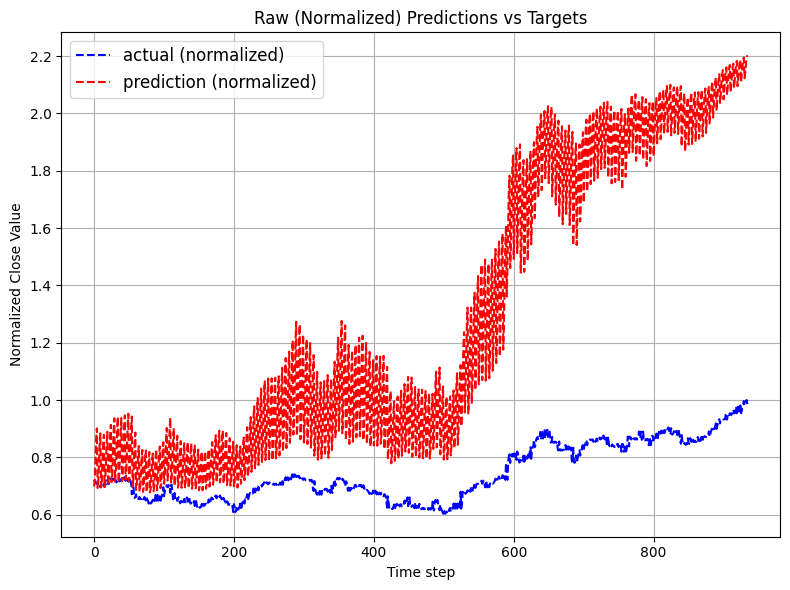

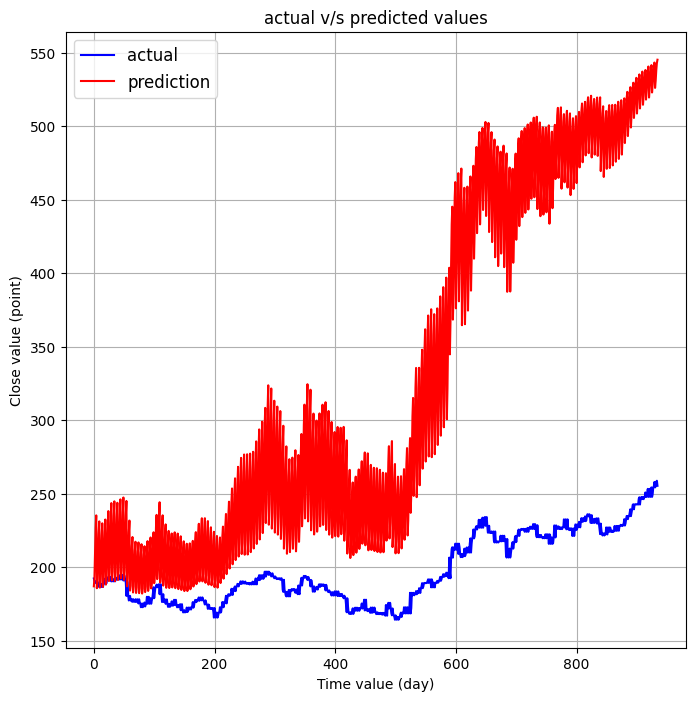

{'val_loss': 2.808370962499935,
 'val_mae': 0.5506010055541992,
 'val_accuracy': 0.0}

In [26]:
print("here!")
trainer.evaluate(val_loader)